In [236]:
#import required libraries
#pandas to make and manipulate dataframes
#numpy for the technical analysis
import pandas as pd
import yfinance as yf
import numpy as np
import math
#import pandas_ta as ta
import hvplot.pandas
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

#DAILY CHART ANALYSIS

In [237]:
# parameter setup (default values in the original indicator)
#These are the constants to be used for the moving averages, the bollinger bands and the keltner channels
#ultimately these will be needed for the squeeze and other calculations
length = 20
mult = 2
length_KC = 21
mult_KC = 2

In [238]:
#With this code you can input any stock and the data for the stock will be pulled from the Yahoo Finance API using yf.Ticker
#The data is pulled for 3 years with a daily timeframe and put into a dataframe called df_stock
value = input("Enter Stock Symbol:")
stock = yf.Ticker(value)
print(stock.info)
stock_df = stock.history(period="3y", interval='1d')
stock_df.index.duplicated().sum()
df_stock = stock_df.loc[~stock_df.index.duplicated(keep='first')]
df_stock

Enter Stock Symbol: spy


{'exchange': 'PCX', 'shortName': 'SPDR S&P 500', 'longName': 'SPDR S&P 500 ETF Trust', 'exchangeTimezoneName': 'America/New_York', 'exchangeTimezoneShortName': 'EDT', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '-14400000', 'quoteType': 'ETF', 'symbol': 'SPY', 'messageBoardId': 'finmb_6160262', 'market': 'us_market', 'annualHoldingsTurnover': None, 'enterpriseToRevenue': None, 'beta3Year': 1, 'profitMargins': None, 'enterpriseToEbitda': None, '52WeekChange': None, 'morningStarRiskRating': None, 'forwardEps': None, 'revenueQuarterlyGrowth': None, 'fundInceptionDate': 727660800, 'annualReportExpenseRatio': None, 'totalAssets': 374031319040, 'bookValue': None, 'fundFamily': 'SPDR State Street Global Advisors', 'lastFiscalYearEnd': None, 'netIncomeToCommon': None, 'trailingEps': None, 'lastDividendValue': None, 'SandP52WeekChange': None, 'priceToBook': None, 'nextFiscalYearEnd': None, 'yield': 0.012999999, 'mostRecentQuarter': None, 'enterpriseValue': None, 'priceHint': 2, 'threeYear

Open        High         Low       Close     Volume  \
Date                                                                    
2018-10-16  262.369483  266.372373  261.866751  265.973969  118255800   
2018-10-17  266.011898  266.685362  263.280064  266.021393  110626000   
2018-10-18  265.025435  265.660978  260.823357  262.179779  134557500   
2018-10-19  262.872237  264.930578  261.297637  262.037506  139901600   
2018-10-22  262.748845  263.090310  260.292100  260.861237   82415800   
...                ...         ...         ...         ...        ...   
2021-10-11  437.160004  440.260010  434.619995  434.690002   65233300   
2021-10-12  435.670013  436.100006  432.779999  433.619995   71181200   
2021-10-13  434.709991  436.049988  431.540009  435.179993   72974000   
2021-10-14  439.079987  442.660004  438.579987  442.500000   70236800   
2021-10-15  444.750000  446.260010  444.089996  445.869995   66226800   

            Dividends  Stock Splits  
Date                                 
2018-10-16        0.0             0  
2018-10-17        0.0             0  
2018-10-18        0.0             0  
2018-10-19        0.0             0  
2018-10-22        0.0             0  
...               ...           ...  
2021-10-11        0.0             0  
2021-10-12        0.0             0  
2021-10-13        0.0             0  
2021-10-14        0.0             0  
2021-10-15        0.0             0  

[756 rows x 7 columns]

In [239]:
# calculate Bollinger Bands which are the measure of the standard deviation.  These bands are set at the 2 times standard deviation
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg = df_stock['Close'].ewm(span=length).mean()
df_stock['Moving average'] = m_avg
# standard deviation
m_std = df_stock['Close'].rolling(window=length).std()
# upper Bollinger Bands
df_stock['upper_BB'] = m_avg + mult * m_std
# lower Bollinger Bands 
df_stock['lower_BB'] = m_avg - mult * m_std

In [240]:
#Stacked Moving averages, exponentially weighted.  Focusing on Fibonacci numbers here with 8, 21, 34, 55 and 89 day moving averages
m_avg_08 = df_stock['Close'].ewm(span=8).mean()
m_avg_21 = df_stock['Close'].ewm(span=21).mean()
m_avg_34 = df_stock['Close'].ewm(span=34).mean()
m_avg_55 = df_stock['Close'].ewm(span=55).mean()
m_avg_89 = df_stock['Close'].ewm(span=89).mean()

df_stock['m_avg_08'] = m_avg_08
df_stock['m_avg_21'] = m_avg_21
df_stock['m_avg_34'] = m_avg_34
df_stock['m_avg_55'] = m_avg_55
df_stock['m_avg_89'] = m_avg_89

In [241]:
# calculate Keltner Channel which is a measure of the average true range.  In this case the channels are set to twice the average true range
# first we need to calculate True Range
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma = df_stock['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock['upper_KC'] = m_avg + range_ma * mult_KC
# lower Keltner Channel
df_stock['lower_KC'] = m_avg - range_ma * mult_KC

In [242]:
#ADX Calculations
# Average directional index which shows the trend of the stock.  Above 20 means trending and below means sideways movement

plus_dm = df_stock["High"].diff()
minus_dm = df_stock["Low"].diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0

#plus_di and minus di show the direction of the trend, if plus_di > minus_di the trend is positive
#if minus_di > plus_di the trend is negative
df_stock['atr'] = df_stock['tr'].ewm(span=14).mean()
df_stock['plus_di'] = 100 * (plus_dm.ewm(alpha = 1/14).mean() / df_stock['atr'])
df_stock['minus_di'] = abs(100 * (minus_dm.ewm(alpha = 1/14).mean() / df_stock['atr']))
dx = (abs(df_stock['plus_di'] - df_stock['minus_di']) / abs(df_stock['plus_di'] + df_stock['minus_di'])) * 100
adx = ((dx.shift(1) * (14 - 1)) + dx) / 14
df_stock['adx'] = adx.ewm(alpha = 1/14).mean() #ADX>20 is trending ADX<20 not trending

In [243]:
# check for 'squeeze' see if the squeeze is on or off.
df_stock['squeeze_on'] = (df_stock['lower_BB'] > df_stock['lower_KC']) & (df_stock['upper_BB'] < df_stock['upper_KC'])
df_stock['squeeze_off'] = (df_stock['lower_BB'] < df_stock['lower_KC']) & (df_stock['upper_BB'] > df_stock['upper_KC'])

In [244]:
# Momentum
# This is the code to eventually make the histograms momentum indicator in the squeeze.  This is where the df['value'] number comes in.

highest = df_stock['High'].rolling(window = length_KC).max()
lowest = df_stock['Low'].rolling(window = length_KC).min()
m1 = (highest + lowest) / 2
df_stock['value'] = (df_stock['Close'] - (m1 + m_avg)/2)
fit_y = np.array(range(0,length_KC))
df_stock['value'] = df_stock['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y, x, 1)[1], raw=True)

df_stock[['squeeze_on', 'squeeze_off']] = (df_stock[['squeeze_on', 'squeeze_off']] == True).astype(float)

df_stock["pct_change"] = df_stock['Close'].pct_change()*100

"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions =  [
    (df_stock['pct_change'] > 0),
    (df_stock['pct_change'] < 0)
]

label = [1, 0]
df_stock['profitable?'] = np.select(conditions, label) 
df_stock.dropna(inplace=True)
df_stock.tail(100)

Open        High         Low       Close     Volume  \
Date                                                                    
2021-05-26  416.170814  416.906036  415.067981  416.369537   43088600   
2021-05-27  417.462438  418.008882  416.290019  416.588104   56707700   
2021-05-28  418.257282  418.535477  417.084893  417.333282   58520200   
2021-06-01  419.847005  419.996032  416.498726  416.965698   54216600   
2021-06-02  417.661150  418.515624  416.588122  417.621399   49097100   
2021-06-03  415.157418  417.283612  413.597527  416.071472   58138800   
2021-06-04  418.038716  420.194746  416.141020  419.876801   55938800   
2021-06-07  419.866868  420.055646  418.475896  419.469452   51555000   
2021-06-08  420.383507  420.482868  417.611507  419.558868   47134300   
2021-06-09  420.453031  420.532533  418.694448  418.932892   48436300   
2021-06-10  420.234474  421.893726  418.833556  420.880280   51020100   
2021-06-11  421.466499  421.694997  420.095386  421.575775   45570800   
2021-06-14  421.694985  422.628930  420.373569  422.519653   42358500   
2021-06-15  422.678635  422.718355  420.810745  421.744690   51508500   
2021-06-16  421.893704  422.132147  417.214063  419.389923   80386100   
2021-06-17  418.952800  420.294076  416.617937  419.250854   90949700   
2021-06-18  415.758054  416.495682  413.375703  413.595001  118676300   
2021-06-21  415.468959  419.715365  414.601742  419.515991   72822000   
2021-06-22  419.506057  422.645992  418.738497  421.758820   57700300   
2021-06-23  421.838570  422.695809  421.160749  421.250458   49445400   
2021-06-24  423.533141  424.191007  423.263984  423.742462   45110300   
2021-06-25  424.539896  425.726098  424.191007  425.247620   58129500   
2021-06-28  425.805859  426.284307  424.529948  426.104889   53159600   
2021-06-29  426.513585  427.191406  425.765980  426.334167   35970500   
2021-06-30  425.845732  427.410726  425.815829  426.693024   64827900   
2021-07-01  427.500435  429.224921  427.430651  429.055450   53441000   
2021-07-02  430.291489  432.713722  429.145137  432.334930   57697700   
2021-07-06  432.394746  432.624023  428.636797  431.547455   68710400   
2021-07-07  432.275138  433.371631  430.132010  433.072571   63549500   
2021-07-08  427.410704  430.351295  426.154718  429.543884   97595200   
2021-07-09  431.148739  434.448166  429.334544  434.129181   76238600   
2021-07-12  434.039479  435.953361  433.580957  435.684204   52889600   
2021-07-13  434.846893  436.441789  433.919870  434.198975   52911300   
2021-07-14  436.003193  436.521551  433.521154  434.846893   64130400   
2021-07-15  433.421470  434.139172  431.338148  433.361664   55126400   
2021-07-16  434.617624  434.667452  429.543883  429.962524   75874700   
2021-07-19  424.828990  430.032321  420.622465  423.612885  147987000   
2021-07-20  424.320617  431.039114  423.473325  429.683441   99608200   
2021-07-21  430.959358  433.311838  429.633619  433.162292   64724400   
2021-07-22  433.351665  434.328546  432.305030  434.069366   47878500   
2021-07-23  436.122810  438.893931  435.395161  438.535095   63766600   
2021-07-26  437.907103  439.621611  437.857274  439.611633   43719200   
2021-07-27  438.505183  438.535086  434.597687  437.608063   67397100   
2021-07-28  438.275911  438.893926  435.913484  437.428619   52472400   
2021-07-29  438.415462  440.389119  438.405484  439.242798   47435300   
2021-07-30  436.511560  438.654688  436.371992  437.109650   68890600   
2021-08-02  438.933784  439.521896  435.813775  436.192566   58783300   
2021-08-03  437.039874  439.870801  434.707350  439.741211   58053900   
2021-08-04  438.375589  439.711306  437.328954  437.578156   46732200   
2021-08-05  438.814183  440.438983  438.475272  440.349274   38969700   
2021-08-06  440.688196  441.525510  440.389136  441.076935   46864100   
2021-08-09  441.047011  441.385922  439.900690  440.718079   41222600   
2021-08-10  441.196543  442.023910  440.468894  441.266327   43339300   
202

In [245]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1 = (df_stock['squeeze_off'][-2] == 0) | (df_stock['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2 = df_stock['value'][-1] > 0

enter_long = long_cond1 and long_cond2
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1 = (df_stock['squeeze_off'][-2] == 0) | (df_stock['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2 = df_stock['value'][-1] < 0
enter_short = short_cond1 and short_cond2

In [246]:
#import mplfinance to make the candlestick charts.  So far I have found this to be the best package for display purposes.
import mplfinance as mpf
%matplotlib widget
# Creating dataframe to graph in candle stick mode
ohcl = df_stock[['Open', 'High', 'Close', 'Low']]
ohcl.head()

Open        High       Close         Low
Date                                                      
2018-12-13  252.808068  253.728165  251.717239  250.531549
2018-12-14  249.431206  250.446163  247.069321  246.481223
2018-12-17  246.054373  247.240063  242.222229  240.486377
2018-12-18  243.967590  244.679004  241.956650  240.249253
2018-12-19  242.042033  246.054404  238.333191  236.521467

In [247]:
# add colors for the 'value bar'.  See the comment below for what the colors mean.
colors = []
for ind, val in enumerate(df_stock['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock['value'][ind-1]:
      color='red'
  colors.append(color)

In [248]:
#This column of colors is added to the dataframe because it will be used as part of our algorithmic trade entry signals
#Red histogram is mark down, Blue is distribution, Yellow is accumulation, and Cyan is mark up
#Generally we want to enter on a squeeze where there is a yellow or cyan histogram
df_stock['colors'] = colors
df_stock['ADX_trend'] = 20

In [249]:
# Adding all the plots including ADX, Stacked moving averages and Squeeze,2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock['Moving average'], color = 'black'),
        mpf.make_addplot(df_stock['m_avg_08'], color = 'yellow'),
        mpf.make_addplot(df_stock[['adx']], panel=2, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock[['plus_di']], panel=2, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock[['minus_di']], panel=2, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock[['ADX_trend']], panel=2, color = 'red', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_08'], panel=3, color='red', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_21'], panel=3, color='orange', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_34'], panel=3, color='yellow', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_55'], panel=3, color='green', secondary_y=False),
        mpf.make_addplot(df_stock['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# Plot ohcl with subplots
#Panel 1 is the squeeze
#Panel 2 is the ADX
#Panel 3 is the stacked moving average momentum indicators
fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              ylabel='Price ($)',       
              addplot=apds,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [250]:
def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    
    Slow stochastics is an oscillating momentum indicator
    It goes up with the stock and down as well
    Right now 70 is considered overbought and 30 is oversold
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()

    return df


stochs = stochastics( df_stock, 'Low', 'High', 'Close', 14, 3 )
slow_k = stochs['k_slow'].values
fast_k = stochs['k_fast'].values
df_stock["slow_K"] = slow_k
df_stock['fast_K'] = fast_k
df_stock

Open        High         Low       Close     Volume  \
Date                                                                    
2018-12-13  252.808068  253.728165  250.531549  251.717239   96662700   
2018-12-14  249.431206  250.446163  246.481223  247.069321  116961100   
2018-12-17  246.054373  247.240063  240.486377  242.222229  165492300   
2018-12-18  243.967590  244.679004  240.249253  241.956650  134515100   
2018-12-19  242.042033  246.054404  236.521467  238.333191  214992800   
...                ...         ...         ...         ...        ...   
2021-10-11  437.160004  440.260010  434.619995  434.690002   65233300   
2021-10-12  435.670013  436.100006  432.779999  433.619995   71181200   
2021-10-13  434.709991  436.049988  431.540009  435.179993   72974000   
2021-10-14  439.079987  442.660004  438.579987  442.500000   70236800   
2021-10-15  444.750000  446.260010  444.089996  445.869995   66226800   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2018-12-13        0.0             0      255.041173  264.034978  246.047367   
2018-12-14        0.0             0      254.270431  263.945199  244.595663   
2018-12-17        0.0             0      253.107257  264.050462  242.164053   
2018-12-18        0.0             0      252.032144  263.840598  240.223690   
2018-12-19        0.0             0      250.712881  264.153858  237.271904   
...               ...           ...             ...         ...         ...   
2021-10-11        0.0             0      437.538792  448.158672  426.918911   
2021-10-12        0.0             0      437.165573  447.627897  426.703249   
2021-10-13        0.0             0      436.976470  446.487793  427.465147   
2021-10-14        0.0             0      437.502521  446.446381  428.558660   
2021-10-15        0.0             0      438.299423  447.966871  428.631974   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2018-12-13  253.102673  255.131924  255.902818  256.437788  256.782818   
2018-12-14  251.761893  254.385327  255.351472  256.010423  256.429464   
2018-12-17  249.641925  253.260926  254.536303  255.387609  255.919853   
2018-12-18  247.934059  252.217518  253.759101  254.786615  255.425739   
2018-12-19  245.800507  250.937749  252.810451  254.056965  254.828747   
...                ...         ...         ...         ...         ...   
2021-10-11  435.586247  437.688243  438.730072  437.799947  433.124518   
2021-10-12  435.149302  437.318403  438.438068  437.650663  433.135529   
2021-10-13  435.156122  437.124002  438.251892  437.562425  433.180961   
2021-10-14  436.788095  437.612729  438.494641  437.738767  433.388051   
2021-10-15  438.806295  438.363389  438.916090  438.029168  433.665428   

                 tr0       tr1       tr2        tr    upper_KC    lower_KC  \
Date                                                                         
2018-12-13  3.196616  1.925553  1.271063  3.196616  265.036108  245.046238   
2018-12-14  3.964940  1.271076  5.236016  5.236016  264.309546  244.231317   
2018-12-17  6.753685  0.170742  6.582943  6.753685  263.466990  242.747525   
2018-12-18  4.429751  2.456775  1.972976  4.429751  262.253402  241.810886   
2018-12-19  9.532937  4.097755  5.435182  9.532937  261.749379  239.676382   
...              ...       ...       ...       ...         ...         ...   
2021-10-11  5.640015  2.400024  3.239990  5.640015  449.026701  426.050882   
2021-10-12  3.320007  1.410004  1.910004  3.320007  448.212765  426.118381   
2021-10-13  4.509979  2.429993  2.079987  4.509979  447.839368  426.113572   
2021-10-14  4.080017  7.480011  3.399994  7.480011  448.737884  426.267157   
2021-10-15  2.170013  3.760010  1.589996  3.760010  449.197028  427.401818   

                 atr    plus_di   minus_di        adx  squeeze

In [251]:
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl 

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

#RSI stands for Relative strength Indicator
#it is also a momentum oscillation indicator but moves a lot slower than the stochastics
#if the stock goes up the RSI should go up and vice versa
#if it doesn't this indicates a divergence, especially at the higher timeframes
#again 70 is overbought and 30 is oversold
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df_stock['rsi_14'] = get_rsi(df_stock['Close'], 14)
df_stock = df_stock.dropna()
df_stock['Overbought'] = 70
df_stock['Oversold'] = 30
df_stock

Open        High         Low       Close     Volume  \
Date                                                                    
2019-01-07  241.089305  244.199637  240.135214  242.701721  103139100   
2019-01-08  245.029717  245.497212  242.339172  244.981995  102512600   
2019-01-09  245.735696  247.023725  244.428596  246.126877   95006600   
2019-01-10  244.495418  247.262277  243.770300  246.995132   96823900   
2019-01-11  245.850179  247.119137  245.230026  247.090515   73858100   
...                ...         ...         ...         ...        ...   
2021-10-11  437.160004  440.260010  434.619995  434.690002   65233300   
2021-10-12  435.670013  436.100006  432.779999  433.619995   71181200   
2021-10-13  434.709991  436.049988  431.540009  435.179993   72974000   
2021-10-14  439.079987  442.660004  438.579987  442.500000   70236800   
2021-10-15  444.750000  446.260010  444.089996  445.869995   66226800   

            Dividends  Stock Splits  Moving average    upper_BB    lower_BB  \
Date                                                                          
2019-01-07        0.0             0      241.195688  256.885256  225.506120   
2019-01-08        0.0             0      241.557494  256.770850  226.344137   
2019-01-09        0.0             0      241.993988  256.717336  227.270640   
2019-01-10        0.0             0      242.471589  256.749323  228.193855   
2019-01-11        0.0             0      242.912575  256.511261  229.313889   
...               ...           ...             ...         ...         ...   
2021-10-11        0.0             0      437.538792  448.158672  426.918911   
2021-10-12        0.0             0      437.165573  447.627897  426.703249   
2021-10-13        0.0             0      436.976470  446.487793  427.465147   
2021-10-14        0.0             0      437.502521  446.446381  428.558660   
2021-10-15        0.0             0      438.299423  447.966871  428.631974   

              m_avg_08    m_avg_21    m_avg_34    m_avg_55    m_avg_89  \
Date                                                                     
2019-01-07  238.484157  241.484956  244.516385  247.133246  248.958641   
2019-01-08  239.928122  241.804265  244.543955  247.045359  248.836284   
2019-01-09  241.305623  242.198797  244.637489  247.008027  248.753625   
2019-01-10  242.569959  242.636409  244.776531  247.007505  248.700417   
2019-01-11  243.574528  243.042662  244.912749  247.010847  248.652094   
...                ...         ...         ...         ...         ...   
2021-10-11  435.586247  437.688243  438.730072  437.799947  433.124518   
2021-10-12  435.149302  437.318403  438.438068  437.650663  433.135529   
2021-10-13  435.156122  437.124002  438.251892  437.562425  433.180961   
2021-10-14  436.788095  437.612729  438.494641  437.738767  433.388051   
2021-10-15  438.806295  438.363389  438.916090  438.029168  433.665428   

                 tr0       tr1       tr2        tr    upper_KC    lower_KC  \
Date                                                                         
2019-01-07  4.064423  3.396582  0.667841  4.064423  253.416565  228.974811   
2019-01-08  3.158040  2.795491  0.362549  3.158040  253.239214  229.875773   
2019-01-09  2.595129  2.041730  0.553399  2.595129  253.083221  230.904755   
2019-01-10  3.491977  1.135400  2.356577  3.491977  253.186262  231.756917   
2019-01-11  1.889111  0.124004  1.765107  1.889111  252.994583  232.830566   
...              ...       ...       ...       ...         ...         ...   
2021-10-11  5.640015  2.400024  3.239990  5.640015  449.026701  426.050882   
2021-10-12  3.320007  1.410004  1.910004  3.320007  448.212765  426.118381   
2021-10-13  4.509979  2.429993  2.079987  4.509979  447.839368  426.113572   
2021-10-14  4.080017  7.480011  3.399994  7.480011  448.737884  426.267157   
2021-10-15  2.170013  3.760010  1.589996  3.760010  449.197028  427.401818   

                 atr    plus_di   minus_di        adx  squeeze

In [252]:
#this plot provides the second set of studies which include the Slow Stochastic and the RSI
apds2 = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
         mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
         mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
         mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
         mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
         mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
         mpf.make_addplot(df_stock['Moving average'], color = 'black'),
         mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
         mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
         mpf.make_addplot(df_stock['slow_K'], panel=4, color = 'red'),
         mpf.make_addplot(df_stock['fast_K'], panel=4, color = 'blue'),
         mpf.make_addplot(df_stock['Overbought'], panel=4, color = 'green'),
         mpf.make_addplot(df_stock['Oversold'], panel=4, color = 'red'),
         mpf.make_addplot(df_stock['Overbought'], panel=3, color = 'green'),
         mpf.make_addplot(df_stock['Oversold'], panel=3, color = 'red'),
         mpf.make_addplot(df_stock['rsi_14'], panel=3, color='purple')]
# Plot ohcl with subplots
#Panel 1 is the squeeze
#Panel 2 is the Slow Stochastics
#Panel 3 is the RSI
fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              volume=True,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [253]:
#This code takes a group of 2 to 3 candles and tells the trader if the swing over the next day to few days will be bullish, bearish, or no pattern
for i in range(2,df_stock.shape[0]):
    current = df_stock.iloc[i,:]
    prev = df_stock.iloc[i-1,:]
    prev_2 = df_stock.iloc[i-2,:]
    realbody = abs(current['Open'] - current['Close'])
    candle_range = current['High'] - current['Low']
    idx = df_stock.index[i]  
# Bullish swing
    df_stock.loc[idx,'Bullish swing'] = current['Low'] > prev['Low'] and prev['Low'] < prev_2['Low']
# Bearish swing
    df_stock.loc[idx,'Bearish swing'] = current['High'] < prev['High'] and prev['High'] > prev_2['High']
# Bullish pinbar
    df_stock.loc[idx,'Bullish pinbar'] = realbody <= candle_range/3 and  min(current['Open'], current['Close']) > (current['High'] + current['Low'])/2 and current['Low'] < prev['Low']
# Bearish pinbar
    df_stock.loc[idx,'Bearish pinbar'] = realbody <= candle_range/3 and max(current['Open'] , current['Close']) < (current['High'] + current['Low'])/2 and current['High'] > prev['High']
    
  # Inside bar
    df_stock.loc[idx,'Inside bar'] = current['High'] < prev['High'] and current['Low'] > prev['Low']
    
  # Outside bar
    df_stock.loc[idx,'Outside bar'] = current['High'] > prev['High'] and current['Low'] < prev['Low']
  
  # Bullish engulfing
    df_stock.loc[idx,'Bullish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] > current['Open']
# Bearish engulfing
    df_stock.loc[idx,'Bearish engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']

df_stock.fillna(False, inplace=True)

In [254]:
columns = ['Bullish swing', 'Bearish swing', 'Bullish pinbar', 'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing','Bearish engulfing']
#The creation of this column using this function is to use this for a graph or to get you the latest pattern

def convert(df):
    patterns = []
    for i in columns:
        if df[i]:
            patterns.append(i)
    #df['patterns'] = patterns
    if not patterns:
        patterns.append('No pattern')
    return patterns

#df_stock_dow.apply(convert, axis=1)
df_stock['pattern'] = df_stock.apply(convert, axis = 1)

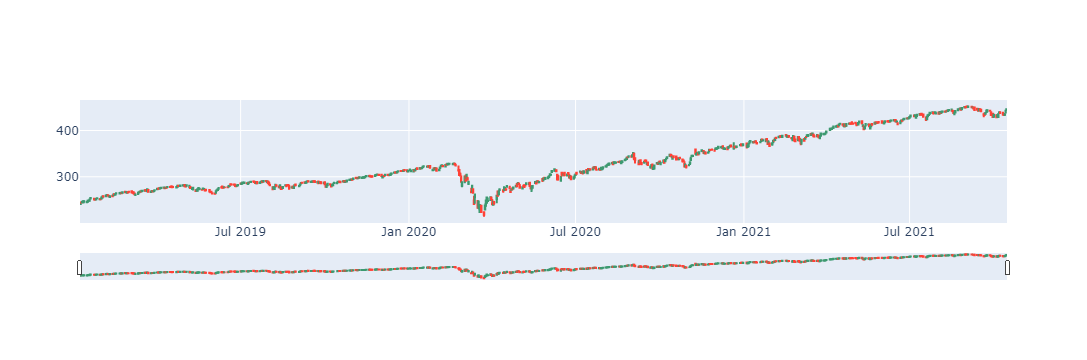

In [255]:
#This graph will give you the candlestick pattern.  When you hover over the candles, you will see the pattern at the time at which you hover the cursor
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df_stock.index,
                open=df_stock['Open'],
                high=df_stock['High'],
                low=df_stock['Low'],
                close=df_stock['Close'])])
fig.update_traces(text=df_stock['pattern'], selector=dict(type='candlestick'))
fig.show()

In [256]:
#Dictionary of patterns with definitions
pattern_dict = {
    'Bullish swing': 'upswing pattern',
    'Bearish swing': 'downward pattern',
    'Bullish pinbar': 'upswing hammer',
    'Bearish pinbar': 'downswing hammer',
    'Inside bar': 'trend change',
    'Outside bar': 'trend change',
    'Bullish engulfing': 'upswing from downtrend',
    'Bearish engulfing': 'downswing from uptrend',
    'No pattern': 'No pattern detected'
    }
#This will give the most current pattern from the dataframe
today = df_stock['pattern'][-1]
for i in today:
    print(f'Todays pattern is {i}, {pattern_dict[i]}')

Todays pattern is No pattern, No pattern detected


In [257]:
#checks the momentum based on the EMA's stacking
#If smaller EMA's stack above the larger, the momentum is positive, vice versa, negative
def momentum_checker(index):
    if (df_stock['m_avg_08'][index] > df_stock['m_avg_21'][index] > df_stock['m_avg_34'][index] > df_stock['m_avg_55'][index] > df_stock['m_avg_89'][index]):
        return 'Positive momentum'
    elif (df_stock['m_avg_08'][index] < df_stock['m_avg_21'][index] < df_stock['m_avg_34'][index] < df_stock['m_avg_55'][index] < df_stock['m_avg_89'][index]):
        return 'Negative momentum'
    else:
        return 'neutral'

In [258]:
#This code throws up a flag to show if the trend of the stock is up, down, or sideways
#It uses the average directional index to determine the strength of the trend
#If ADX > 20 and the plus_di is above the minus_di the trend is positive
#If ADX > 20 and the plus_di is below the minus_di the trend is negative
#If ADX < 20 the trend is sideways

df_stock['ADX_trend'] = 20

def ADX_trend_flag(index):
    if (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] > df_stock['minus_di'][index]):
        return 'positive trend'
    elif (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] < df_stock['minus_di'][index]):
        return 'negative trend'
    elif (df_stock['adx'][index] < df_stock['ADX_trend'][index]):
        return 'neutral or sideways trend'

In [259]:
#This code gives an early warning if the 8 EMA crosses the 21 to the downside and amplifies the warning if it crosses the 34
#This is especially critical if it is happening to one of the market indices
def warning(index):
    if (df_stock['m_avg_08'][index] < df_stock['m_avg_21'][index]):
        return 'Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.'
    if (df_stock['m_avg_08'][index] < df_stock['m_avg_34'][index]):
        return '8 EMA has crossed 34 to the downside.  As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema'
    elif (df_stock['m_avg_08'][index] > df_stock['m_avg_21'][index]):
        return 'Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger'

In [260]:
#Warning flag to show if the squeeze is on and what market cycle the stock or index is in
def squeeze_flag(index):
    if (df_stock['squeeze_on'][index] == 1.0):
        return 'squeeze is on'
    else:
        return 'squeeze is off'
    
def squeeze_momentum(index):    
    if (df_stock['colors'][index] == 'cyan'):
        return 'stock is in a mark up mode'
    elif (df_stock['colors'][index] == 'blue'):
        return 'stock is in a distribution mode'
    elif (df_stock['colors'][index] == 'yellow'):
        return 'stock is in an accumulation mode'
    elif (df_stock['colors'][index] == 'red'):
        return 'stock is in a mark down mode'

In [261]:
squeeze_flag(-1)

'squeeze is on'

In [262]:
squeeze_momentum(-1)

'stock is in a mark up mode'

In [263]:
#Calling the warning flag functions
momentum_checker(-1)
ADX_trend_flag(-1)
warning(-1)
squeeze_momentum(-1)

'stock is in a mark up mode'

In [264]:
#Yahoo Finance download for the Fibonacci levels
df = yf.download(value,'2021-03-04', '2021-10-17')

[*********************100%***********************]  1 of 1 completed


In [265]:
#Graph for the Fibonacci Levels
fig, ax = plt.subplots()
ax.plot(df.Close, color='black')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [266]:
# Define minimum and maximum price points
price_min = df.Close.min()
price_max = df.Close.max()

In [267]:
# Fibonacci Levels using the high and the low of the time period in question
diff = price_max - price_min
level1 = price_max - 0.236 * diff
level2 = price_max - 0.382 * diff
level3 = price_max - 0.500 * diff
level4 = price_max - 0.618 * diff

In [268]:
#This adds the Fibonacci Levels to the graph above:
#Level 1 at 23.6%
#Level 2 at 38.2%
#Level 3 at 50%
#Level 4 at 61.8%
ax.axhspan(level1, price_min, alpha=0.4, color='lightsalmon')
ax.axhspan(level2, level1, alpha=0.5, color='palegoldenrod')
ax.axhspan(level3, level2, alpha=0.5, color='palegreen')
ax.axhspan(level4, level3, alpha=0.5, color='red')
ax.axhspan(price_max, level4, alpha=0.5, color='powderblue')

plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.show()

No handles with labels found to put in legend.


In [269]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
# The threshold is to set the histogram of the squeeze as close to the zero line as possible
# We want the squeeze to be on and the histogram to be close to zero and the color of the histogram to be yellow or cyan indicating accumulation
# or markup
t_percent = float(input("enter threshold percentage"))
df_stock['value_threshold'] = abs(df_stock['value'].min()* t_percent)
df_stock['squeeze_threshold'] = 1.0
df_stock["squeeze_entry"] = np.logical_and(np.greater(df_stock["value"], df_stock['value_threshold']), 
                                           np.equal(df_stock['squeeze_on'], df_stock['squeeze_threshold']))
df_stock['squeeze_entry'] = df_stock['squeeze_entry'].astype(float)
df_stock['Entry/Exit'] = df_stock['squeeze_entry'].diff()
df_stock_clean = df_stock.dropna()


enter threshold percentage .05


In [282]:
#This is the algo strategy.  The entry is when the squeeze is on and the histogram is near 0 and either yellow or cyan as stated before
#Exit strategy is when the stock moves up any percent you want to input
#The form of input is 1.something
#this means for example 1.5 means 50%

percent = float(input("Enter percent return"))
def implement_bb_strategy(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal

Enter percent return 1.07


In [283]:
#calling the algo function and returning the buy price, sell price, and the squeeze signal
buy_price, sell_price, squeeze_signal = implement_bb_strategy(df_stock["Close"], df_stock['squeeze_on'], df_stock['value'], 
                                                              df_stock['upper_KC'], df_stock['value_threshold'], df_stock['colors'], percent)

In [284]:
#setting dataframes to the results of the algo function
df_stock['buy_price'] =  buy_price
df_stock['sell_price'] = sell_price
df_stock['squeeze_signal'] = squeeze_signal

In [285]:
# This is give the entry and exit signals in the form of a green triangle and red triangle respectively
# Visualize exit position relative to close price
exit = df_stock[df_stock['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock[df_stock['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [286]:
# This code tells us to enter into a position when the squeeze signal is triggered according to the algo function given above
position = []
for i in range(len(squeeze_signal)):
    if df_stock['squeeze_signal'][i] < 1:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock['Close'])):
    if df_stock['squeeze_signal'][i] == 1:
        position[i] = 1
    elif df_stock['squeeze_signal'][i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock['Close']
squeeze_signal = pd.DataFrame(squeeze_signal).rename(columns = {0:'squeeze_signal'}).set_index(df_stock.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock.index)

frames = [close_price, squeeze_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy

Date       Close  squeeze_signal  squeeze_position
0   2019-01-07  242.701721             0.0                 0
1   2019-01-08  244.981995             0.0                 0
2   2019-01-09  246.126877             0.0                 0
3   2019-01-10  246.995132             0.0                 0
4   2019-01-11  247.090515             0.0                 0
..         ...         ...             ...               ...
696 2021-10-11  434.690002             0.0                 1
697 2021-10-12  433.619995             0.0                 1
698 2021-10-13  435.179993             0.0                 1
699 2021-10-14  442.500000             0.0                 1
700 2021-10-15  445.869995             0.0                 1

[701 rows x 4 columns]

In [287]:
#This code gives us the results of the Algo trade compounding the % return and starting with 100000 as the initial investment and telling 

stock_ret = pd.DataFrame(np.diff(df_stock['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)


Profit gained from the Squeeze strategy by investing $100k in spy is 81243.91
Profit percentage of the Squeeze strategy : 81%
81243.91439819336


In [42]:
#libraries for the volume profile graphs
import pandas as pd
import numpy as np
from scipy import stats, signal
import plotly.express as px
import plotly.graph_objects as go

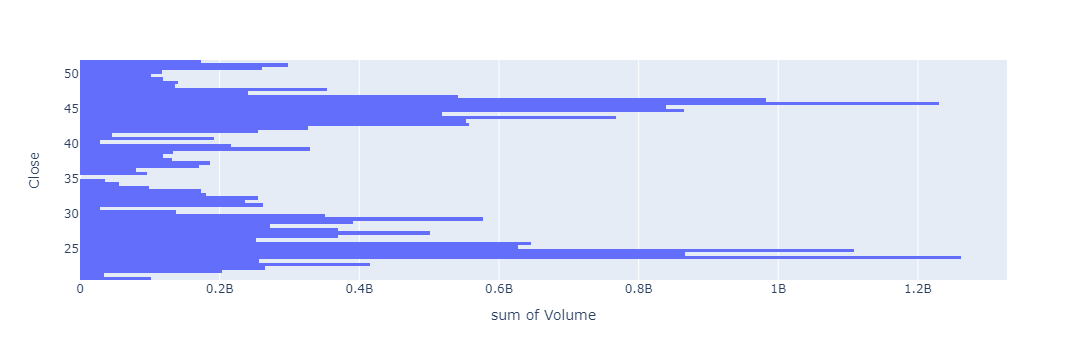

In [43]:
#This is the volume profile in which you get the volume activity at each price.  This highest volume activity at a certain price can make that price
#a good bounce off point
px.histogram(df_stock, x='Volume', y='Close', nbins=150, orientation='h').show()

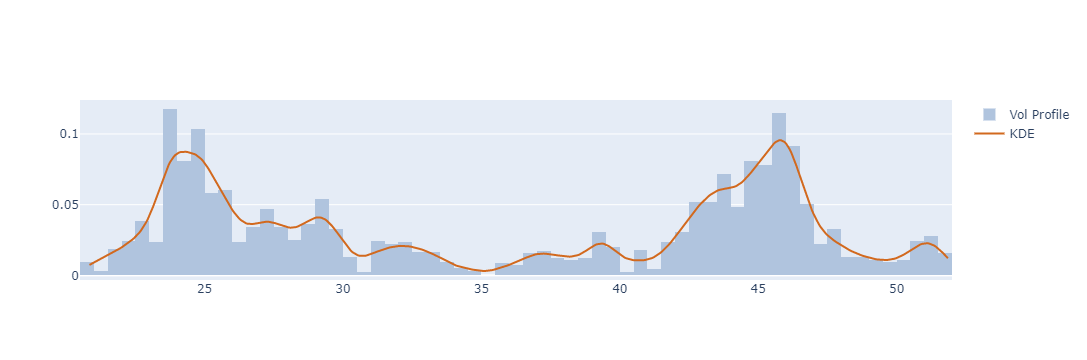

In [44]:
#This makes the volume profile graphs vertical and shows at which price the peak volumes are
kde_factor = 0.05
num_samples = 500
close = df_stock['Close']
volume = df_stock['Volume']
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

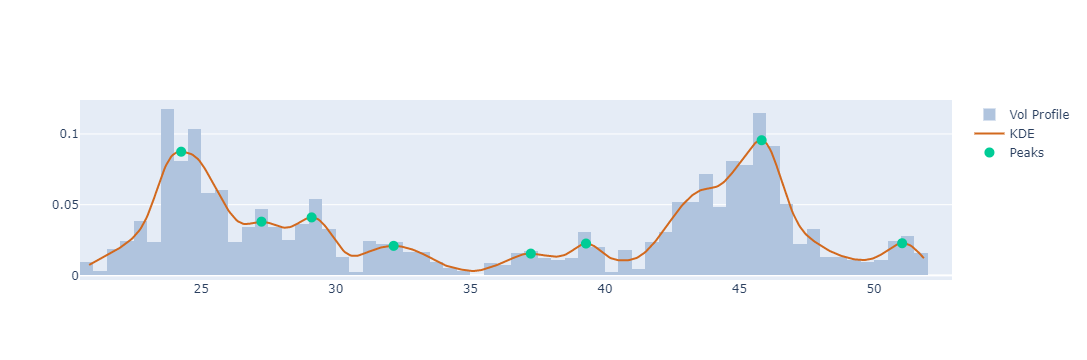

In [45]:
#This adds a green dot to show you
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
rgs=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

#MACHINE LEARNING

In [46]:
# Set x variable list of features
x_var_list = ['Open', 'High', 'Low', 'Close', 'Moving average', 'upper_BB', 'lower_BB', 'm_avg_08', 'pct_change', 'squeeze_on', 'upper_KC', 'lower_KC', 'squeeze_signal']

# Filter by x-variable list
df_stock[x_var_list]

Open       High        Low      Close  Moving average  \
Date                                                                     
2019-01-07  43.734817  44.146720  43.515138  43.606670       43.367556   
2019-01-08  43.844663  44.082649  42.947629  43.515141       43.381659   
2019-01-09  43.487672  43.917881  43.094080  43.753120       43.417143   
2019-01-10  43.478533  43.981968  43.304620  43.707367       43.444859   
2019-01-11  43.478522  44.018571  43.185614  43.817196       43.480407   
...               ...        ...        ...        ...             ...   
2021-10-11  48.200001  48.459999  47.220001  47.279999       47.075654   
2021-10-12  47.290001  47.529999  46.520000  46.650002       47.035115   
2021-10-13  46.570000  46.570000  45.220001  46.049999       46.941295   
2021-10-14  46.680000  46.889999  44.830002  45.310001       46.785933   
2021-10-15  45.720001  48.740002  45.709999  48.380001       46.937749   

             upper_BB   lower_BB   m_avg_08  pct_change  squeeze_on  \
Date                                                                  
2019-01-07  46.004331  40.730782  42.861344   -0.646511         0.0   
2019-01-08  45.564613  41.198705  43.006633   -0.209899         1.0   
2019-01-09  45.451842  41.382444  43.172519    0.546890         1.0   
2019-01-10  45.478472  41.411246  43.291374   -0.104572         1.0   
2019-01-11  45.528624  41.432191  43.408223    0.251282         1.0   
...               ...        ...        ...         ...         ...   
2021-10-11  48.612804  45.538503  47.460822   -1.500003         1.0   
2021-10-12  48.517762  45.552468  47.280640   -1.332482         1.0   
2021-10-13  48.477977  45.404612  47.007164   -1.286178         1.0   
2021-10-14  48.470666  45.101201  46.630017   -1.606944         1.0   
2021-10-15  48.724135  45.151364  47.018902    6.775545         1.0   

             upper_KC   lower_KC  squeeze_signal  
Date                                              
2019-01-07  45.867217  40.867896             0.0  
2019-01-08  45.860353  40.902965             1.0  
2019-01-09  45.819982  41.014304             0.0  
2019-01-10  45.752067  41.137651             0.0  
2019-01-11  45.729124  41.231691             0.0  
...               ...        ...             ...  
2021-10-11  49.530912  44.620395             0.0  
2021-10-12  49.450805  44.619426             0.0  
2021-10-13  49.397376  44.485213             0.0  
2021-10-14  49.393280  44.178587             0.0  
2021-10-15  49.931701  43.943798             0.0  

[701 rows x 13 columns]

In [47]:
# Shift DataFrame values by 1
df_stock[x_var_list] = df_stock[x_var_list].shift(1)
df_stock[x_var_list].tail()

Open       High        Low      Close  Moving average  \
Date                                                                     
2021-10-11  47.869999  48.340000  47.660000  48.000000       47.054144   
2021-10-12  48.200001  48.459999  47.220001  47.279999       47.075654   
2021-10-13  47.290001  47.529999  46.520000  46.650002       47.035115   
2021-10-14  46.570000  46.570000  45.220001  46.049999       46.941295   
2021-10-15  46.680000  46.889999  44.830002  45.310001       46.785933   

             upper_BB   lower_BB   m_avg_08  pct_change  squeeze_on  \
Date                                                                  
2021-10-11  48.678050  45.430237  47.512486    0.502516         1.0   
2021-10-12  48.612804  45.538503  47.460822   -1.500003         1.0   
2021-10-13  48.517762  45.552468  47.280640   -1.332482         1.0   
2021-10-14  48.477977  45.404612  47.007164   -1.286178         1.0   
2021-10-15  48.470666  45.101201  46.630017   -1.606944         1.0   

             upper_KC   lower_KC  squeeze_signal  
Date                                              
2021-10-11  49.506929  44.601359             0.0  
2021-10-12  49.530912  44.620395             0.0  
2021-10-13  49.450805  44.619426             0.0  
2021-10-14  49.397376  44.485213             0.0  
2021-10-15  49.393280  44.178587             0.0

In [48]:
# Drop NAs
df_stock = df_stock.dropna(subset=x_var_list)
df_stock = df_stock.dropna(subset=["pct_change"])

# Replace positive/negative infinity values
df_stock = df_stock.replace([np.inf, -np.inf], np.nan)

# Display sample data
df_stock.head()

Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
2019-01-08  43.734817  44.146720  43.515138  43.606670  19702900        0.0   
2019-01-09  43.844663  44.082649  42.947629  43.515141  18837700        0.0   
2019-01-10  43.487672  43.917881  43.094080  43.753120  16208400        0.0   
2019-01-11  43.478533  43.981968  43.304620  43.707367  20006900        0.0   
2019-01-14  43.478522  44.018571  43.185614  43.817196  23827600        0.0   

            Stock Splits  Moving average   upper_BB   lower_BB   m_avg_08  \
Date                                                                        
2019-01-08             0       43.367556  46.004331  40.730782  42.861344   
2019-01-09             0       43.381659  45.564613  41.198705  43.006633   
2019-01-10             0       43.417143  45.451842  41.382444  43.172519   
2019-01-11             0       43.444859  45.478472  41.411246  43.291374   
2019-01-14             0       43.480407  45.528624  41.432191  43.408223   

             m_avg_21   m_avg_34   m_avg_55   m_avg_89       tr0       tr1  \
Date                                                                         
2019-01-08  43.446175  44.185910  44.875942  45.369669  1.135020  0.475978   
2019-01-09  43.474191  44.160337  44.830305  45.320351  0.823801  0.402741   
2019-01-10  43.495465  44.133623  44.784887  45.271546  0.677348  0.228847   
2019-01-11  43.524810  44.114996  44.745932  45.227892  0.832957  0.311204   
2019-01-14  43.597374  44.127080  44.728889  45.200870  0.997718  0.567514   

                 tr2        tr   upper_KC   lower_KC       atr    plus_di  \
Date                                                                        
2019-01-08  0.659042  1.135020  45.867217  40.867896  1.204729  17.169089   
2019-01-09  0.421061  0.823801  45.860353  40.902965  1.153926  16.625603   
2019-01-10  0.448501  0.677348  45.819982  41.014304  1.090369  16.746229   
2019-01-11  0.521753  0.832957  45.752067  41.137651  1.056041  16.290503   
2019-01-14  0.430204  0.997718  45.729124  41.231691  1.048263  17.749681   

             minus_di        adx  squeeze_on  squeeze_off     value  \
Date                                                                  
2019-01-08  25.574917  35.020813         0.0          0.0 -0.929268   
2019-01-09  24.765346  33.906440         1.0          0.0 -0.309803   
2019-01-10  24.311053  32.867697         1.0          0.0  0.207861   
2019-01-11  24.100664  31.826578         1.0          0.0  0.691126   
2019-01-14  22.524666  30.884359         1.0          0.0  1.219238   

            pct_change  profitable?  colors  ADX_trend     slow_K     fast_K  \
Date                                                                           
2019-01-08   -0.646511            0  yellow         20  90.762841  86.756317   
2019-01-09   -0.209899            1  yellow         20  89.059498  91.746556   
2019-01-10    0.546890            0    cyan         20  89.763339  90.787144   
2019-01-11   -0.104572            1    cyan         20  91.874622  93.090165   
2019-01-14    0.251282            1    cyan         20  94.199179  98.720229   

               rsi_14  Overbought  Oversold  Bullish swing  Bearish swing  \
Date                                                                        
2019-01-08  58.392825          70        30          False          False   
2019-01-09  60.257223          70        30           True          False   
2019-01-10  59.703315          70        30          False          False   
2019-01-11  60.638668          70        30          False          False   
2019-01-14  64.685139          70        30           True          False   

            Bullish pinbar  Bearish pinbar  Inside bar  Outside bar  \
Date                                                                  
2019-01-08           False           False       False        False   
2019-01-09           Fal

In [49]:
# Construct the dependent variable where if hourly return is greater than 0, then 1, else, 0.
df_stock["Positive Return"] = np.where(df_stock["pct_change"] > 0, 1.0, 0.0)

# Display sample data
df_stock

Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
2019-01-08  43.734817  44.146720  43.515138  43.606670  19702900        0.0   
2019-01-09  43.844663  44.082649  42.947629  43.515141  18837700        0.0   
2019-01-10  43.487672  43.917881  43.094080  43.753120  16208400        0.0   
2019-01-11  43.478533  43.981968  43.304620  43.707367  20006900        0.0   
2019-01-14  43.478522  44.018571  43.185614  43.817196  23827600        0.0   
...               ...        ...        ...        ...       ...        ...   
2021-10-11  47.869999  48.340000  47.660000  48.000000  15387900        0.0   
2021-10-12  48.200001  48.459999  47.220001  47.279999  18995700        0.0   
2021-10-13  47.290001  47.529999  46.520000  46.650002  24150300        0.0   
2021-10-14  46.570000  46.570000  45.220001  46.049999  53257700        0.0   
2021-10-15  46.680000  46.889999  44.830002  45.310001  60073400        0.0   

            Stock Splits  Moving average   upper_BB   lower_BB   m_avg_08  \
Date                                                                        
2019-01-08             0       43.367556  46.004331  40.730782  42.861344   
2019-01-09             0       43.381659  45.564613  41.198705  43.006633   
2019-01-10             0       43.417143  45.451842  41.382444  43.172519   
2019-01-11             0       43.444859  45.478472  41.411246  43.291374   
2019-01-14             0       43.480407  45.528624  41.432191  43.408223   
...                  ...             ...        ...        ...        ...   
2021-10-11             0       47.054144  48.678050  45.430237  47.512486   
2021-10-12             0       47.075654  48.612804  45.538503  47.460822   
2021-10-13             0       47.035115  48.517762  45.552468  47.280640   
2021-10-14             0       46.941295  48.477977  45.404612  47.007164   
2021-10-15             0       46.785933  48.470666  45.101201  46.630017   

             m_avg_21   m_avg_34   m_avg_55   m_avg_89       tr0       tr1  \
Date                                                                         
2019-01-08  43.446175  44.185910  44.875942  45.369669  1.135020  0.475978   
2019-01-09  43.474191  44.160337  44.830305  45.320351  0.823801  0.402741   
2019-01-10  43.495465  44.133623  44.784887  45.271546  0.677348  0.228847   
2019-01-11  43.524810  44.114996  44.745932  45.227892  0.832957  0.311204   
2019-01-14  43.597374  44.127080  44.728889  45.200870  0.997718  0.567514   
...               ...        ...        ...        ...       ...       ...   
2021-10-11  47.055967  46.867773  46.559002  45.731278  1.239998  0.459999   
2021-10-12  47.019061  46.855329  46.562252  45.751694  1.009998  0.250000   
2021-10-13  46.930964  46.809310  46.543957  45.758323  1.349998  0.080002   
2021-10-14  46.783604  46.723636  46.499887  45.748360  2.059998  0.840000   
2021-10-15  46.928731  46.818285  46.567034  45.806841  3.030003  3.430000   

                 tr2        tr   upper_KC   lower_KC       atr    plus_di  \
Date                                                                        
2019-01-08  0.659042  1.135020  45.867217  40.867896  1.204729  17.169089   
2019-01-09  0.421061  0.823801  45.860353  40.902965  1.153926  16.625603   
2019-01-10  0.448501  0.677348  45.819982  41.014304  1.090369  16.746229   
2019-01-11  0.521753  0.832957  45.752067  41.137651  1.056041  16.290503   
2019-01-14  0.430204  0.997718  45.729124  41.231691  1.048263  17.749681   
...              ...       ...        ...        ...       ...        ...   
2021-10-11  0.779999  1.239998  49.506929  44.601359  1.191708  24.270878   
2021-10-12  0.759998  1.009998  49.530912  44.620395  1.167480  23.004945   
2021-10-13  1.430000  1.430000  49.450805  44.619426  1.202483  20.739923   
2021-10-14  1.219997  2.059998  49.397376  44.485213  1.316818  19.322128   
2021-10-15  0.399998  3.430000  49.393280  44.17

In [50]:
# Construct training start and end dates
training_start = df_stock.index.min().strftime(format= "%Y-%m-%d")
training_end = "2019-09-14"

# Construct testing start and end dates
testing_start =  "2019-09-15"
testing_end = df_stock.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-01-08
Training End: 2019-09-14
Testing Start: 2019-09-15
Testing End: 2021-10-15


In [51]:
# Construct the X_train and y_train datasets
X_train = df_stock[x_var_list][training_start:training_end]
y_train = df_stock["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

Open       High        Low      Close  Moving average  \
Date                                                                     
2019-09-09  44.870949  45.050129  44.418275  44.465431       43.368425   
2019-09-10  44.625744  45.870587  44.220226  45.653683       43.586068   
2019-09-11  45.333039  46.144074  45.333039  45.559376       43.774002   
2019-09-12  45.540513  46.191226  45.068982  46.068626       43.992538   
2019-09-13  45.757417  46.285534  45.474499  45.880016       44.172298   

             upper_BB   lower_BB   m_avg_08  pct_change  squeeze_on  \
Date                                                                  
2019-09-09  45.402862  41.333987  43.812738   -0.986950         0.0   
2019-09-10  45.947004  41.225132  44.221837    2.672304         0.0   
2019-09-11  46.396063  41.151942  44.519068   -0.206570         0.0   
2019-09-12  46.925757  41.059318  44.863414    1.117774         0.0   
2019-09-13  47.197578  41.147018  45.089326   -0.409411         0.0   

             upper_KC   lower_KC  squeeze_signal  
Date                                              
2019-09-09  45.295569  41.441280             0.0  
2019-09-10  45.638084  41.534053             0.0  
2019-09-11  45.786932  41.761073             0.0  
2019-09-12  46.026518  41.958558             0.0  
2019-09-13  46.168831  42.175764             0.0

Date
2019-09-09    0.0
2019-09-10    1.0
2019-09-11    0.0
2019-09-12    1.0
2019-09-13    0.0
Name: Positive Return, dtype: float64

In [52]:
# Construct the X test and y test datasets
X_test = df_stock[x_var_list][testing_start:testing_end]
y_test = df_stock["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

Open       High        Low      Close  Moving average  \
Date                                                                     
2021-10-11  47.869999  48.340000  47.660000  48.000000       47.054144   
2021-10-12  48.200001  48.459999  47.220001  47.279999       47.075654   
2021-10-13  47.290001  47.529999  46.520000  46.650002       47.035115   
2021-10-14  46.570000  46.570000  45.220001  46.049999       46.941295   
2021-10-15  46.680000  46.889999  44.830002  45.310001       46.785933   

             upper_BB   lower_BB   m_avg_08  pct_change  squeeze_on  \
Date                                                                  
2021-10-11  48.678050  45.430237  47.512486    0.502516         1.0   
2021-10-12  48.612804  45.538503  47.460822   -1.500003         1.0   
2021-10-13  48.517762  45.552468  47.280640   -1.332482         1.0   
2021-10-14  48.477977  45.404612  47.007164   -1.286178         1.0   
2021-10-15  48.470666  45.101201  46.630017   -1.606944         1.0   

             upper_KC   lower_KC  squeeze_signal  
Date                                              
2021-10-11  49.506929  44.601359             0.0  
2021-10-12  49.530912  44.620395             0.0  
2021-10-13  49.450805  44.619426             0.0  
2021-10-14  49.397376  44.485213             0.0  
2021-10-15  49.393280  44.178587             0.0

Date
2021-10-11    1.0
2021-10-12    0.0
2021-10-13    0.0
2021-10-14    0.0
2021-10-15    0.0
Name: Positive Return, dtype: float64

In [53]:
# Import sklearn required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
%matplotlib inline

In [54]:
# Fit a SKLearn random forest using just the training set (X_train, Y_train):
#from imblearn.ensemble import EasyEnsembleClassifier
#model = EasyEnsembleClassifier(n_estimators = 100, random_state = 1)
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results

Positive Return  Predicted Value
Date                                        
2019-09-16              1.0              1.0
2019-09-17              1.0              1.0
2019-09-18              0.0              0.0
2019-09-19              1.0              1.0
2019-09-20              0.0              0.0
...                     ...              ...
2021-10-11              1.0              1.0
2021-10-12              0.0              0.0
2021-10-13              0.0              0.0
2021-10-14              0.0              0.0
2021-10-15              0.0              0.0

[527 rows x 2 columns]

In [55]:
# Save the pre-trained model
from joblib import dump, load
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [56]:
results.head()

Positive Return  Predicted Value
Date                                        
2019-09-16              1.0              1.0
2019-09-17              1.0              1.0
2019-09-18              0.0              0.0
2019-09-19              1.0              1.0
2019-09-20              0.0              0.0

In [57]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([1., 1., 0., 1., 0., 0., 1., 0., 1., 0.])

In [58]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Date                                        
2019-09-16              1.0              1.0
2019-09-17              1.0              1.0
2019-09-18              0.0              0.0
2019-09-19              1.0              1.0
2019-09-20              0.0              0.0
2019-09-23              0.0              0.0
2019-09-24              1.0              1.0
2019-09-25              0.0              0.0
2019-09-26              1.0              1.0
2019-09-27              0.0              0.0

<AxesSubplot:xlabel='Date'>

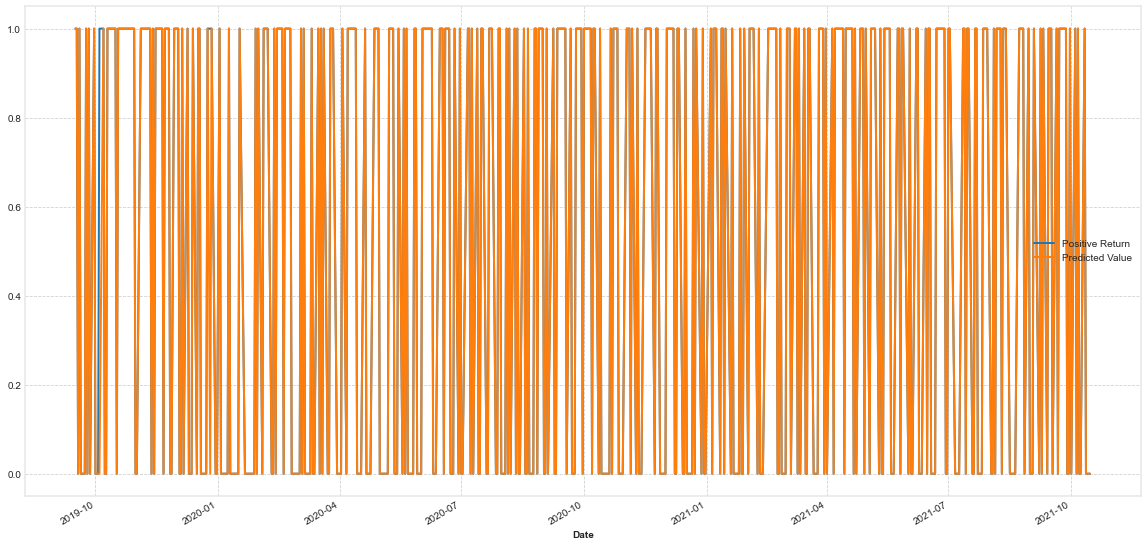

In [59]:
# Plot predicted results vs. actual results
results[["Positive Return", "Predicted Value"]].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

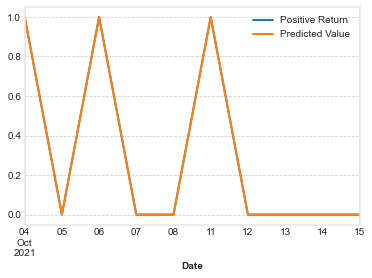

In [60]:
# Plot last 10 records of predicted vs. actual results
results[["Positive Return", "Predicted Value"]].tail(10).plot()

In [61]:
results['Return'] = df_stock['pct_change']
results

Positive Return  Predicted Value    Return
Date                                                  
2019-09-16              1.0              1.0  0.554977
2019-09-17              1.0              1.0  0.122657
2019-09-18              0.0              0.0 -0.449171
2019-09-19              1.0              1.0  0.348646
2019-09-20              0.0              0.0 -0.040863
...                     ...              ...       ...
2021-10-11              1.0              1.0  0.502516
2021-10-12              0.0              0.0 -1.500003
2021-10-13              0.0              0.0 -1.332482
2021-10-14              0.0              0.0 -1.286178
2021-10-15              0.0              0.0 -1.606944

[527 rows x 3 columns]

<AxesSubplot:xlabel='Date'>

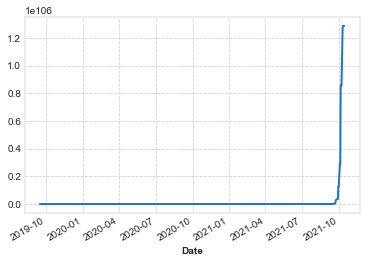

In [62]:
# Calculate cumulative return of the model
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

<AxesSubplot:xlabel='Date'>

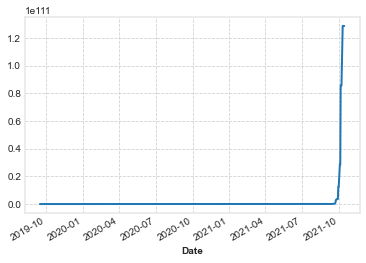

In [63]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

#Hourly Analysis

In [116]:
stock_df_hr = stock.history(period="3mo", interval='1h')
stock_df_hr.index.duplicated().sum()
df_stock_hr = stock_df_hr.loc[~stock_df_hr.index.duplicated(keep='first')]
df_stock_hr.tail()

Open       High        Low      Close  \
2021-10-15 11:30:00-04:00  47.865002  48.490002  47.865002  48.160000   
2021-10-15 12:30:00-04:00  48.160000  48.385201  48.000000  48.241001   
2021-10-15 13:30:00-04:00  48.244999  48.615002  48.189999  48.584999   
2021-10-15 14:30:00-04:00  48.590000  48.740002  48.349998  48.695000   
2021-10-15 15:30:00-04:00  48.690399  48.709999  48.259998  48.369999   

                            Volume  Dividends  Stock Splits  
2021-10-15 11:30:00-04:00  8523662        0.0             0  
2021-10-15 12:30:00-04:00  4423012        0.0             0  
2021-10-15 13:30:00-04:00  5184090        0.0             0  
2021-10-15 14:30:00-04:00  5657544        0.0             0  
2021-10-15 15:30:00-04:00  8126230        0.0             0

In [117]:
# calculate Bollinger Bands which are the measure of the standard deviation.  These bands are set at the 2 times standard deviation
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg_hr = df_stock_hr['Close'].ewm(span=length).mean()
df_stock_hr['Moving average hourly'] = m_avg_hr
# standard deviation
m_std_hr = df_stock_hr['Close'].rolling(window=length).std()
# upper Bollinger Bands
df_stock_hr['upper_BB'] = m_avg_hr + mult * m_std_hr
# lower Bollinger Bands 
df_stock_hr['lower_BB'] = m_avg_hr - mult * m_std_hr

In [118]:
#Stacked Moving averages hourly, again, Fibonacci style moving averages
m_avg_08_hr = df_stock_hr['Close'].ewm(span=8).mean()
m_avg_21_hr = df_stock_hr['Close'].ewm(span=21).mean()
m_avg_34_hr = df_stock_hr['Close'].ewm(span=34).mean()
m_avg_55_hr = df_stock_hr['Close'].ewm(span=55).mean()
m_avg_89_hr = df_stock_hr['Close'].ewm(span=89).mean()

df_stock_hr['m_avg_08'] = m_avg_08_hr
df_stock_hr['m_avg_21'] = m_avg_21_hr
df_stock_hr['m_avg_34'] = m_avg_34_hr
df_stock_hr['m_avg_55'] = m_avg_55_hr
df_stock_hr['m_avg_89'] = m_avg_89_hr

In [119]:
# calculate Keltner Channel hourly
# first we need to calculate True Range
df_stock_hr['tr0'] = abs(df_stock_hr["High"] - df_stock_hr["Low"])
df_stock_hr['tr1'] = abs(df_stock_hr["High"] - df_stock_hr["Close"].shift())
df_stock_hr['tr2'] = abs(df_stock_hr["Low"] - df_stock_hr["Close"].shift())
df_stock_hr['tr'] = df_stock_hr[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma_hr = df_stock_hr['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock_hr['upper_KC'] = m_avg_hr + range_ma_hr * mult_KC
# lower Keltner Channel
df_stock_hr['lower_KC'] = m_avg_hr - range_ma_hr * mult_KC

In [120]:
#ADX Calculations hourly

plus_dm_hr = df_stock_hr["High"].diff()
minus_dm_hr = df_stock_hr["Low"].diff()
plus_dm_hr[plus_dm_hr < 0] = 0
minus_dm_hr[minus_dm_hr > 0] = 0

df_stock_hr['atr'] = df_stock_hr['tr'].ewm(span=14).mean()
df_stock_hr['plus_di'] = 100 * (plus_dm_hr.ewm(alpha = 1/14).mean() / df_stock_hr['atr'])
df_stock_hr['minus_di'] = abs(100 * (minus_dm_hr.ewm(alpha = 1/14).mean() / df_stock_hr['atr']))
dx_hr = (abs(df_stock_hr['plus_di'] - df_stock_hr['minus_di']) / abs(df_stock_hr['plus_di'] + df_stock_hr['minus_di'])) * 100
adx_hr = ((dx_hr.shift(1) * (14 - 1)) + dx_hr) / 14
df_stock_hr['adx'] = adx_hr.ewm(alpha = 1/14).mean()

In [121]:
# check for 'squeeze' hourly
df_stock_hr['squeeze_on'] = (df_stock_hr['lower_BB'] > df_stock_hr['lower_KC']) & (df_stock_hr['upper_BB'] < df_stock_hr['upper_KC'])
df_stock_hr['squeeze_off'] = (df_stock_hr['lower_BB'] < df_stock_hr['lower_KC']) & (df_stock_hr['upper_BB'] > df_stock_hr['upper_KC'])

In [122]:
# Momentum hourly for the squeeze indicator
highest_hr = df_stock_hr['High'].rolling(window = length_KC).max()
lowest_hr = df_stock_hr['Low'].rolling(window = length_KC).min()
m1_hr = (highest_hr + lowest_hr) / 2
df_stock_hr['value'] = (df_stock_hr['Close'] - (m1_hr + m_avg_hr)/2)
fit_y_hr = np.array(range(0,length_KC))
df_stock_hr['value'] = df_stock_hr['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_hr, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y_hr, x, 1)[1], raw=True)

df_stock_hr[['squeeze_on', 'squeeze_off']] = (df_stock_hr[['squeeze_on', 'squeeze_off']] == True).astype(int)

df_stock_hr["pct_change"] = df_stock_hr['Close'].pct_change()

"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions_hr =  [
    (df_stock_hr['pct_change'] > 0),
    (df_stock_hr['pct_change'] < 0)
]

label = [1, 0]
df_stock_hr['profitable?'] = np.select(conditions_hr, label) 
df_stock_hr.dropna(inplace=True)
df_stock_hr.tail()

Open       High        Low      Close  \
2021-10-15 11:30:00-04:00  47.865002  48.490002  47.865002  48.160000   
2021-10-15 12:30:00-04:00  48.160000  48.385201  48.000000  48.241001   
2021-10-15 13:30:00-04:00  48.244999  48.615002  48.189999  48.584999   
2021-10-15 14:30:00-04:00  48.590000  48.740002  48.349998  48.695000   
2021-10-15 15:30:00-04:00  48.690399  48.709999  48.259998  48.369999   

                            Volume  Dividends  Stock Splits  \
2021-10-15 11:30:00-04:00  8523662        0.0             0   
2021-10-15 12:30:00-04:00  4423012        0.0             0   
2021-10-15 13:30:00-04:00  5184090        0.0             0   
2021-10-15 14:30:00-04:00  5657544        0.0             0   
2021-10-15 15:30:00-04:00  8126230        0.0             0   

                           Moving average hourly   upper_BB   lower_BB  \
2021-10-15 11:30:00-04:00              46.448844  48.226188  44.671499   
2021-10-15 12:30:00-04:00              46.619525  48.627470  44.611581   
2021-10-15 13:30:00-04:00              46.806713  49.078797  44.534630   
2021-10-15 14:30:00-04:00              46.986550  49.500502  44.472599   
2021-10-15 15:30:00-04:00              47.118307  49.747227  44.489388   

                            m_avg_08   m_avg_21   m_avg_34   m_avg_55  \
2021-10-15 11:30:00-04:00  46.727141  46.457114  46.616217  46.803795   
2021-10-15 12:30:00-04:00  47.063555  46.619286  46.709062  46.855124   
2021-10-15 13:30:00-04:00  47.401653  46.797987  46.816258  46.916905   
2021-10-15 14:30:00-04:00  47.689064  46.970443  46.923615  46.980409   
2021-10-15 15:30:00-04:00  47.840383  47.097675  47.006265  47.030037   

                            m_avg_89       tr0       tr1       tr2        tr  \
2021-10-15 11:30:00-04:00  46.895219  0.625000  0.625000  0.000000  0.625000   
2021-10-15 12:30:00-04:00  46.925126  0.385201  0.225201  0.160000  0.385201   
2021-10-15 13:30:00-04:00  46.962014  0.425003  0.374001  0.051003  0.425003   
2021-10-15 14:30:00-04:00  47.000526  0.390003  0.155003  0.235001  0.390003   
2021-10-15 15:30:00-04:00  47.030960  0.450001  0.014999  0.435001  0.450001   

                            upper_KC   lower_KC       atr    plus_di  \
2021-10-15 11:30:00-04:00  47.803231  45.094457  0.747293  35.202083   
2021-10-15 12:30:00-04:00  47.920823  45.318228  0.699014  34.945297   
2021-10-15 13:30:00-04:00  48.066984  45.546443  0.662479  36.716451   
2021-10-15 14:30:00-04:00  48.203161  45.769940  0.626149  37.497975   
2021-10-15 15:30:00-04:00  48.306135  45.930480  0.602663  36.176506   

                            minus_di        adx  squeeze_on  squeeze_off  \
2021-10-15 11:30:00-04:00  19.488949  33.407131           0            1   
2021-10-15 12:30:00-04:00  19.346784  33.073102           0            1   
2021-10-15 13:30:00-04:00  18.955609  32.779116           0            1   
2021-10-15 14:30:00-04:00  18.622912  32.725337           0            1   
2021-10-15 15:30:00-04:00  19.033317  32.776987           0            1   

                              value  pct_change  profitable?  
2021-10-15 11:30:00-04:00  0.292246    0.006163            1  
2021-10-15 12:30:00-04:00  0.647673    0.001682            1  
2021-10-15 13:30:00-04:00  1.014990    0.007131            1  
2021-10-15 14:30:00-04:00  1.349243    0.002264            1  
2021-10-15 15:30:00-04:00  1.584619   -0.006674            0

In [123]:
# entry point for long position on the hourly chart:
# 1. black cross becomes gray (the squeeze is released)
long_cond1_hr = (df_stock_hr['squeeze_off'][-2] == 0) | (df_stock_hr['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2_hr = df_stock_hr['value'][-1] > 0

enter_long_hr = long_cond1_hr and long_cond2_hr
# entry point for short position on the hourly chart:
# 1. black cross becomes gray (the squeeze is released)
short_cond1_hr = (df_stock_hr['squeeze_off'][-2] == 0) | (df_stock_hr['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2_hr = df_stock_hr['value'][-1] < 0
enter_short_hr = short_cond1_hr and short_cond2_hr

In [124]:
ohcl_hr = df_stock_hr[['Open', 'High', 'Close', 'Low']]
ohcl_hr.head()

Open       High      Close        Low
2021-07-23 14:30:00-04:00  44.500000  44.578400  44.480000  44.419998
2021-07-23 15:30:00-04:00  44.480000  44.599998  44.590099  44.459999
2021-07-26 09:30:00-04:00  44.470001  45.238098  44.904999  44.470001
2021-07-26 10:30:00-04:00  44.910000  45.020000  44.930000  44.575001
2021-07-26 11:30:00-04:00  44.930000  44.985001  44.810001  44.669998

In [125]:
# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df_stock_hr['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock_hr['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock_hr['value'][ind-1]:
      color='red'
  colors.append(color)

df_stock_hr['colors'] = colors
df_stock_hr['ADX_trend'] = 20

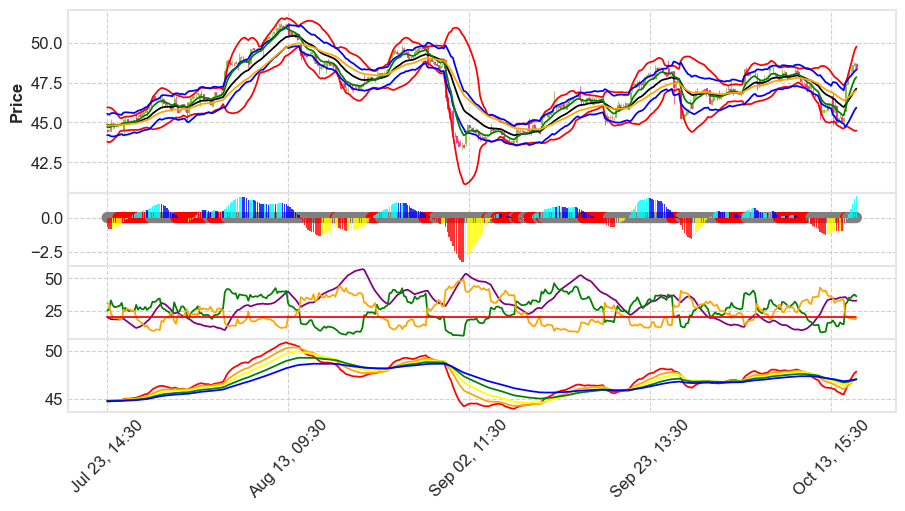

In [126]:
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock_hr['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock_hr), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_hr['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock_hr[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock_hr[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock_hr[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_hr[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_hr['Moving average hourly'], color = 'black'),
        mpf.make_addplot(df_stock_hr['m_avg_08'], color='green'),
        mpf.make_addplot(df_stock_hr['m_avg_34'], color='orange'),
        mpf.make_addplot(df_stock_hr[['adx']], panel=2, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock_hr[['plus_di']], panel=2, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock_hr[['minus_di']], panel=2, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock_hr[['ADX_trend']], panel=2, color = 'red', secondary_y=False),
        mpf.make_addplot(df_stock_hr['m_avg_08'], panel=3, color='red', secondary_y=False),
        mpf.make_addplot(df_stock_hr['m_avg_21'], panel=3, color='orange', secondary_y=False),
        mpf.make_addplot(df_stock_hr['m_avg_34'], panel=3, color='yellow', secondary_y=False),
        mpf.make_addplot(df_stock_hr['m_avg_55'], panel=3, color='green', secondary_y=False),
        mpf.make_addplot(df_stock_hr['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
#Squeeze Panel 1
#ADX panel 2
#Momentum Panel 3
fig, axes = mpf.plot(ohcl_hr, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)

In [127]:
def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    
    Slow stochastics is an oscillating momentum indicator
    It goes up with the stock and down as well
    Right now 70 is considered overbought and 30 is oversold
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()

    return df


stochs_hr = stochastics( df_stock_hr, 'Low', 'High', 'Close', 14, 3 )
slow_k_hr = stochs_hr['k_slow'].values
fast_k_hr = stochs_hr['k_fast'].values
df_stock_hr["slow_K"] = slow_k_hr
df_stock_hr['fast_K'] = fast_k_hr
df_stock_hr.tail()

Open       High        Low      Close  \
2021-10-15 11:30:00-04:00  47.865002  48.490002  47.865002  48.160000   
2021-10-15 12:30:00-04:00  48.160000  48.385201  48.000000  48.241001   
2021-10-15 13:30:00-04:00  48.244999  48.615002  48.189999  48.584999   
2021-10-15 14:30:00-04:00  48.590000  48.740002  48.349998  48.695000   
2021-10-15 15:30:00-04:00  48.690399  48.709999  48.259998  48.369999   

                            Volume  Dividends  Stock Splits  \
2021-10-15 11:30:00-04:00  8523662        0.0             0   
2021-10-15 12:30:00-04:00  4423012        0.0             0   
2021-10-15 13:30:00-04:00  5184090        0.0             0   
2021-10-15 14:30:00-04:00  5657544        0.0             0   
2021-10-15 15:30:00-04:00  8126230        0.0             0   

                           Moving average hourly   upper_BB   lower_BB  \
2021-10-15 11:30:00-04:00              46.448844  48.226188  44.671499   
2021-10-15 12:30:00-04:00              46.619525  48.627470  44.611581   
2021-10-15 13:30:00-04:00              46.806713  49.078797  44.534630   
2021-10-15 14:30:00-04:00              46.986550  49.500502  44.472599   
2021-10-15 15:30:00-04:00              47.118307  49.747227  44.489388   

                            m_avg_08   m_avg_21   m_avg_34   m_avg_55  \
2021-10-15 11:30:00-04:00  46.727141  46.457114  46.616217  46.803795   
2021-10-15 12:30:00-04:00  47.063555  46.619286  46.709062  46.855124   
2021-10-15 13:30:00-04:00  47.401653  46.797987  46.816258  46.916905   
2021-10-15 14:30:00-04:00  47.689064  46.970443  46.923615  46.980409   
2021-10-15 15:30:00-04:00  47.840383  47.097675  47.006265  47.030037   

                            m_avg_89       tr0       tr1       tr2        tr  \
2021-10-15 11:30:00-04:00  46.895219  0.625000  0.625000  0.000000  0.625000   
2021-10-15 12:30:00-04:00  46.925126  0.385201  0.225201  0.160000  0.385201   
2021-10-15 13:30:00-04:00  46.962014  0.425003  0.374001  0.051003  0.425003   
2021-10-15 14:30:00-04:00  47.000526  0.390003  0.155003  0.235001  0.390003   
2021-10-15 15:30:00-04:00  47.030960  0.450001  0.014999  0.435001  0.450001   

                            upper_KC   lower_KC       atr    plus_di  \
2021-10-15 11:30:00-04:00  47.803231  45.094457  0.747293  35.202083   
2021-10-15 12:30:00-04:00  47.920823  45.318228  0.699014  34.945297   
2021-10-15 13:30:00-04:00  48.066984  45.546443  0.662479  36.716451   
2021-10-15 14:30:00-04:00  48.203161  45.769940  0.626149  37.497975   
2021-10-15 15:30:00-04:00  48.306135  45.930480  0.602663  36.176506   

                            minus_di        adx  squeeze_on  squeeze_off  \
2021-10-15 11:30:00-04:00  19.488949  33.407131           0            1   
2021-10-15 12:30:00-04:00  19.346784  33.073102           0            1   
2021-10-15 13:30:00-04:00  18.955609  32.779116           0            1   
2021-10-15 14:30:00-04:00  18.622912  32.725337           0            1   
2021-10-15 15:30:00-04:00  19.033317  32.776987           0            1   

                              value  pct_change  profitable? colors  \
2021-10-15 11:30:00-04:00  0.292246    0.006163            1   cyan   
2021-10-15 12:30:00-04:00  0.647673    0.001682            1   cyan   
2021-10-15 13:30:00-04:00  1.014990    0.007131            1   cyan   
2021-10-15 14:30:00-04:00  1.349243    0.002264            1   cyan   
2021-10-15 15:30:00-04:00  1.584619   -0.006674            0   cyan   

                           ADX_trend     slow_K     fast_K  
2021-10-15 11:30:00-04:00         20  92.576924  90.983556  
2021-10-15 12:30:00-04:00         20  93.612109  93.196706  
2021-10-15 13:30:00-04:00         20  94.462530  99.207329  
2021-10-15 14:30:00-04:00         20  97.084363  98.849054  
2021-10-15 15:30:00-04:00         20  96.197799  90.537014

In [128]:
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl 

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

#RSI stands for Relative strength Indicator
#it is also a momentum oscillation indicator but moves a lot slower than the stochastics
#if the stock goes up the RSI should go up and vice versa
#if it doesn't this indicates a divergence, especially at the higher timeframes
#again 70 is overbought and 30 is oversold
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df_stock_hr['rsi_14'] = get_rsi(df_stock_hr['Close'], 14)
df_stock_hr = df_stock_hr.dropna()
df_stock_hr['Overbought'] = 70
df_stock_hr['Oversold'] = 30
df_stock_hr.tail()

Open       High        Low      Close  \
2021-10-15 11:30:00-04:00  47.865002  48.490002  47.865002  48.160000   
2021-10-15 12:30:00-04:00  48.160000  48.385201  48.000000  48.241001   
2021-10-15 13:30:00-04:00  48.244999  48.615002  48.189999  48.584999   
2021-10-15 14:30:00-04:00  48.590000  48.740002  48.349998  48.695000   
2021-10-15 15:30:00-04:00  48.690399  48.709999  48.259998  48.369999   

                            Volume  Dividends  Stock Splits  \
2021-10-15 11:30:00-04:00  8523662        0.0             0   
2021-10-15 12:30:00-04:00  4423012        0.0             0   
2021-10-15 13:30:00-04:00  5184090        0.0             0   
2021-10-15 14:30:00-04:00  5657544        0.0             0   
2021-10-15 15:30:00-04:00  8126230        0.0             0   

                           Moving average hourly   upper_BB   lower_BB  \
2021-10-15 11:30:00-04:00              46.448844  48.226188  44.671499   
2021-10-15 12:30:00-04:00              46.619525  48.627470  44.611581   
2021-10-15 13:30:00-04:00              46.806713  49.078797  44.534630   
2021-10-15 14:30:00-04:00              46.986550  49.500502  44.472599   
2021-10-15 15:30:00-04:00              47.118307  49.747227  44.489388   

                            m_avg_08   m_avg_21   m_avg_34   m_avg_55  \
2021-10-15 11:30:00-04:00  46.727141  46.457114  46.616217  46.803795   
2021-10-15 12:30:00-04:00  47.063555  46.619286  46.709062  46.855124   
2021-10-15 13:30:00-04:00  47.401653  46.797987  46.816258  46.916905   
2021-10-15 14:30:00-04:00  47.689064  46.970443  46.923615  46.980409   
2021-10-15 15:30:00-04:00  47.840383  47.097675  47.006265  47.030037   

                            m_avg_89       tr0       tr1       tr2        tr  \
2021-10-15 11:30:00-04:00  46.895219  0.625000  0.625000  0.000000  0.625000   
2021-10-15 12:30:00-04:00  46.925126  0.385201  0.225201  0.160000  0.385201   
2021-10-15 13:30:00-04:00  46.962014  0.425003  0.374001  0.051003  0.425003   
2021-10-15 14:30:00-04:00  47.000526  0.390003  0.155003  0.235001  0.390003   
2021-10-15 15:30:00-04:00  47.030960  0.450001  0.014999  0.435001  0.450001   

                            upper_KC   lower_KC       atr    plus_di  \
2021-10-15 11:30:00-04:00  47.803231  45.094457  0.747293  35.202083   
2021-10-15 12:30:00-04:00  47.920823  45.318228  0.699014  34.945297   
2021-10-15 13:30:00-04:00  48.066984  45.546443  0.662479  36.716451   
2021-10-15 14:30:00-04:00  48.203161  45.769940  0.626149  37.497975   
2021-10-15 15:30:00-04:00  48.306135  45.930480  0.602663  36.176506   

                            minus_di        adx  squeeze_on  squeeze_off  \
2021-10-15 11:30:00-04:00  19.488949  33.407131           0            1   
2021-10-15 12:30:00-04:00  19.346784  33.073102           0            1   
2021-10-15 13:30:00-04:00  18.955609  32.779116           0            1   
2021-10-15 14:30:00-04:00  18.622912  32.725337           0            1   
2021-10-15 15:30:00-04:00  19.033317  32.776987           0            1   

                              value  pct_change  profitable? colors  \
2021-10-15 11:30:00-04:00  0.292246    0.006163            1   cyan   
2021-10-15 12:30:00-04:00  0.647673    0.001682            1   cyan   
2021-10-15 13:30:00-04:00  1.014990    0.007131            1   cyan   
2021-10-15 14:30:00-04:00  1.349243    0.002264            1   cyan   
2021-10-15 15:30:00-04:00  1.584619   -0.006674            0   cyan   

                           ADX_trend     slow_K     fast_K     rsi_14  \
2021-10-15 11:30:00-04:00         20  92.576924  90.983556  66.604867   
2021-10-15 12:30:00-04:00         20  93.612109  93.196706  67.145940   
2021-10-15 13:30:00-04:00         20  94.462530  99.207329  69.412490   
2021-10-15 14:30:00-04:00         20  97.084363  98.849054  70.122308   
2021-10-15 15:30:00-04:00         20  96.197799  90.537014  65.300670   

                           Overbought  Oversold  
2021-10-15 11:30:00-04:00          70      

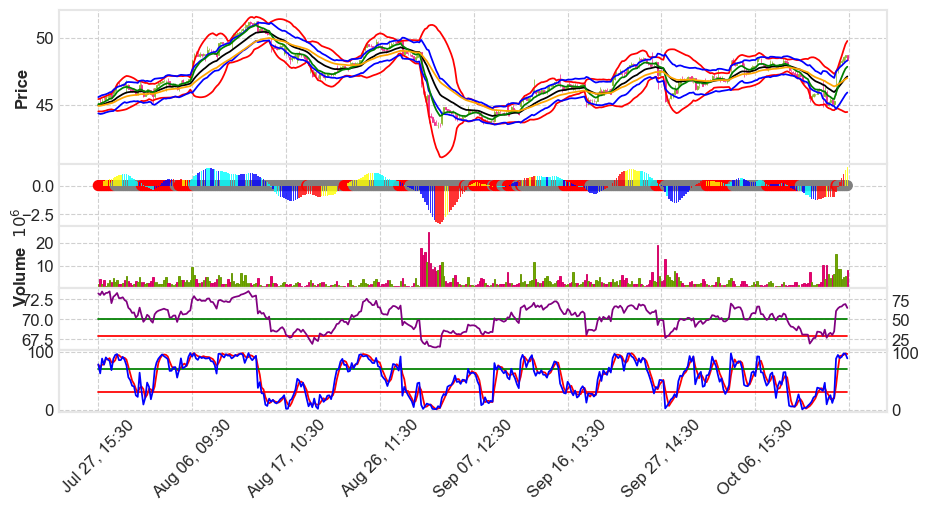

In [129]:
#this plot provides the second set of studies which include the Slow Stochastic and the RSI
apds2 = [mpf.make_addplot(df_stock_hr['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
         mpf.make_addplot([0] * len(df_stock_hr), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_hr['squeeze_off']], secondary_y=False),
         mpf.make_addplot(df_stock_hr[['upper_BB']], color = 'red'),
         mpf.make_addplot(df_stock_hr[['lower_BB']], color = 'red'),
         mpf.make_addplot(df_stock_hr[['upper_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_hr[['lower_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_hr['Moving average hourly'], color = 'black'),
         mpf.make_addplot(df_stock_hr['m_avg_08'], color = 'green'),
         mpf.make_addplot(df_stock_hr['m_avg_34'], color = 'orange'),
         mpf.make_addplot(df_stock_hr['slow_K'], panel=4, color = 'red'),
         mpf.make_addplot(df_stock_hr['fast_K'], panel=4, color = 'blue'),
         mpf.make_addplot(df_stock_hr['Overbought'], panel=4, color = 'green'),
         mpf.make_addplot(df_stock_hr['Oversold'], panel=4, color = 'red'),
         mpf.make_addplot(df_stock_hr['Overbought'], panel=3, color = 'green'),
         mpf.make_addplot(df_stock_hr['Oversold'], panel=3, color = 'red'),
         mpf.make_addplot(df_stock_hr['rsi_14'], panel=3, color='purple')]
# Plot ohcl with subplots
#Panel 1 is the squeeze
#Panel 2 is the Slow Stochastics
#Panel 3 is the RSI
fig, axes = mpf.plot(df_stock_hr, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              volume=True,
              returnfig=True)

In [130]:
#This code takes a group of 2 to 3 candles and tells the trader if the swing over the next day to few days will be bullish, bearish, or no pattern
for i in range(2,df_stock_hr.shape[0]):
    current_hr = df_stock_hr.iloc[i,:]
    prev_hr = df_stock_hr.iloc[i-1,:]
    prev_2_hr = df_stock_hr.iloc[i-2,:]
    realbody_hr = abs(current_hr['Open'] - current_hr['Close'])
    candle_range_hr = current_hr['High'] - current_hr['Low']
    idx_hr = df_stock_hr.index[i]  
# Bullish swing
    df_stock_hr.loc[idx_hr,'Bullish swing'] = current_hr['Low'] > prev_hr['Low'] and prev_hr['Low'] < prev_2_hr['Low']
# Bearish swing
    df_stock_hr.loc[idx_hr,'Bearish swing'] = current_hr['High'] < prev_hr['High'] and prev_hr['High'] > prev_2_hr['High']
# Bullish pinbar
    df_stock_hr.loc[idx_hr,'Bullish pinbar'] = realbody_hr <= candle_range_hr/3 and  min(current_hr['Open'], current_hr['Close']) > (current_hr['High'] + current_hr['Low'])/2 and current_hr['Low'] < prev_hr['Low']
# Bearish pinbar
    df_stock_hr.loc[idx_hr,'Bearish pinbar'] = realbody_hr <= candle_range_hr/3 and max(current_hr['Open'] , current_hr['Close']) < (current_hr['High'] + current_hr['Low'])/2 and current_hr['High'] > prev_hr['High']
    
  # Inside bar
    df_stock_hr.loc[idx_hr,'Inside bar'] = current_hr['High'] < prev_hr['High'] and current_hr['Low'] > prev_hr['Low']
    
  # Outside bar
    df_stock_hr.loc[idx_hr,'Outside bar'] = current_hr['High'] > prev_hr['High'] and current_hr['Low'] < prev_hr['Low']
  
  # Bullish engulfing
    df_stock_hr.loc[idx_hr,'Bullish engulfing'] = current_hr['High'] > prev_hr['High'] and current_hr['Low'] < prev_hr['Low'] and realbody_hr >= 0.8 * candle_range_hr and current_hr['Close'] > current_hr['Open']
# Bearish engulfing
    df_stock_hr.loc[idx_hr,'Bearish engulfing'] = current_hr['High'] > prev_hr['High'] and current_hr['Low'] < prev_hr['Low'] and realbody_hr >= 0.8 * candle_range_hr and current_hr['Close'] < current_hr['Open']

df_stock_hr.fillna(False, inplace=True)

In [131]:
columns = ['Bullish swing', 'Bearish swing', 'Bullish pinbar', 'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing','Bearish engulfing']
#The creation of this column using this function is to use this for a graph or to get you the latest pattern

def convert(df):
    patterns = []
    for i in columns:
        if df[i]:
            patterns.append(i)
    #df['patterns'] = patterns
    if not patterns:
        patterns.append('No pattern')
    return patterns

#df_stock_dow.apply(convert, axis=1)
df_stock_hr['pattern'] = df_stock_hr.apply(convert, axis = 1)

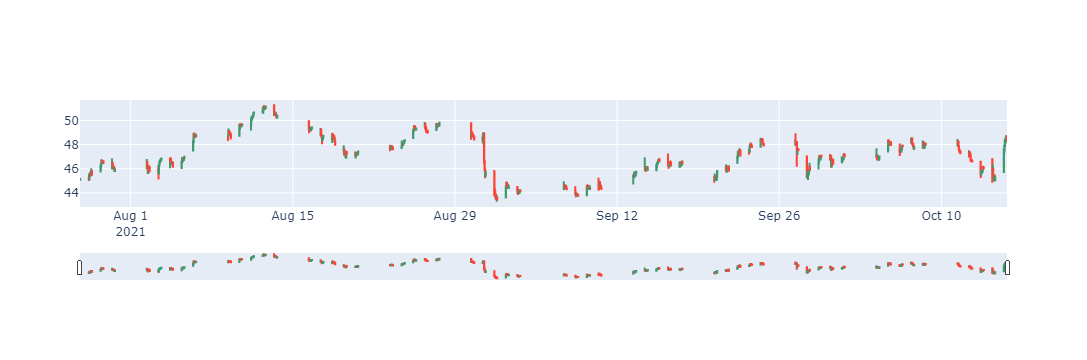

In [132]:
#This graph will give you the candlestick pattern.  When you hover over the candles, you will see the pattern at the time at which you hover the cursor
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df_stock_hr.index,
                open=df_stock_hr['Open'],
                high=df_stock_hr['High'],
                low=df_stock_hr['Low'],
                close=df_stock_hr['Close'])])
fig.update_traces(text=df_stock_hr['pattern'], selector=dict(type='candlestick'))
fig.show()

In [133]:
#Dictionary of patterns with definitions
pattern_dict = {
    'Bullish swing': 'upswing pattern',
    'Bearish swing': 'downward pattern',
    'Bullish pinbar': 'upswing hammer',
    'Bearish pinbar': 'downswing hammer',
    'Inside bar': 'trend change',
    'Outside bar': 'trend change',
    'Bullish engulfing': 'upswing from downtrend',
    'Bearish engulfing': 'downswing from uptrend',
    'No pattern': 'No pattern detected'
    }
#This will give the most current pattern from the dataframe
today = df_stock_hr['pattern'][-1]
for i in today:
    print(f'Todays pattern is {i}, {pattern_dict[i]}')

Todays pattern is Bearish swing, downward pattern


In [134]:
#checks the momentum based on the EMA's stacking
#If smaller EMA's stack above the larger, the momentum is positive, vice versa, negative
def momentum_checker_hr(index):
    if (df_stock_hr['m_avg_08'][index] > df_stock_hr['m_avg_21'][index] > df_stock_hr['m_avg_34'][index] > df_stock_hr['m_avg_55'][index] > df_stock_hr['m_avg_89'][index]):
        return 'Positive momentum'
    elif (df_stock_hr['m_avg_08'][index] < df_stock_hr['m_avg_21'][index] < df_stock_hr['m_avg_34'][index] < df_stock_hr['m_avg_55'][index] < df_stock_hr['m_avg_89'][index]):
        return 'Negative momentum'
    else:
        return 'neutral'

In [135]:
#This code throws up a flag to show if the trend of the stock is up, down, or sideways
#It uses the average directional index to determine the strength of the trend
#If ADX > 20 and the plus_di is above the minus_di the trend is positive
#If ADX > 20 and the plus_di is below the minus_di the trend is negative
#If ADX < 20 the trend is sideways

df_stock_hr['ADX_trend'] = 20

def ADX_trend_flag_hr(index):
    if (df_stock_hr['adx'][index] > df_stock_hr['ADX_trend'][index]) and (df_stock_hr['plus_di'][index] > df_stock_hr['minus_di'][index]):
        return 'positive trend'
    elif (df_stock_hr['adx'][index] > df_stock_hr['ADX_trend'][index]) and (df_stock_hr['plus_di'][index] < df_stock_hr['minus_di'][index]):
        return 'negative trend'
    elif (df_stock_hr['adx'][index] < df_stock_hr['ADX_trend'][index]):
        return 'neutral or sideways trend'

In [136]:
#This code gives an early warning if the 8 EMA crosses the 21 to the downside and amplifies the warning if it crosses the 34
#This is especially critical if it is happening to one of the market indices
def warning_hr(index):
    if (df_stock_hr['m_avg_08'][index] < df_stock_hr['m_avg_21'][index]):
        return 'Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34. Trends on the hourly may be short-lived'
    if (df_stock_hr['m_avg_08'][index] < df_stock_hr['m_avg_34'][index]):
        return '8 EMA has crossed 34 to the downside.  As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema.  Trends on the hourly may be short lived, so do not make long term decision based on it.  It can be used as a bearish entry if the daily also shows bearishness.'
    elif (df_stock_hr['m_avg_08'][index] > df_stock_hr['m_avg_21'][index]):
        return 'Continue as normal and watch for bearish candle patterns on the daily, especially when market is overbought and at the top bollinger'

In [137]:
#Warning flag to show if the squeeze is on and what market cycle the stock or index is in
def squeeze_flag_hr(index):
    if (df_stock_hr['squeeze_on'][index] == 1.0):
        return 'squeeze is on'
    else:
        return 'squeeze is off'
    
def squeeze_momentum_hr(index):    
    if (df_stock_hr['colors'][index] == 'cyan'):
        return 'stock is in a mark up mode'
    elif (df_stock_hr['colors'][index] == 'blue'):
        return 'stock is in a distribution mode'
    elif (df_stock_hr['colors'][index] == 'yellow'):
        return 'stock is in an accumulation mode'
    elif (df_stock_hr['colors'][index] == 'red'):
        return 'stock is in a mark down mode'

In [138]:
momentum_checker_hr(-1)

'neutral'

In [139]:
ADX_trend_flag_hr(-1)

'positive trend'

In [140]:
warning_hr(-1)

'Continue as normal and watch for bearish candle patterns on the daily, especially when market is overbought and at the top bollinger'

In [141]:
squeeze_flag_hr(-1)

'squeeze is off'

In [142]:
squeeze_momentum_hr(-1)

'stock is in a mark up mode'

In [143]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
# The threshold is to set the histogram of the squeeze as close to the zero line as possible
# We want the squeeze to be on and the histogram to be close to zero and the color of the histogram to be yellow or cyan indicating accumulation
# or markup
t_percent_hr = float(input("enter threshold percentage"))
df_stock_hr['value_threshold'] = abs(df_stock_hr['value'].min()* t_percent_hr)
df_stock_hr['squeeze_threshold'] = 1.0
df_stock_hr["squeeze_entry"] = np.logical_and(np.greater(df_stock_hr["value"], df_stock_hr['value_threshold']), 
                                           np.equal(df_stock_hr['squeeze_on'], df_stock_hr['squeeze_threshold']))
df_stock_hr['squeeze_entry'] = df_stock_hr['squeeze_entry'].astype(float)
df_stock_hr['Entry/Exit'] = df_stock_hr['squeeze_entry'].diff()
df_stock_hr_clean = df_stock_hr.dropna()

enter threshold percentage .05


In [144]:
#This is the algo strategy.  The entry is when the squeeze is on and the histogram is near 0 and either yellow or cyan as stated before
#Exit strategy is when the stock moves up any percent you want to input
#The form of input is 1.something
#this means for example 1.5 means 50%

percent = float(input("Enter percent return"))
def implement_bb_strategy(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal

Enter percent return 1.01


In [145]:
#calling the algo function and returning the buy price, sell price, and the squeeze signal
buy_price_hr, sell_price_hr, squeeze_signal_hr = implement_bb_strategy(df_stock_hr["Close"], df_stock_hr['squeeze_on'], df_stock_hr['value'], 
                                                              df_stock_hr['upper_KC'], df_stock_hr['value_threshold'], df_stock_hr['colors'], percent)

In [146]:
#setting dataframes to the results of the algo function
df_stock_hr['buy_price'] =  buy_price_hr
df_stock_hr['sell_price'] = sell_price_hr
df_stock_hr['squeeze_signal'] = squeeze_signal_hr

In [147]:
# This is give the entry and exit signals in the form of a green triangle and red triangle respectively
# Visualize exit position relative to close price
exit = df_stock_hr[df_stock_hr['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock_hr[df_stock_hr['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock_hr[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [index]   (Close)
   .Scatter.Close.I  :Scatter   [index]   (Close)
   .Scatter.Close.II :Scatter   [index]   (Close)

In [151]:
# This code tells us to enter into a position when the squeeze signal is triggered according to the algo function given above
position = []
for i in range(len(squeeze_signal_hr)):
    if df_stock_hr['squeeze_signal'][i] < 1:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock_hr['Close'])):
    if df_stock_hr['squeeze_signal'][i] == 1:
        position[i] = 1
    elif df_stock_hr['squeeze_signal'][i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock_hr['Close']
squeeze_signal_hr = pd.DataFrame(squeeze_signal_hr).rename(columns = {0:'squeeze_signal'}).set_index(df_stock_hr.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock_hr.index)

frames = [close_price, squeeze_signal_hr, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy.tail()

index      Close  squeeze_signal  squeeze_position
395 2021-10-15 11:30:00-04:00  48.160000             0.0                 1
396 2021-10-15 12:30:00-04:00  48.241001             0.0                 1
397 2021-10-15 13:30:00-04:00  48.584999            -1.0                 0
398 2021-10-15 14:30:00-04:00  48.695000             0.0                 0
399 2021-10-15 15:30:00-04:00  48.369999             0.0                 0

In [152]:
#This code gives us the results of the Algo trade compounding the % return and starting with 100000 as the initial investment and telling 

stock_ret = pd.DataFrame(np.diff(df_stock_hr['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock_hr['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock_hr['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)

Profit gained from the Squeeze strategy by investing $100k in wfc is 10007.09
Profit percentage of the Squeeze strategy : 10%
10007.094814300537


In [ ]:
#This is the volume profile in which you get the volume activity at each price.  This highest volume activity at a certain price can make that price
#a good bounce off point
px.histogram(df_stock_hr, x='Volume', y='Close', nbins=150, orientation='h').show()

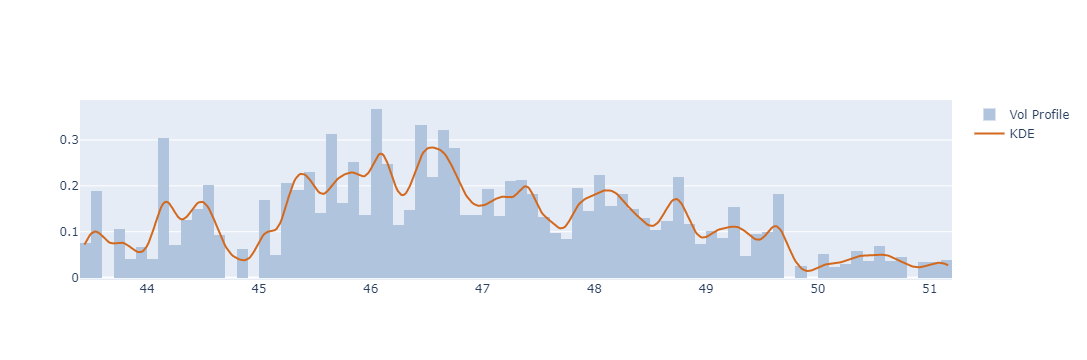

In [153]:
#This makes the volume profile graphs vertical and shows at which price the peak volumes are
kde_factor = 0.05
num_samples = 500
close = df_stock_hr['Close']
volume = df_stock_hr['Volume']
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

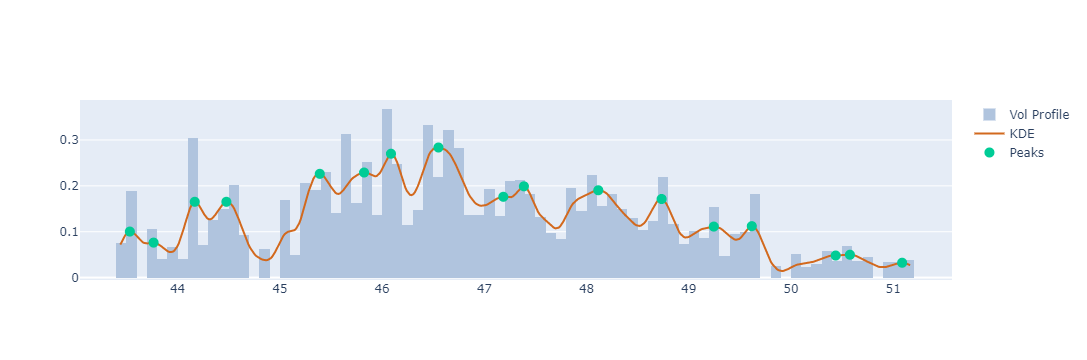

In [154]:
#This adds a green dot to show you
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
rgs=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

#Weekly Analysis

In [155]:
#This block of code pulls the weekly candlestick periods from Yahoo Finance and makes it into a dataframe
stock_df_wk = stock.history(period="20y", interval='1wk')
stock_df.index.duplicated().sum()
df_stock_wk = stock_df_wk.loc[~stock_df_wk.index.duplicated(keep='first')]
df_stock_wk.dropna(inplace=True)
df_stock_wk.tail()

Open       High        Low      Close       Volume  \
Date                                                                  
2021-09-20  45.029999  48.570000  44.840000  47.919998  125320400.0   
2021-09-27  48.380001  48.939999  45.070000  47.020000  160952400.0   
2021-10-04  47.020000  48.590000  46.669998  48.000000   93548100.0   
2021-10-11  48.200001  48.740002  44.830002  48.380001  171865000.0   
2021-10-15  45.720001  48.740002  45.709999  48.380001   58942594.0   

            Dividends  Stock Splits  
Date                                 
2021-09-20        0.0           0.0  
2021-09-27        0.0           0.0  
2021-10-04        0.0           0.0  
2021-10-11        0.0           0.0  
2021-10-15        0.0           0.0

In [156]:
# calculate Bollinger Bands on weekly data
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg_wk = df_stock_wk['Close'].ewm(span=length).mean()
df_stock_wk['Moving average weekly'] = m_avg_wk
# standard deviation
m_std_wk = df_stock_wk['Close'].rolling(window=length).std(ddof=0)
# upper Bollinger Bands
df_stock_wk['upper_BB'] = m_avg_wk + mult * m_std_wk
# lower Bollinger Bands 
df_stock_wk['lower_BB'] = m_avg_wk - mult * m_std_wk

In [157]:
#Stacked Moving averages weekly, again, Fibonacci style moving averages
m_avg_08_wk = df_stock_wk['Close'].ewm(span=8).mean()
m_avg_21_wk = df_stock_wk['Close'].ewm(span=21).mean()
m_avg_34_wk = df_stock_wk['Close'].ewm(span=34).mean()
m_avg_55_wk = df_stock_wk['Close'].ewm(span=55).mean()
m_avg_89_wk = df_stock_wk['Close'].ewm(span=89).mean()

df_stock_wk['m_avg_08'] = m_avg_08_wk
df_stock_wk['m_avg_21'] = m_avg_21_wk
df_stock_wk['m_avg_34'] = m_avg_34_wk
df_stock_wk['m_avg_55'] = m_avg_55_wk
df_stock_wk['m_avg_89'] = m_avg_89_wk

In [158]:
# calculate Keltner Channel weekly
# first we need to calculate True Range
df_stock_wk['tr0'] = abs(df_stock_wk["High"] - df_stock_wk["Low"])
df_stock_wk['tr1'] = abs(df_stock_wk["High"] - df_stock_wk["Close"].shift())
df_stock_wk['tr2'] = abs(df_stock_wk["Low"] - df_stock_wk["Close"].shift())
df_stock_wk['tr'] = df_stock_wk[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma_wk = df_stock_wk['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock_wk['upper_KC'] = m_avg_wk + range_ma_wk * mult_KC
# lower Keltner Channel
df_stock_wk['lower_KC'] = m_avg_wk - range_ma_wk * mult_KC

In [159]:
#ADX Calculations weekly

plus_dm_wk = df_stock_wk["High"].diff()
minus_dm_wk = df_stock_wk["Low"].diff()
plus_dm_wk[plus_dm_wk < 0] = 0
minus_dm_wk[minus_dm_wk > 0] = 0

df_stock_wk['atr'] = df_stock_wk['tr'].ewm(span=14).mean()
df_stock_wk['plus_di'] = 100 * (plus_dm_wk.ewm(alpha = 1/14).mean() / df_stock_wk['atr'])
df_stock_wk['minus_di'] = abs(100 * (minus_dm_wk.ewm(alpha = 1/14).mean() / df_stock_wk['atr']))
dx_wk = (abs(df_stock_wk['plus_di'] - df_stock_wk['minus_di']) / abs(df_stock_wk['plus_di'] + df_stock_wk['minus_di'])) * 100
adx_wk = ((dx_wk.shift(1) * (14 - 1)) + dx_wk) / 14
df_stock_wk['adx'] = adx_wk.ewm(alpha = 1/14).mean()

In [160]:
# check for 'squeeze' weekly
df_stock_wk['squeeze_on'] = (df_stock_wk['lower_BB'] > df_stock_wk['lower_KC']) & (df_stock_wk['upper_BB'] < df_stock_wk['upper_KC'])
df_stock_wk['squeeze_off'] = (df_stock_wk['lower_BB'] < df_stock_wk['lower_KC']) & (df_stock_wk['upper_BB'] > df_stock_wk['upper_KC'])

In [161]:
# Momentum weekly for the squeeze indicator
highest_wk = df_stock_wk['High'].rolling(window = length_KC).max()
lowest_wk = df_stock_wk['Low'].rolling(window = length_KC).min()
m1_wk = (highest_wk + lowest_wk) / 2
df_stock_wk['value'] = (df_stock_wk['Close'] - (m1_wk + m_avg_wk)/2)
fit_y_wk = np.array(range(0,length_KC))
df_stock_wk['value'] = df_stock_wk['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_wk, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y_wk, x, 1)[1], raw=True)

df_stock_wk[['squeeze_on', 'squeeze_off']] = (df_stock_wk[['squeeze_on', 'squeeze_off']] == True).astype(int)

df_stock_wk["pct_change"] = df_stock_wk['Close'].pct_change()

"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions_wk =  [
    (df_stock_wk['pct_change'] > 0),
    (df_stock_wk['pct_change'] < 0)
]

label = [1, 0]
df_stock_wk['profitable?'] = np.select(conditions_wk, label) 
df_stock_wk.dropna(inplace=True)
df_stock_wk

Open       High        Low      Close       Volume  \
Date                                                                  
2002-07-22  12.872152  13.815146  12.004367  13.797791   90557400.0   
2002-07-29  14.087051  14.723427  13.959775  14.147796   57237200.0   
2002-08-05  14.220110  15.024257  13.829607  14.983761   68222600.0   
2002-08-12  14.720789  15.171723  14.488049  14.953529   48828800.0   
2002-08-19  14.997163  15.343364  14.842973  15.023346   40693000.0   
...               ...        ...        ...        ...          ...   
2021-09-20  45.029999  48.570000  44.840000  47.919998  125320400.0   
2021-09-27  48.380001  48.939999  45.070000  47.020000  160952400.0   
2021-10-04  47.020000  48.590000  46.669998  48.000000   93548100.0   
2021-10-11  48.200001  48.740002  44.830002  48.380001  171865000.0   
2021-10-15  45.720001  48.740002  45.709999  48.380001   58942594.0   

            Dividends  Stock Splits  Moving average weekly   upper_BB  \
Date                                                                    
2002-07-22        0.0           0.0              14.177790  15.206581   
2002-07-29        0.0           0.0              14.174890  15.212431   
2002-08-05        0.0           0.0              14.252981  15.311906   
2002-08-12        0.0           0.0              14.320526  15.390640   
2002-08-19        0.0           0.0              14.388210  15.460312   
...               ...           ...                    ...        ...   
2021-09-20        0.0           0.0              45.205739  49.362535   
2021-09-27        0.0           0.0              45.378526  49.545972   
2021-10-04        0.0           0.0              45.628190  49.875977   
2021-10-11        0.0           0.0              45.890267  50.244798   
2021-10-15        0.0           0.0              46.127385  50.575234   

             lower_BB   m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89  \
Date                                                                           
2002-07-22  13.148998  14.076275  14.168200  14.028706  13.873067  13.749049   
2002-07-29  13.137349  14.092169  14.166311  14.036139  13.885599  13.763555   
2002-08-05  13.194056  14.290305  14.241879  14.094975  13.935203  13.807323   
2002-08-12  13.250412  14.437690  14.307566  14.148019  13.980770  13.847884   
2002-08-19  13.316109  14.567838  14.373542  14.201849  14.027005  13.888939   
...               ...        ...        ...        ...        ...        ...   
2021-09-20  41.048943  46.632325  45.035818  42.793926  40.355070  39.130338   
2021-09-27  41.211079  46.718475  45.216198  43.035416  40.593103  39.305664   
2021-10-04  41.380403  47.003258  45.469271  43.319107  40.857635  39.498871   
2021-10-11  41.535737  47.309201  45.733883  43.608301  41.126291  39.696230   
2021-10-15  41.679536  47.547157  45.974439  43.880969  41.385352  39.889203   

                 tr0       tr1       tr2        tr   upper_KC   lower_KC  \
Date                                                                       
2002-07-22  1.810779  0.789688  1.021091  1.810779  15.780998  12.574581   
2002-07-29  0.763652  0.925637  0.161985  0.925637  15.801069  12.548710   
2002-08-05  1.194650  0.876462  0.318189  1.194650  15.949706  12.556256   
2002-08-12  0.683674  0.187962  0.495712  0.683674  15.986849  12.654203   
2002-08-19  0.500391  0.389834  0.110556  0.500391  15.993188  12.783233   
...              ...       ...       ...       ...        ...        ...   
2021-09-20  3.730000  2.099998  1.630001  3.730000  51.532570  38.878908   
2021-09-27  3.869999  1.020000  2.849998  3.869999  51.833827  38.923225   
2021-10-04  1.920002  1.570000  0.350002  1.920002  51.845737  39.410644   
2021-10-11  3.910000  0.740002  3.169998  3.910000  52.253491  39.527043   
2021-10-15  3.030003  0.360001  2.670002  3.030003  52.463043  39.791726   

                 atr    plus_di   minus_di        adx  squeeze_on  \
Date                                        

In [162]:
# entry point for long position on the weekly chart:
# 1. black cross becomes gray (the squeeze is released)
long_cond1_wk = (df_stock_wk['squeeze_off'][-2] == 0) | (df_stock_wk['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2_wk = df_stock_wk['value'][-1] > 0

enter_long_wk = long_cond1_wk and long_cond2_wk
# entry point for short position on the weekly chart:
# 1. black cross becomes gray (the squeeze is released)
short_cond1_wk = (df_stock_wk['squeeze_off'][-2] == 0) | (df_stock_wk['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2_wk = df_stock_wk['value'][-1] < 0
enter_short_wk = short_cond1_wk and short_cond2_wk

In [163]:
ohcl_wk = df_stock_wk[['Open', 'High', 'Close', 'Low']]
ohcl_wk.head()

Open       High      Close        Low
Date                                                  
2002-07-22  12.872152  13.815146  13.797791  12.004367
2002-07-29  14.087051  14.723427  14.147796  13.959775
2002-08-05  14.220110  15.024257  14.983761  13.829607
2002-08-12  14.720789  15.171723  14.953529  14.488049
2002-08-19  14.997163  15.343364  15.023346  14.842973

In [164]:
# add colors for the 'value bar'
colors = []
for ind, val in enumerate(df_stock_wk['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock_wk['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock_wk['value'][ind-1]:
      color='red'
  colors.append(color)

df_stock_wk['colors'] = colors

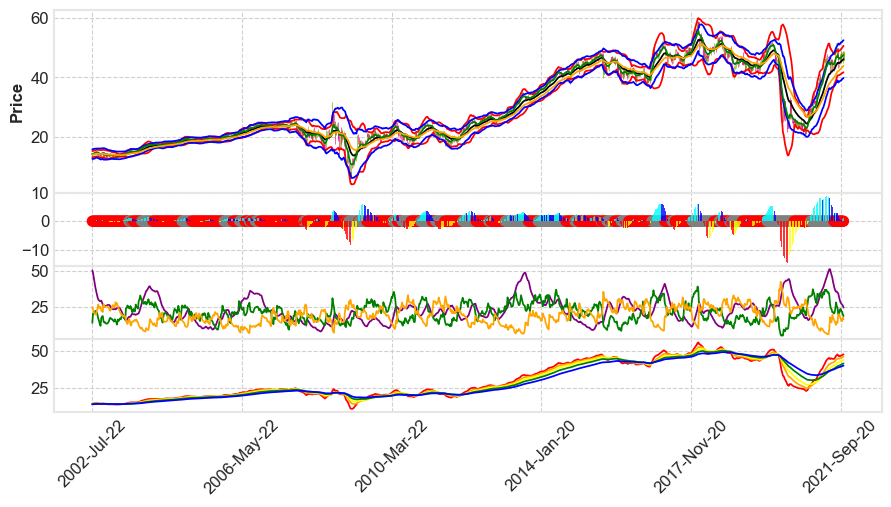

In [165]:
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
        mpf.make_addplot(df_stock_wk['m_avg_08'], color='green'),
        mpf.make_addplot(df_stock_wk['m_avg_34'], color='orange'),
        mpf.make_addplot(df_stock_wk[['adx']], panel=2, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock_wk[['plus_di']], panel=2, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock_wk[['minus_di']], panel=2, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_08'], panel=3, color='red', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_21'], panel=3, color='orange', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_34'], panel=3, color='yellow', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_55'], panel=3, color='green', secondary_y=False),
        mpf.make_addplot(df_stock_wk['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
#Squeeze Panel 1
#ADX panel 2
#Momentum Panel 3
fig, axes = mpf.plot(ohcl_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)

In [166]:
def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    
    This Stochastics is called for the weekly chart
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()

    return df


stochs_wk = stochastics( df_stock_wk, 'Low', 'High', 'Close', 14, 3 )
slow_k_wk = stochs_wk['k_slow'].values
fast_k_wk = stochs_wk['k_fast'].values
df_stock_wk["slow_K"] = slow_k_wk
df_stock_wk['fast_K'] = fast_k_wk
df_stock_wk

Open       High        Low      Close       Volume  \
Date                                                                  
2002-07-22  12.872152  13.815146  12.004367  13.797791   90557400.0   
2002-07-29  14.087051  14.723427  13.959775  14.147796   57237200.0   
2002-08-05  14.220110  15.024257  13.829607  14.983761   68222600.0   
2002-08-12  14.720789  15.171723  14.488049  14.953529   48828800.0   
2002-08-19  14.997163  15.343364  14.842973  15.023346   40693000.0   
...               ...        ...        ...        ...          ...   
2021-09-20  45.029999  48.570000  44.840000  47.919998  125320400.0   
2021-09-27  48.380001  48.939999  45.070000  47.020000  160952400.0   
2021-10-04  47.020000  48.590000  46.669998  48.000000   93548100.0   
2021-10-11  48.200001  48.740002  44.830002  48.380001  171865000.0   
2021-10-15  45.720001  48.740002  45.709999  48.380001   58942594.0   

            Dividends  Stock Splits  Moving average weekly   upper_BB  \
Date                                                                    
2002-07-22        0.0           0.0              14.177790  15.206581   
2002-07-29        0.0           0.0              14.174890  15.212431   
2002-08-05        0.0           0.0              14.252981  15.311906   
2002-08-12        0.0           0.0              14.320526  15.390640   
2002-08-19        0.0           0.0              14.388210  15.460312   
...               ...           ...                    ...        ...   
2021-09-20        0.0           0.0              45.205739  49.362535   
2021-09-27        0.0           0.0              45.378526  49.545972   
2021-10-04        0.0           0.0              45.628190  49.875977   
2021-10-11        0.0           0.0              45.890267  50.244798   
2021-10-15        0.0           0.0              46.127385  50.575234   

             lower_BB   m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89  \
Date                                                                           
2002-07-22  13.148998  14.076275  14.168200  14.028706  13.873067  13.749049   
2002-07-29  13.137349  14.092169  14.166311  14.036139  13.885599  13.763555   
2002-08-05  13.194056  14.290305  14.241879  14.094975  13.935203  13.807323   
2002-08-12  13.250412  14.437690  14.307566  14.148019  13.980770  13.847884   
2002-08-19  13.316109  14.567838  14.373542  14.201849  14.027005  13.888939   
...               ...        ...        ...        ...        ...        ...   
2021-09-20  41.048943  46.632325  45.035818  42.793926  40.355070  39.130338   
2021-09-27  41.211079  46.718475  45.216198  43.035416  40.593103  39.305664   
2021-10-04  41.380403  47.003258  45.469271  43.319107  40.857635  39.498871   
2021-10-11  41.535737  47.309201  45.733883  43.608301  41.126291  39.696230   
2021-10-15  41.679536  47.547157  45.974439  43.880969  41.385352  39.889203   

                 tr0       tr1       tr2        tr   upper_KC   lower_KC  \
Date                                                                       
2002-07-22  1.810779  0.789688  1.021091  1.810779  15.780998  12.574581   
2002-07-29  0.763652  0.925637  0.161985  0.925637  15.801069  12.548710   
2002-08-05  1.194650  0.876462  0.318189  1.194650  15.949706  12.556256   
2002-08-12  0.683674  0.187962  0.495712  0.683674  15.986849  12.654203   
2002-08-19  0.500391  0.389834  0.110556  0.500391  15.993188  12.783233   
...              ...       ...       ...       ...        ...        ...   
2021-09-20  3.730000  2.099998  1.630001  3.730000  51.532570  38.878908   
2021-09-27  3.869999  1.020000  2.849998  3.869999  51.833827  38.923225   
2021-10-04  1.920002  1.570000  0.350002  1.920002  51.845737  39.410644   
2021-10-11  3.910000  0.740002  3.169998  3.910000  52.253491  39.527043   
2021-10-15  3.030003  0.360001  2.670002  3.030003  52.463043  39.791726   

                 atr    plus_di   minus_di        adx  squeeze_on  \
Date                                        

In [167]:
#RSI stands for Relative strength Indicator
#it is also a momentum oscillation indicator but moves a lot slower than the stochastics
#if the stock goes up the RSI should go up and vice versa
#if it doesn't this indicates a divergence, especially at the higher timeframes
#again 70 is overbought and 30 is oversold
#This is for the weekly chart

def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df_stock_wk['rsi_14'] = get_rsi(df_stock_wk['Close'], 14)
df_stock_wk = df_stock_wk.dropna()
df_stock_wk['Overbought'] = 70
df_stock_wk['Oversold'] = 30
df_stock_wk

Open       High        Low      Close       Volume  \
Date                                                                  
2002-11-04  14.924431  14.924431  13.004329  13.225431   65018000.0   
2002-11-11  13.370160  14.101569  13.337977  14.048907   54895400.0   
2002-11-18  14.051823  14.180552  13.516432  13.896765   49520400.0   
2002-11-25  13.899699  14.116196  13.337977  13.519366   36193600.0   
2002-12-02  13.750489  13.806076  13.244354  13.472553   55590600.0   
...               ...        ...        ...        ...          ...   
2021-09-20  45.029999  48.570000  44.840000  47.919998  125320400.0   
2021-09-27  48.380001  48.939999  45.070000  47.020000  160952400.0   
2021-10-04  47.020000  48.590000  46.669998  48.000000   93548100.0   
2021-10-11  48.200001  48.740002  44.830002  48.380001  171865000.0   
2021-10-15  45.720001  48.740002  45.709999  48.380001   58942594.0   

            Dividends  Stock Splits  Moving average weekly   upper_BB  \
Date                                                                    
2002-11-04        0.0           0.0              14.231473  15.576926   
2002-11-11        0.0           0.0              14.214027  15.558594   
2002-11-18        0.0           0.0              14.183721  15.526626   
2002-11-25        0.0           0.0              14.120276  15.491039   
2002-12-02        0.0           0.0              14.058435  15.365877   
...               ...           ...                    ...        ...   
2021-09-20        0.0           0.0              45.205739  49.362535   
2021-09-27        0.0           0.0              45.378526  49.545972   
2021-10-04        0.0           0.0              45.628190  49.875977   
2021-10-11        0.0           0.0              45.890267  50.244798   
2021-10-15        0.0           0.0              46.127385  50.575234   

             lower_BB   m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89  \
Date                                                                           
2002-11-04  12.886019  14.126812  14.231894  14.188680  14.088104  13.983082   
2002-11-11  12.869461  14.109500  14.215186  14.180404  14.086502  13.985108   
2002-11-18  12.840815  14.062225  14.186123  14.163643  14.078790  13.982413   
2002-11-25  12.749512  13.941590  14.125289  14.125647  14.056164  13.968402   
2002-12-02  12.750994  13.837359  14.065754  14.087201  14.032670  13.953518   
...               ...        ...        ...        ...        ...        ...   
2021-09-20  41.048943  46.632325  45.035818  42.793926  40.355070  39.130338   
2021-09-27  41.211079  46.718475  45.216198  43.035416  40.593103  39.305664   
2021-10-04  41.380403  47.003258  45.469271  43.319107  40.857635  39.498871   
2021-10-11  41.535737  47.309201  45.733883  43.608301  41.126291  39.696230   
2021-10-15  41.679536  47.547157  45.974439  43.880969  41.385352  39.889203   

                 tr0       tr1       tr2        tr   upper_KC   lower_KC  \
Date                                                                       
2002-11-04  1.920102  0.180372  1.739729  1.920102  16.180252  12.282694   
2002-11-11  0.763591  0.876137  0.112546  0.876137  16.144864  12.283191   
2002-11-18  0.664119  0.131644  0.532475  0.664119  16.059557  12.307884   
2002-11-25  0.778219  0.219432  0.558788  0.778219  15.966971  12.273581   
2002-12-02  0.561722  0.286709  0.275012  0.561722  15.839163  12.277707   
...              ...       ...       ...       ...        ...        ...   
2021-09-20  3.730000  2.099998  1.630001  3.730000  51.532570  38.878908   
2021-09-27  3.869999  1.020000  2.849998  3.869999  51.833827  38.923225   
2021-10-04  1.920002  1.570000  0.350002  1.920002  51.845737  39.410644   
2021-10-11  3.910000  0.740002  3.169998  3.910000  52.253491  39.527043   
2021-10-15  3.030003  0.360001  2.670002  3.030003  52.463043  39.791726   

                 atr    plus_di   minus_di        adx  squeeze_on  \
Date                                        

In [168]:
%matplotlib widget
#This is the Slow stochastic and RSI graphs for the weekly charts
apds2 = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
         mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
         mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
         mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
         mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
         mpf.make_addplot(df_stock_wk['m_avg_08'], color = 'green'),
         mpf.make_addplot(df_stock_wk['m_avg_34'], color = 'orange'),
         mpf.make_addplot(df_stock_wk['slow_K'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock_wk['fast_K'], panel=2, color = 'blue'),
         mpf.make_addplot(df_stock_wk['Overbought'], panel=2, color = 'green'),
         mpf.make_addplot(df_stock_wk['Oversold'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock_wk['Overbought'], panel=3, color = 'green'),
         mpf.make_addplot(df_stock_wk['Oversold'], panel=3, color = 'red'),
         mpf.make_addplot(df_stock_wk['rsi_14'], panel=3, color='purple')]

# Plot ohcl with subplots
#Panel 1 is the squeeze
#Panel 2 is the Slow Stochastics
#Panel 3 is the RSI
fig, axes = mpf.plot(df_stock_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [169]:
#checks the momentum based on the EMA's stacking
#If smaller EMA's stack above the larger, the momentum is positive, vice versa, negative
def momentum_checker_wk(index):
    if (df_stock_wk['m_avg_08'][index] > df_stock_wk['m_avg_21'][index] > df_stock_wk['m_avg_34'][index] > df_stock_wk['m_avg_55'][index] > df_stock_wk['m_avg_89'][index]):
        return 'Positive momentum'
    elif (df_stock_wk['m_avg_08'][index] < df_stock_wk['m_avg_21'][index] < df_stock_wk['m_avg_34'][index] < df_stock_wk['m_avg_55'][index] < df_stock_wk['m_avg_89'][index]):
        return 'Negative momentum'
    else:
        return 'neutral'

#direction of trend
df_stock_wk['ADX_trend'] = 20

def ADX_trend_flag_wk(index):
    if (df_stock_wk['adx'][index] > df_stock_wk['ADX_trend'][index]) and (df_stock_wk['plus_di'][index] > df_stock_wk['minus_di'][index]):
        return 'positive trend'
    elif (df_stock_wk['adx'][index] > df_stock_wk['ADX_trend'][index]) and (df_stock_wk['plus_di'][index] < df_stock_wk['minus_di'][index]):
        return 'negative trend'
    elif (df_stock_wk['adx'][index] < df_stock_wk['ADX_trend'][index]):
        return 'neutral or sideways trend'

#early warning with the moving averages crossing
def warning_wk(index):
    if (df_stock_wk['m_avg_08'][index] < df_stock_wk['m_avg_21'][index]):
        return 'Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.  This is especially bad with this weekly chart'
    if (df_stock_wk['m_avg_08'][index] < df_stock_wk['m_avg_34'][index]):
        return 'As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema'
    elif (df_stock_wk['m_avg_08'][index] > df_stock_wk['m_avg_21'][index]):
        return 'Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger'
#squeeze cycle warning        
def squeeze_flag_wk(index):
    if (df_stock_wk['squeeze_on'][index] == 1.0):
        return 'squeeze is on'
    else:
        return'squeeze is off'

def squeeze_momentum_wk(index):
    if (df_stock_wk['colors'][index] == 'cyan'):
        return 'stock is in a mark up mode'
    elif (df_stock_wk['colors'][index] == 'blue'):
        return 'stock is in a distribution mode'
    elif (df_stock_wk['colors'][index] == 'yellow'):
        return 'stock is in an accumulation mode'
    elif (df_stock_wk['colors'][index] == 'red'):
        return 'stock is in a mark down mode'

In [170]:
momentum_checker_wk(-1)
ADX_trend_flag_wk(-1)
warning_wk(-1)
squeeze_flag_wk(-1)
squeeze_momentum_wk(-1)

'stock is in a mark up mode'

In [171]:
# To get the entry and exit signals for the algo trading using squeeze and momentum for the weekly chart
t_percent_wk = float(input("enter threshold percentage"))
df_stock_wk['value_threshold'] = abs(df_stock_wk['value'].min()*t_percent_wk)
df_stock_wk['squeeze_threshold'] = 1.0
df_stock_wk["squeeze_entry"] = np.logical_and(np.greater(df_stock_wk["value"], df_stock_wk['value_threshold']), 
                                           np.equal(df_stock_wk['squeeze_on'], df_stock_wk['squeeze_threshold']))
df_stock_wk['squeeze_entry'] = df_stock_wk['squeeze_entry'].astype(float)
df_stock_wk['Entry/Exit'] = df_stock_wk['squeeze_entry'].diff()
df_stock_wk.dropna(inplace=True)

enter threshold percentage .05


In [178]:
#this is the weekly algo trade
#just testing an idea here to be able to enter a percent profit return
#The input is entered in the form of 1.something
#For example 1.5 means a 50% return
percent = float(input('Enter Percent Return'))
def implement_bb_strategy_wk(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False
    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal

Enter Percent Return 1.20


In [179]:
#calls the strategy function
buy_price_wk, sell_price_wk, squeeze_signal_wk = implement_bb_strategy_wk(df_stock_wk["Close"], df_stock_wk['squeeze_on'], df_stock_wk['value'], 
                                                              df_stock_wk['upper_KC'], df_stock_wk['value_threshold'], df_stock_wk['colors'], percent)

In [180]:
#creates the columns and appends to the dataframe
df_stock_wk['buy_price'] =  buy_price_wk
df_stock_wk['sell_price'] = sell_price_wk
df_stock_wk['squeeze_signal'] = squeeze_signal_wk
df_stock_wk

Open       High        Low      Close       Volume  \
Date                                                                  
2002-11-11  13.370160  14.101569  13.337977  14.048907   54895400.0   
2002-11-18  14.051823  14.180552  13.516432  13.896765   49520400.0   
2002-11-25  13.899699  14.116196  13.337977  13.519366   36193600.0   
2002-12-02  13.750489  13.806076  13.244354  13.472553   55590600.0   
2002-12-09  13.434522  13.776822  13.370159  13.457928   43376200.0   
...               ...        ...        ...        ...          ...   
2021-09-20  45.029999  48.570000  44.840000  47.919998  125320400.0   
2021-09-27  48.380001  48.939999  45.070000  47.020000  160952400.0   
2021-10-04  47.020000  48.590000  46.669998  48.000000   93548100.0   
2021-10-11  48.200001  48.740002  44.830002  48.380001  171865000.0   
2021-10-15  45.720001  48.740002  45.709999  48.380001   58942594.0   

            Dividends  Stock Splits  Moving average weekly   upper_BB  \
Date                                                                    
2002-11-11        0.0           0.0              14.214027  15.558594   
2002-11-18        0.0           0.0              14.183721  15.526626   
2002-11-25        0.0           0.0              14.120276  15.491039   
2002-12-02        0.0           0.0              14.058435  15.365877   
2002-12-09        0.0           0.0              14.001116  15.337971   
...               ...           ...                    ...        ...   
2021-09-20        0.0           0.0              45.205739  49.362535   
2021-09-27        0.0           0.0              45.378526  49.545972   
2021-10-04        0.0           0.0              45.628190  49.875977   
2021-10-11        0.0           0.0              45.890267  50.244798   
2021-10-15        0.0           0.0              46.127385  50.575234   

             lower_BB   m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89  \
Date                                                                           
2002-11-11  12.869461  14.109500  14.215186  14.180404  14.086502  13.985108   
2002-11-18  12.840815  14.062225  14.186123  14.163643  14.078790  13.982413   
2002-11-25  12.749512  13.941590  14.125289  14.125647  14.056164  13.968402   
2002-12-02  12.750994  13.837359  14.065754  14.087201  14.032670  13.953518   
2002-12-09  12.664262  13.753041  14.010331  14.050222  14.009638  13.938758   
...               ...        ...        ...        ...        ...        ...   
2021-09-20  41.048943  46.632325  45.035818  42.793926  40.355070  39.130338   
2021-09-27  41.211079  46.718475  45.216198  43.035416  40.593103  39.305664   
2021-10-04  41.380403  47.003258  45.469271  43.319107  40.857635  39.498871   
2021-10-11  41.535737  47.309201  45.733883  43.608301  41.126291  39.696230   
2021-10-15  41.679536  47.547157  45.974439  43.880969  41.385352  39.889203   

                 tr0       tr1       tr2        tr   upper_KC   lower_KC  \
Date                                                                       
2002-11-11  0.763591  0.876137  0.112546  0.876137  16.144864  12.283191   
2002-11-18  0.664119  0.131644  0.532475  0.664119  16.059557  12.307884   
2002-11-25  0.778219  0.219432  0.558788  0.778219  15.966971  12.273581   
2002-12-02  0.561722  0.286709  0.275012  0.561722  15.839163  12.277707   
2002-12-09  0.406663  0.304269  0.102394  0.406663  15.693635  12.308597   
...              ...       ...       ...       ...        ...        ...   
2021-09-20  3.730000  2.099998  1.630001  3.730000  51.532570  38.878908   
2021-09-27  3.869999  1.020000  2.849998  3.869999  51.833827  38.923225   
2021-10-04  1.920002  1.570000  0.350002  1.920002  51.845737  39.410644   
2021-10-11  3.910000  0.740002  3.169998  3.910000  52.253491  39.527043   
2021-10-15  3.030003  0.360001  2.670002  3.030003  52.463043  39.791726   

                 atr    plus_di   minus_di        adx  squeeze_on  \
Date                                        

In [181]:
# Visualize exit position relative to close price
exit = df_stock_wk[df_stock_wk['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock_wk[df_stock_wk['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock_wk[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [182]:
#this is the weekly backtesting for the algo code above.  See previous comments on the daily code to see how this works

position = []
#df_stock_wk = df_stock_wk.loc[~df_stock_wk.index.duplicated(keep='first')]
for i in range(len(squeeze_signal_wk)):
    if df_stock_wk['squeeze_signal'][i] < 1.0:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock_wk['Close'])):
    if df_stock_wk['squeeze_signal'][i] == 1.0:
        position[i] = 1.0
    elif df_stock_wk['squeeze_signal'][i] == -1.0:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock_wk['Close']
squeeze_signal_wk = pd.DataFrame(squeeze_signal_wk).rename(columns = {0:'squeeze_signal'}).set_index(df_stock_wk.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock_wk.index)

frames = [close_price, squeeze_signal_wk, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy

Date      Close  squeeze_signal  squeeze_position
0   2002-11-11  14.048907             1.0               1.0
1   2002-11-18  13.896765             0.0               1.0
2   2002-11-25  13.519366             0.0               1.0
3   2002-12-02  13.472553             0.0               1.0
4   2002-12-09  13.457928             0.0               1.0
..         ...        ...             ...               ...
984 2021-09-20  47.919998             0.0               1.0
985 2021-09-27  47.020000             0.0               1.0
986 2021-10-04  48.000000             0.0               1.0
987 2021-10-11  48.380001             0.0               1.0
988 2021-10-15  48.380001             0.0               1.0

[989 rows x 4 columns]

In [183]:
#This gives percent profit for the weekly algo code
#check the daily code for more comments

stock_ret = pd.DataFrame(np.diff(df_stock_wk['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock_wk['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock_wk['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)

Profit gained from the Squeeze strategy by investing $100k in wfc is 311468.79
Profit percentage of the Squeeze strategy : 311%
311468.787528038


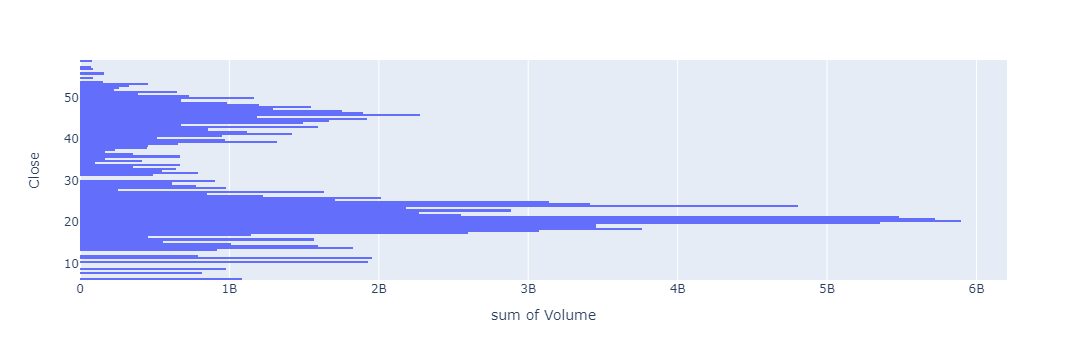

In [184]:
#This is the volume profile in which you get the volume activity at each price.  This highest volume activity at a certain price can make that price
#a good bounce off point
px.histogram(df_stock_wk, x='Volume', y='Close', nbins=150, orientation='h').show()

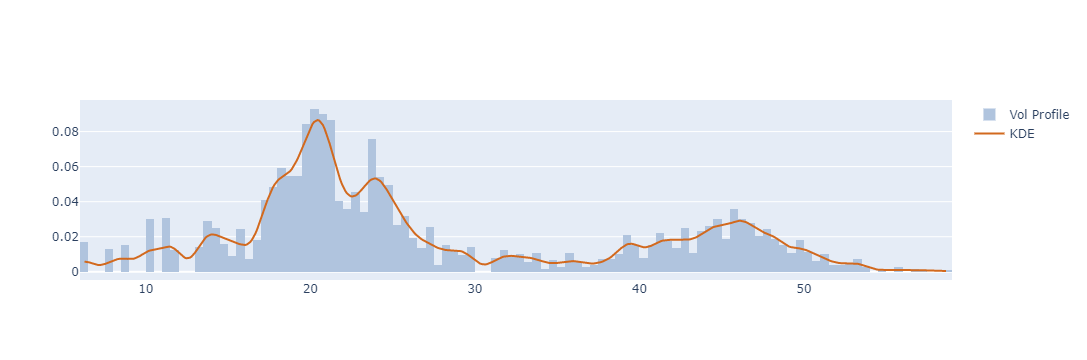

In [185]:
#makes the graph vertical like the daily charts
kde_factor = 0.05
num_samples = 500
close = df_stock_wk['Close']
volume = df_stock_wk['Volume']
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

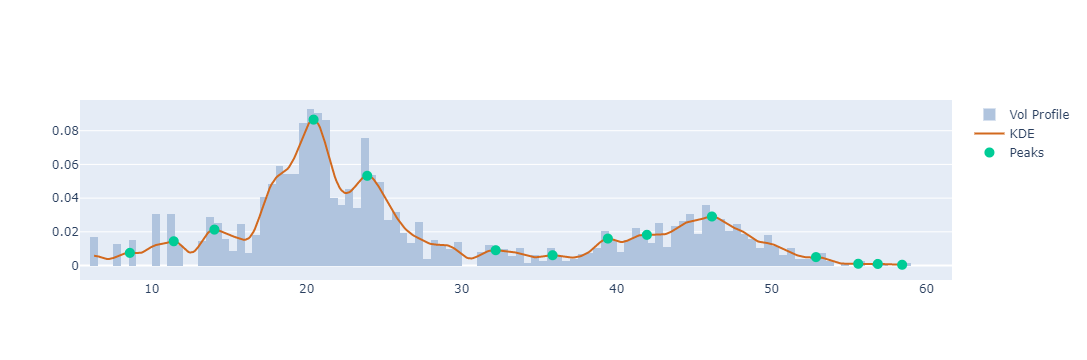

In [186]:
#adds a green dot like the daily chart
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
rgs=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

#Monthly Analysis

In [187]:
#This block of code pulls the monthly candlestick periods from Yahoo Finance and makes it into a dataframe
stock_df_mo = stock.history(period="10y", interval='1mo')
stock_df_mo.index.duplicated().sum()
df_stock_mo = stock_df_mo.loc[~stock_df_mo.index.duplicated(keep='first')]
df_stock_mo.dropna(inplace=True)
df_stock_mo.tail()

Open       High        Low      Close       Volume  \
Date                                                                  
2021-07-01  45.282904  46.646966  41.788117  45.740910  560765900.0   
2021-08-01  45.840480  51.187207  44.914510  45.501953  528635100.0   
2021-09-01  45.700001  48.939999  43.270000  46.410000  651280800.0   
2021-10-01  46.549999  48.740002  44.830002  48.380001  283434800.0   
2021-10-15  45.720001  48.740002  45.709999  48.380001   58942594.0   

            Dividends  Stock Splits  
Date                                 
2021-07-01        0.0             0  
2021-08-01        0.0             0  
2021-09-01        0.0             0  
2021-10-01        0.0             0  
2021-10-15        0.0             0

In [188]:
# calculate Bollinger Bands on monthly data
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg_mo = df_stock_mo['Close'].ewm(span=length).mean()
df_stock_mo['Moving average monthly'] = m_avg_mo
# standard deviation
m_std_mo = df_stock_mo['Close'].rolling(window=length).std()
# upper Bollinger Bands
df_stock_mo['upper_BB'] = m_avg_mo + mult * m_std_mo
# lower Bollinger Bands 
df_stock_mo['lower_BB'] = m_avg_mo - mult * m_std_mo
df_stock_mo.head()
df_stock_mo.dropna(inplace=True)

In [189]:
#Stacked Moving averages monthly 
m_avg_08_mo = df_stock_mo['Close'].ewm(span=8).mean()
m_avg_21_mo = df_stock_mo['Close'].ewm(span=21).mean()
m_avg_34_mo = df_stock_mo['Close'].ewm(span=34).mean()
m_avg_55_mo = df_stock_mo['Close'].ewm(span=55).mean()
m_avg_89_mo = df_stock_mo['Close'].ewm(span=89).mean()

df_stock_mo['m_avg_08'] = m_avg_08_mo
df_stock_mo['m_avg_21'] = m_avg_21_mo
df_stock_mo['m_avg_34'] = m_avg_34_mo
df_stock_mo['m_avg_55'] = m_avg_55_mo
df_stock_mo['m_avg_89'] = m_avg_89_mo

In [190]:
# calculate Keltner Channel monthly
# first we need to calculate True Range
df_stock_mo['tr0'] = abs(df_stock_mo["High"] - df_stock_mo["Low"])
df_stock_mo['tr1'] = abs(df_stock_mo["High"] - df_stock_mo["Close"].shift())
df_stock_mo['tr2'] = abs(df_stock_mo["Low"] - df_stock_mo["Close"].shift())
df_stock_mo['tr'] = df_stock_mo[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR
range_ma_mo = df_stock_mo['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock_mo['upper_KC'] = m_avg_mo + range_ma_mo * mult_KC
# lower Keltner Channel
df_stock_mo['lower_KC'] = m_avg_mo - range_ma_mo * mult_KC
df_stock_mo.tail()

Open       High        Low      Close       Volume  \
Date                                                                  
2021-07-01  45.282904  46.646966  41.788117  45.740910  560765900.0   
2021-08-01  45.840480  51.187207  44.914510  45.501953  528635100.0   
2021-09-01  45.700001  48.939999  43.270000  46.410000  651280800.0   
2021-10-01  46.549999  48.740002  44.830002  48.380001  283434800.0   
2021-10-15  45.720001  48.740002  45.709999  48.380001   58942594.0   

            Dividends  Stock Splits  Moving average monthly   upper_BB  \
Date                                                                     
2021-07-01        0.0             0               37.546269  57.000620   
2021-08-01        0.0             0               38.303959  56.825397   
2021-09-01        0.0             0               39.075968  57.830358   
2021-10-01        0.0             0               39.962072  59.732934   
2021-10-15        0.0             0               40.763784  61.274466   

             lower_BB   m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89  \
Date                                                                           
2021-07-01  18.091919  40.468320  37.572327  38.548638  39.956482  40.978312   
2021-08-01  19.782521  41.586905  38.293260  38.947147  40.160095  41.091020   
2021-09-01  20.321578  42.658704  39.031199  39.374786  40.389344  41.223188   
2021-10-01  20.191210  43.930104  39.881146  39.890724  40.682161  41.400557   
2021-10-15  20.253101  44.918970  40.653815  40.377029  40.963986  41.573089   

                 tr0       tr1       tr2        tr   upper_KC   lower_KC  
Date                                                                      
2021-07-01  4.858849  1.553239  3.305610  4.858849  48.850496  26.242043  
2021-08-01  6.272697  5.446298  0.826400  6.272697  49.721028  26.886890  
2021-09-01  5.669998  3.438046  2.231953  5.669998  50.486030  27.665906  
2021-10-01  3.910000  2.330002  1.579998  3.910000  51.045743  28.878401  
2021-10-15  3.030003  0.360001  2.670002  3.030003  51.390731  30.136837

In [191]:
#ADX Calculations monthly, same as daily and weekly

plus_dm_mo = df_stock_mo["High"].diff()
minus_dm_mo = df_stock_mo["Low"].diff()
plus_dm_mo[plus_dm_mo < 0] = 0
minus_dm_mo[minus_dm_mo > 0] = 0

df_stock_mo['atr'] = df_stock_mo['tr'].ewm(span=14).mean()
df_stock_mo['plus_di'] = 100 * (plus_dm_mo.ewm(alpha = 1/14).mean() / df_stock_mo['atr'])
df_stock_mo['minus_di'] = abs(100 * (minus_dm_mo.ewm(alpha = 1/14).mean() / df_stock_mo['atr']))
dx_mo = (abs(df_stock_mo['plus_di'] - df_stock_mo['minus_di']) / abs(df_stock_mo['plus_di'] + df_stock_mo['minus_di'])) * 100
adx_mo = ((dx_mo.shift(1) * (14 - 1)) + dx_mo) / 14
df_stock_mo['adx'] = adx_mo.ewm(alpha = 1/14).mean()
df_stock_mo.dropna(inplace=True)
df_stock_mo.head()

Open       High        Low      Close       Volume  \
Date                                                                  
2013-08-01  34.592164  35.022710  32.032391  32.157642  321439400.0   
2013-09-01  32.827509  34.545732  32.228494  32.567410  366625700.0   
2013-10-01  32.606818  34.206816  31.582190  33.647209  426027500.0   
2013-11-01  33.670857  35.270852  32.874798  34.695484  315449500.0   
2013-12-01  35.012817  36.227271  34.298430  36.036770  325412900.0   

            Dividends  Stock Splits  Moving average monthly   upper_BB  \
Date                                                                     
2013-08-01        0.0             0               28.610154  34.990829   
2013-09-01        0.0             0               29.028942  35.333084   
2013-10-01        0.0             0               29.512562  36.011803   
2013-11-01        0.0             0               30.050215  37.039579   
2013-12-01        0.0             0               30.666000  38.185567   

             lower_BB   m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89  \
Date                                                                           
2013-08-01  22.229478  32.813781  32.832134  32.835070  32.836615  32.837469   
2013-09-01  22.724800  32.727433  32.756213  32.762139  32.765599  32.767662   
2013-10-01  23.013322  33.013151  32.969888  32.960571  32.954973  32.951565   
2013-11-01  23.060851  33.493296  33.330079  33.293861  33.272057  33.258789   
2013-12-01  23.146434  34.176075  33.835505  33.758133  33.711383  33.682893   

                 tr0       tr1       tr2        tr   upper_KC   lower_KC  \
Date                                                                       
2013-08-01  2.990319  0.970673  2.019646  2.990319  33.984410  23.235897   
2013-09-01  2.317238  2.388089  0.070851  2.388089  34.231674  23.826209   
2013-10-01  2.624626  1.639407  0.985219  2.624626  34.726451  24.298673   
2013-11-01  2.396054  1.623643  0.772411  2.396054  35.176064  24.924366   
2013-12-01  1.928841  1.531787  0.397054  1.928841  35.555041  25.776960   

                 atr    plus_di  minus_di         adx  
Date                                                   
2013-08-01  2.704547  42.504918  0.000000  100.000000  
2013-09-01  2.607734  28.287221  0.000000  100.000000  
2013-10-01  2.612141  20.376565  6.889178   98.706636  
2013-11-01  2.562142  25.562031  5.403382   85.307258  
2013-12-01  2.428692  29.436778  4.565966   80.778423

In [192]:
# check for 'squeeze' monthly
df_stock_mo['squeeze_on'] = (df_stock_mo['lower_BB'] > df_stock_mo['lower_KC']) & (df_stock_mo['upper_BB'] < df_stock_mo['upper_KC'])
df_stock_mo['squeeze_off'] = (df_stock_mo['lower_BB'] < df_stock_mo['lower_KC']) & (df_stock_mo['upper_BB'] > df_stock_mo['upper_KC'])
df_stock_mo.head()

Open       High        Low      Close       Volume  \
Date                                                                  
2013-08-01  34.592164  35.022710  32.032391  32.157642  321439400.0   
2013-09-01  32.827509  34.545732  32.228494  32.567410  366625700.0   
2013-10-01  32.606818  34.206816  31.582190  33.647209  426027500.0   
2013-11-01  33.670857  35.270852  32.874798  34.695484  315449500.0   
2013-12-01  35.012817  36.227271  34.298430  36.036770  325412900.0   

            Dividends  Stock Splits  Moving average monthly   upper_BB  \
Date                                                                     
2013-08-01        0.0             0               28.610154  34.990829   
2013-09-01        0.0             0               29.028942  35.333084   
2013-10-01        0.0             0               29.512562  36.011803   
2013-11-01        0.0             0               30.050215  37.039579   
2013-12-01        0.0             0               30.666000  38.185567   

             lower_BB   m_avg_08   m_avg_21   m_avg_34   m_avg_55   m_avg_89  \
Date                                                                           
2013-08-01  22.229478  32.813781  32.832134  32.835070  32.836615  32.837469   
2013-09-01  22.724800  32.727433  32.756213  32.762139  32.765599  32.767662   
2013-10-01  23.013322  33.013151  32.969888  32.960571  32.954973  32.951565   
2013-11-01  23.060851  33.493296  33.330079  33.293861  33.272057  33.258789   
2013-12-01  23.146434  34.176075  33.835505  33.758133  33.711383  33.682893   

                 tr0       tr1       tr2        tr   upper_KC   lower_KC  \
Date                                                                       
2013-08-01  2.990319  0.970673  2.019646  2.990319  33.984410  23.235897   
2013-09-01  2.317238  2.388089  0.070851  2.388089  34.231674  23.826209   
2013-10-01  2.624626  1.639407  0.985219  2.624626  34.726451  24.298673   
2013-11-01  2.396054  1.623643  0.772411  2.396054  35.176064  24.924366   
2013-12-01  1.928841  1.531787  0.397054  1.928841  35.555041  25.776960   

                 atr    plus_di  minus_di         adx  squeeze_on  squeeze_off  
Date                                                                            
2013-08-01  2.704547  42.504918  0.000000  100.000000       False         True  
2013-09-01  2.607734  28.287221  0.000000  100.000000       False         True  
2013-10-01  2.612141  20.376565  6.889178   98.706636       False         True  
2013-11-01  2.562142  25.562031  5.403382   85.307258       False         True  
2013-12-01  2.428692  29.436778  4.565966   80.778423       False         True

In [193]:
# Momentum monthly
highest_mo = df_stock_mo['High'].rolling(window = length_KC).max()
lowest_mo = df_stock_mo['Low'].rolling(window = length_KC).min()
m1_mo = (highest_mo + lowest_mo) / 2
df_stock_mo['value'] = (df_stock_mo['Close'] - (m1_mo + m_avg_mo)/2)
fit_y_mo = np.array(range(0,length_KC))
df_stock_mo['value'] = df_stock_mo['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y_mo, x, 1)[0] * (length_KC-1) +
   np.polyfit(fit_y_mo, x, 1)[1], raw=True)

df_stock_mo[['squeeze_on', 'squeeze_off']] = (df_stock_mo[['squeeze_on', 'squeeze_off']] == True).astype(float)

df_stock_mo["pct_change"] = df_stock_mo['Close'].pct_change()
df_stock_mo.dropna(inplace=True)
"""
conditions = [
    (df_stock['pct_change'] > 0) | (df_stock['squeeze_on'] == 1),
    (df_stock['pct_change'] < 0) | (df_stock['squeeze_on'] == 0)
]
"""
conditions_mo =  [
    (df_stock_mo['pct_change'] > 0),
    (df_stock_mo['pct_change'] < 0)
]

label = [1, 0]
df_stock_mo['profitable?'] = np.select(conditions_mo, label) 

df_stock_mo

Open       High        Low      Close        Volume  \
Date                                                                   
2016-12-01  45.948548  50.177578  45.888010  47.660915  5.146109e+08   
2017-01-01  48.145215  49.580840  46.130157  48.716007  4.338766e+08   
2017-02-01  48.897620  51.033754  47.712798  50.056496  3.024053e+08   
2017-03-01  51.467438  52.233660  47.227100  48.463501  3.956213e+08   
2017-04-01  48.498329  48.933682  44.632391  46.878815  4.130887e+08   
2017-05-01  47.105185  48.411244  44.257980  44.527897  3.973533e+08   
2017-06-01  45.182288  49.627740  44.770187  48.584332  4.076719e+08   
2017-07-01  48.935057  49.496218  46.629032  47.295410  3.239182e+08   
2017-08-01  47.549685  47.689976  44.603586  44.778950  3.945524e+08   
2017-09-01  45.095395  48.778272  43.514494  48.707619  3.753363e+08   
2017-10-01  48.716446  49.917577  46.667459  49.581966  3.751604e+08   
2017-11-01  49.740938  50.632956  46.994234  49.873417  3.681779e+08   
2017-12-01  50.310807  55.353451  49.305835  53.957161  4.221241e+08   
2018-01-01  54.286229  58.973127  53.983848  58.501770  3.626117e+08   
2018-02-01  58.137133  58.777462  48.665501  51.947220  6.014210e+08   
2018-03-01  52.113897  52.731211  45.350273  46.889088  4.638587e+08   
2018-04-01  46.853310  48.275819  44.965578  46.486500  4.351188e+08   
2018-05-01  46.307557  50.261953  45.457634  48.302650  4.024052e+08   
2018-06-01  49.180118  51.487687  47.791968  49.973343  3.876133e+08   
2018-07-01  49.757003  53.425680  48.341813  51.640919  4.137728e+08   
2018-08-01  52.244863  53.660053  51.451638  52.713589  3.742936e+08   
2018-09-01  53.072090  53.753083  47.587822  47.724022  4.061240e+08   
2018-10-01  47.887461  49.948598  45.417723  48.332375  5.460185e+08   
2018-11-01  48.513975  49.603566  46.452835  49.285767  4.192408e+08   
2018-12-01  50.142177  50.380167  39.377812  42.178745  5.972596e+08   
2019-01-01  41.675305  46.261147  41.565466  44.769146  4.704233e+08   
2019-02-01  45.258123  46.394194  43.466273  46.080158  3.314901e+08   
2019-03-01  46.394194  48.416953  44.149760  44.630051  4.634360e+08   
2019-04-01  44.731646  45.886190  42.173177  44.713173  5.569537e+08   
2019-05-01  44.630045  45.119570  40.843142  40.981686  4.138276e+08   
2019-06-01  41.256630  44.483301  41.219327  44.128925  3.829368e+08   
2019-07-01  44.651159  46.227190  42.095932  45.145416  4.116567e+08   
2019-08-01  45.145422  45.359912  40.417323  43.429504  4.248639e+08   
2019-09-01  43.673245  48.482865  42.890501  47.568092  4.681776e+08   
2019-10-01  47.766144  49.378781  44.625743  48.690346  4.639667e+08   
2019-11-01  49.161872  51.632696  48.954397  51.359207  3.288350e+08   
2019-12-01  51.707922  51.945944  49.670450  51.222355  3.906431e+08   
2020-01-01  51.269959  51.450858  44.500614  44.691029  4.843746e+08   
2020-02-01  44.976659  46.176289  37.845515  38.892811  4.287179e+08   
2020-03-01  39.432868  41.280383  24.162014  27.616480  1.116096e+09   
2020-04-01  25.999905  32.629784  24.931810  27.953264  8.681618e+08   
2020-05-01  27.424028  27.452896  21.169425  25.470667  1.055455e+09   
2020-06-01  26.125654  33.273144  24.711863  25.134037  1.222761e+09   
2020-07-01  25.261671  26.361286  22.905355  23.818428  1.032530e+09   
2020-08-01  23.808608  25.664207  23.091896  23.710428  7.361330e+08   
2020-09-01  23.679843  25.631803  22.240518  23.177065  9.975912e+08   
2020-10-01  23.236215  25.375485  20.466009  21.146238  8.204949e+08   
2020-11-01  21.392699  28.323143  20.870204  26.962687  8.682485e+08   
2020-12-01  27.878772  30.196226  27.581663  29.889214  7.376676e+08   
2021-01-01  30.027863  34.761806  29.116727  29.592102  7.980796e+08   
2021-02-01  29.849599  38.307317  29.394032  35.821499  6.555060e+08   
2021-03-01  36.868749  41.269949  36.103754  38.816006  7.815574e+08   
2021-04-01  38.706717  46.088415  38.666976  44.757126  6.344991e+08   
2021-05-01  45.154527  47.817105  44.379595  46.416271  5

In [194]:
# entry point for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1_mo = (df_stock_mo['squeeze_off'].iloc[-2] == 0) | (df_stock_mo['squeeze_off'][-1] == 1) 
# 2. bar value is positive => the bar is light green
long_cond2_mo = df_stock_mo['value'][-1] > 0

enter_long_mo = long_cond1_mo and long_cond2_mo
# entry point for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1_mo = (df_stock_mo['squeeze_off'][-2] == 0) | (df_stock_mo['squeeze_off'][-1] == 1) 
# 2. bar value is negative => the bar is light red 
short_cond2_mo = df_stock_mo['value'][-1] < 0
enter_short_mo = short_cond1_mo and short_cond2_mo

In [195]:
#To plot the candlestick graph
ohcl_mo = df_stock_mo[['Open', 'High', 'Close', 'Low']]
ohcl_mo.head()

Open       High      Close        Low
Date                                                  
2016-12-01  45.948548  50.177578  47.660915  45.888010
2017-01-01  48.145215  49.580840  48.716007  46.130157
2017-02-01  48.897620  51.033754  50.056496  47.712798
2017-03-01  51.467438  52.233660  48.463501  47.227100
2017-04-01  48.498329  48.933682  46.878815  44.632391

In [196]:
# add colors for the 'value bar' on the monthly
colors = []
for ind, val in enumerate(df_stock_mo['value']):
  if val >= 0:
    color = 'blue'
    if val > df_stock_mo['value'][ind-1]:
      color = 'cyan'
  else:
    color = 'yellow'
    if val < df_stock_mo['value'][ind-1]:
      color='red'
  colors.append(color)

df_stock_mo['colors'] = colors

In [197]:
# add 2 subplots: 1. bars, 2. crosses
apds = [mpf.make_addplot(df_stock_mo['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
        mpf.make_addplot([0] * len(df_stock_mo), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_mo['squeeze_off']], secondary_y=False),
        mpf.make_addplot(df_stock_mo[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock_mo[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock_mo[['upper_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_mo[['lower_KC']], color = 'blue'),
        mpf.make_addplot(df_stock_mo['Moving average monthly'], color = 'black'),
        mpf.make_addplot(df_stock_mo[['adx']], panel=2, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock_mo[['plus_di']], panel=2, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock_mo[['minus_di']], panel=2, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_08'], panel=3, color='red', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_21'], panel=3, color='orange', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_34'], panel=3, color='yellow', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_55'], panel=3, color='green', secondary_y=False),
        mpf.make_addplot(df_stock_mo['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
#Squeeze Panel 1
#ADX panel 2
#Momentum Panel 3
fig, axes = mpf.plot(ohcl_mo, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [198]:
def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    Monthly slow stochastics
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()

    return df


stochs_mo = stochastics( df_stock_mo, 'Low', 'High', 'Close', 14, 3 )
slow_k_mo = stochs_mo['k_slow'].values
fast_k_mo = stochs_mo['k_fast'].values
df_stock_mo["slow_K"] = slow_k_mo
df_stock_mo['fast_K'] = fast_k_mo
df_stock_mo

Open       High        Low      Close        Volume  \
Date                                                                   
2016-12-01  45.948548  50.177578  45.888010  47.660915  5.146109e+08   
2017-01-01  48.145215  49.580840  46.130157  48.716007  4.338766e+08   
2017-02-01  48.897620  51.033754  47.712798  50.056496  3.024053e+08   
2017-03-01  51.467438  52.233660  47.227100  48.463501  3.956213e+08   
2017-04-01  48.498329  48.933682  44.632391  46.878815  4.130887e+08   
2017-05-01  47.105185  48.411244  44.257980  44.527897  3.973533e+08   
2017-06-01  45.182288  49.627740  44.770187  48.584332  4.076719e+08   
2017-07-01  48.935057  49.496218  46.629032  47.295410  3.239182e+08   
2017-08-01  47.549685  47.689976  44.603586  44.778950  3.945524e+08   
2017-09-01  45.095395  48.778272  43.514494  48.707619  3.753363e+08   
2017-10-01  48.716446  49.917577  46.667459  49.581966  3.751604e+08   
2017-11-01  49.740938  50.632956  46.994234  49.873417  3.681779e+08   
2017-12-01  50.310807  55.353451  49.305835  53.957161  4.221241e+08   
2018-01-01  54.286229  58.973127  53.983848  58.501770  3.626117e+08   
2018-02-01  58.137133  58.777462  48.665501  51.947220  6.014210e+08   
2018-03-01  52.113897  52.731211  45.350273  46.889088  4.638587e+08   
2018-04-01  46.853310  48.275819  44.965578  46.486500  4.351188e+08   
2018-05-01  46.307557  50.261953  45.457634  48.302650  4.024052e+08   
2018-06-01  49.180118  51.487687  47.791968  49.973343  3.876133e+08   
2018-07-01  49.757003  53.425680  48.341813  51.640919  4.137728e+08   
2018-08-01  52.244863  53.660053  51.451638  52.713589  3.742936e+08   
2018-09-01  53.072090  53.753083  47.587822  47.724022  4.061240e+08   
2018-10-01  47.887461  49.948598  45.417723  48.332375  5.460185e+08   
2018-11-01  48.513975  49.603566  46.452835  49.285767  4.192408e+08   
2018-12-01  50.142177  50.380167  39.377812  42.178745  5.972596e+08   
2019-01-01  41.675305  46.261147  41.565466  44.769146  4.704233e+08   
2019-02-01  45.258123  46.394194  43.466273  46.080158  3.314901e+08   
2019-03-01  46.394194  48.416953  44.149760  44.630051  4.634360e+08   
2019-04-01  44.731646  45.886190  42.173177  44.713173  5.569537e+08   
2019-05-01  44.630045  45.119570  40.843142  40.981686  4.138276e+08   
2019-06-01  41.256630  44.483301  41.219327  44.128925  3.829368e+08   
2019-07-01  44.651159  46.227190  42.095932  45.145416  4.116567e+08   
2019-08-01  45.145422  45.359912  40.417323  43.429504  4.248639e+08   
2019-09-01  43.673245  48.482865  42.890501  47.568092  4.681776e+08   
2019-10-01  47.766144  49.378781  44.625743  48.690346  4.639667e+08   
2019-11-01  49.161872  51.632696  48.954397  51.359207  3.288350e+08   
2019-12-01  51.707922  51.945944  49.670450  51.222355  3.906431e+08   
2020-01-01  51.269959  51.450858  44.500614  44.691029  4.843746e+08   
2020-02-01  44.976659  46.176289  37.845515  38.892811  4.287179e+08   
2020-03-01  39.432868  41.280383  24.162014  27.616480  1.116096e+09   
2020-04-01  25.999905  32.629784  24.931810  27.953264  8.681618e+08   
2020-05-01  27.424028  27.452896  21.169425  25.470667  1.055455e+09   
2020-06-01  26.125654  33.273144  24.711863  25.134037  1.222761e+09   
2020-07-01  25.261671  26.361286  22.905355  23.818428  1.032530e+09   
2020-08-01  23.808608  25.664207  23.091896  23.710428  7.361330e+08   
2020-09-01  23.679843  25.631803  22.240518  23.177065  9.975912e+08   
2020-10-01  23.236215  25.375485  20.466009  21.146238  8.204949e+08   
2020-11-01  21.392699  28.323143  20.870204  26.962687  8.682485e+08   
2020-12-01  27.878772  30.196226  27.581663  29.889214  7.376676e+08   
2021-01-01  30.027863  34.761806  29.116727  29.592102  7.980796e+08   
2021-02-01  29.849599  38.307317  29.394032  35.821499  6.555060e+08   
2021-03-01  36.868749  41.269949  36.103754  38.816006  7.815574e+08   
2021-04-01  38.706717  46.088415  38.666976  44.757126  6.344991e+08   
2021-05-01  45.154527  47.817105  44.379595  46.416271  5

In [199]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df_stock_mo['rsi_14'] = get_rsi(df_stock_mo['Close'], 14)
df_stock_mo = df_stock_mo.dropna()
df_stock_mo['Overbought'] = 70
df_stock_mo['Oversold'] = 30
df_stock_mo

Open       High        Low      Close        Volume  \
Date                                                                   
2018-03-01  52.113897  52.731211  45.350273  46.889088  4.638587e+08   
2018-04-01  46.853310  48.275819  44.965578  46.486500  4.351188e+08   
2018-05-01  46.307557  50.261953  45.457634  48.302650  4.024052e+08   
2018-06-01  49.180118  51.487687  47.791968  49.973343  3.876133e+08   
2018-07-01  49.757003  53.425680  48.341813  51.640919  4.137728e+08   
2018-08-01  52.244863  53.660053  51.451638  52.713589  3.742936e+08   
2018-09-01  53.072090  53.753083  47.587822  47.724022  4.061240e+08   
2018-10-01  47.887461  49.948598  45.417723  48.332375  5.460185e+08   
2018-11-01  48.513975  49.603566  46.452835  49.285767  4.192408e+08   
2018-12-01  50.142177  50.380167  39.377812  42.178745  5.972596e+08   
2019-01-01  41.675305  46.261147  41.565466  44.769146  4.704233e+08   
2019-02-01  45.258123  46.394194  43.466273  46.080158  3.314901e+08   
2019-03-01  46.394194  48.416953  44.149760  44.630051  4.634360e+08   
2019-04-01  44.731646  45.886190  42.173177  44.713173  5.569537e+08   
2019-05-01  44.630045  45.119570  40.843142  40.981686  4.138276e+08   
2019-06-01  41.256630  44.483301  41.219327  44.128925  3.829368e+08   
2019-07-01  44.651159  46.227190  42.095932  45.145416  4.116567e+08   
2019-08-01  45.145422  45.359912  40.417323  43.429504  4.248639e+08   
2019-09-01  43.673245  48.482865  42.890501  47.568092  4.681776e+08   
2019-10-01  47.766144  49.378781  44.625743  48.690346  4.639667e+08   
2019-11-01  49.161872  51.632696  48.954397  51.359207  3.288350e+08   
2019-12-01  51.707922  51.945944  49.670450  51.222355  3.906431e+08   
2020-01-01  51.269959  51.450858  44.500614  44.691029  4.843746e+08   
2020-02-01  44.976659  46.176289  37.845515  38.892811  4.287179e+08   
2020-03-01  39.432868  41.280383  24.162014  27.616480  1.116096e+09   
2020-04-01  25.999905  32.629784  24.931810  27.953264  8.681618e+08   
2020-05-01  27.424028  27.452896  21.169425  25.470667  1.055455e+09   
2020-06-01  26.125654  33.273144  24.711863  25.134037  1.222761e+09   
2020-07-01  25.261671  26.361286  22.905355  23.818428  1.032530e+09   
2020-08-01  23.808608  25.664207  23.091896  23.710428  7.361330e+08   
2020-09-01  23.679843  25.631803  22.240518  23.177065  9.975912e+08   
2020-10-01  23.236215  25.375485  20.466009  21.146238  8.204949e+08   
2020-11-01  21.392699  28.323143  20.870204  26.962687  8.682485e+08   
2020-12-01  27.878772  30.196226  27.581663  29.889214  7.376676e+08   
2021-01-01  30.027863  34.761806  29.116727  29.592102  7.980796e+08   
2021-02-01  29.849599  38.307317  29.394032  35.821499  6.555060e+08   
2021-03-01  36.868749  41.269949  36.103754  38.816006  7.815574e+08   
2021-04-01  38.706717  46.088415  38.666976  44.757126  6.344991e+08   
2021-05-01  45.154527  47.817105  44.379595  46.416271  5.266847e+08   
2021-06-01  46.955622  47.254321  41.290282  45.093727  6.076724e+08   
2021-07-01  45.282904  46.646966  41.788117  45.740910  5.607659e+08   
2021-08-01  45.840480  51.187207  44.914510  45.501953  5.286351e+08   
2021-09-01  45.700001  48.939999  43.270000  46.410000  6.512808e+08   
2021-10-01  46.549999  48.740002  44.830002  48.380001  2.834348e+08   
2021-10-15  45.720001  48.740002  45.709999  48.380001  5.894259e+07   

            Dividends  Stock Splits  Moving average monthly   upper_BB  \
Date                                                                     
2018-03-01        0.0             0               48.273893  57.437092   
2018-04-01        0.0             0               48.103596  57.050553   
2018-05-01        0.0             0               48.122560  55.785995   
2018-06-01        0.0             0               48.298884  54.756251   
2018-07-01        0.0             0               48.617269  54.978101   
2018-08-01        0.0             0               49.007501  55.520324   
2018-09-01        0.0             0     

In [200]:
apds2 = [mpf.make_addplot(df_stock_mo['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
         mpf.make_addplot([0] * len(df_stock_mo), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_mo['squeeze_off']], secondary_y=False),
         mpf.make_addplot(df_stock_mo[['upper_BB']], color = 'red'),
         mpf.make_addplot(df_stock_mo[['lower_BB']], color = 'red'),
         mpf.make_addplot(df_stock_mo[['upper_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_mo[['lower_KC']], color = 'blue'),
         mpf.make_addplot(df_stock_mo['Moving average monthly'], color = 'black'),
         mpf.make_addplot(df_stock_mo['m_avg_08'], color = 'green'),
         mpf.make_addplot(df_stock_mo['m_avg_34'], color = 'orange'),
         mpf.make_addplot(df_stock_mo['slow_K'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock_mo['fast_K'], panel=2, color = 'blue'),
         mpf.make_addplot(df_stock_mo['Overbought'], panel=2, color = 'green'),
         mpf.make_addplot(df_stock_mo['Oversold'], panel=2, color = 'red'),
         mpf.make_addplot(df_stock_mo['Overbought'], panel=3, color = 'green'),
         mpf.make_addplot(df_stock_mo['Oversold'], panel=3, color = 'red'),
         mpf.make_addplot(df_stock_mo['rsi_14'], panel=3, color='purple')]
fig, axes = mpf.plot(df_stock_mo, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [201]:
#checks the momentum based on the EMA's stacking
#If smaller EMA's stack above the larger, the momentum is positive, vice versa, negative
def momentum_checker_mo(index):
    if (df_stock_mo['m_avg_08'][index] > df_stock_mo['m_avg_21'][index] > df_stock_mo['m_avg_34'][index] > df_stock_mo['m_avg_55'][index] > df_stock_mo['m_avg_89'][index]):
        return 'Positive momentum'
    elif (df_stock_mo['m_avg_08'][index] < df_stock_mo['m_avg_21'][index] < df_stock_mo['m_avg_34'][index] < df_stock_mo['m_avg_55'][index] < df_stock_mo['m_avg_89'][index]):
        return 'Negative momentum'
    else:
        return 'neutral'

#direction of trent
df_stock_mo['ADX_trend'] = 20

def ADX_trend_flag_mo(index):
    if (df_stock_mo['adx'][index] > df_stock_mo['ADX_trend'][index]) and (df_stock_mo['plus_di'][index] > df_stock_mo['minus_di'][index]):
        return 'positive trend'
    elif (df_stock_mo['adx'][index] > df_stock_mo['ADX_trend'][index]) and (df_stock_mo['plus_di'][index] < df_stock_mo['minus_di'][index]):
        return 'negative trend'
    elif (df_stock_mo['adx'][index] < df_stock_mo['ADX_trend'][index]):
        return 'neutral or sideways trend'

#early warning
def warning_mo(index):
    if (df_stock_mo['m_avg_08'][index] < df_stock_mo['m_avg_21'][index]):
        return 'Warning, stock maybe heading down, consider puts on pullback to the 8 EMA, and hold off on long positions.  Watch ADX for negative trend. If this happens with any of the market indices such as SPY, QQQ, or DJI, hold of on long positions.  Watch the chart for the 8 crossing the 34.  This is especially bad with this monthly chart'
    if (df_stock_mo['m_avg_08'][index] < df_stock_mo['m_avg_34'][index]):
        return 'As long as there is tension in the news, you can short or buy puts on any price moves back to the 8 or the 21 ema'
    elif (df_stock_mo['m_avg_08'][index] > df_stock_mo['m_avg_21'][index]):
        return 'Continue as normal and watch for bearish candle patterns, especially when market is overbought and at the top bollinger'

#Squeeze cycles
def squeeze_flag_mo(index):
    if (df_stock_mo['squeeze_on'][index] == 1.0):
        return 'squeeze is on'
    else:
        return 'squeeze is off'

def squeeze_momentum_mo(index):
    if (df_stock_mo['colors'][index] == 'cyan'):
        return 'stock is in a mark up mode'
    elif (df_stock_mo['colors'][index] == 'blue'):
        return 'stock is in a distribution mode'
    elif (df_stock_mo['colors'][index] == 'yellow'):
        return 'stock is in an accumulation mode'
    elif (df_stock_mo['colors'][index] == 'red'):
        return 'stock is in a mark down mode'

In [202]:
momentum_checker_mo(-1)
ADX_trend_flag_mo(-1)
warning_mo(-1)
squeeze_flag_mo(-1)
squeeze_momentum_mo(-1)

'stock is in a mark up mode'

In [203]:
# To get the entry and exit signals for the algo trading using squeeze and momentum
t_percent_mo = float(input("enter threshold percentage"))
df_stock_mo['value_threshold'] = abs(df_stock_mo['value'].max()*t_percent_mo)
df_stock_mo['squeeze_threshold'] = 1.0
df_stock_mo["squeeze_entry"] = np.logical_and(np.greater(df_stock_mo["value"], df_stock_mo['value_threshold']), 
                                           np.equal(df_stock_mo['squeeze_on'], df_stock_mo['squeeze_threshold']))
df_stock_mo['squeeze_entry'] = df_stock_mo['squeeze_entry'].astype(float)
df_stock_mo['Entry/Exit'] = df_stock_mo['squeeze_entry'].diff()
df_stock_mo.dropna(inplace=True)

enter threshold percentage .10


In [221]:
#this is the monthly algo trade
#just testing an idea here to be able to enter a percent profit return
#The input is entered in the form of 1.something
#For example 1.5 means a 50% return
percent = float(input("Enter Percent Return"))
def implement_bb_strategy_mo(data, squeeze_on, squeeze_value, upper_kc, threshold, color, percent):
    buy_price = []
    sell_price = []
    squeeze_signal = []
    signal = 0.0
    buy_close = 0
    buy = False

    
    for close, squeeze, value, kc, thresh, color  in zip(data, squeeze_on, squeeze_value, upper_kc, threshold, color):
        if squeeze == 1.0 and value < thresh and (color == 'yellow' or color == 'cyan'):
            if signal != 1:
                buy_price.append(close)
                buy = True
                sell_price.append(np.nan)
                buy_close = close
                signal = 1.0
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        elif buy and close >= (buy_close*percent):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(close)
                signal = -1
                buy = False
                squeeze_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                squeeze_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            squeeze_signal.append(0)
            
    return buy_price, sell_price, squeeze_signal

Enter Percent Return 1.005


In [223]:
#calls the strategy function
buy_price_mo, sell_price_mo, squeeze_signal_mo = implement_bb_strategy_mo(df_stock_mo["Close"], df_stock_mo['squeeze_on'], df_stock_mo['value'], 
                                                              df_stock_mo['upper_KC'], df_stock_mo['value_threshold'], df_stock_mo['colors'], percent)

In [224]:
#creates the columns and appends to the dataframe
df_stock_mo['buy_price'] =  buy_price_mo
df_stock_mo['sell_price'] = sell_price_mo
df_stock_mo['squeeze_signal'] = squeeze_signal_mo
df_stock_mo

Open       High        Low      Close        Volume  \
Date                                                                   
2018-04-01  46.853310  48.275819  44.965578  46.486500  4.351188e+08   
2018-05-01  46.307557  50.261953  45.457634  48.302650  4.024052e+08   
2018-06-01  49.180118  51.487687  47.791968  49.973343  3.876133e+08   
2018-07-01  49.757003  53.425680  48.341813  51.640919  4.137728e+08   
2018-08-01  52.244863  53.660053  51.451638  52.713589  3.742936e+08   
2018-09-01  53.072090  53.753083  47.587822  47.724022  4.061240e+08   
2018-10-01  47.887461  49.948598  45.417723  48.332375  5.460185e+08   
2018-11-01  48.513975  49.603566  46.452835  49.285767  4.192408e+08   
2018-12-01  50.142177  50.380167  39.377812  42.178745  5.972596e+08   
2019-01-01  41.675305  46.261147  41.565466  44.769146  4.704233e+08   
2019-02-01  45.258123  46.394194  43.466273  46.080158  3.314901e+08   
2019-03-01  46.394194  48.416953  44.149760  44.630051  4.634360e+08   
2019-04-01  44.731646  45.886190  42.173177  44.713173  5.569537e+08   
2019-05-01  44.630045  45.119570  40.843142  40.981686  4.138276e+08   
2019-06-01  41.256630  44.483301  41.219327  44.128925  3.829368e+08   
2019-07-01  44.651159  46.227190  42.095932  45.145416  4.116567e+08   
2019-08-01  45.145422  45.359912  40.417323  43.429504  4.248639e+08   
2019-09-01  43.673245  48.482865  42.890501  47.568092  4.681776e+08   
2019-10-01  47.766144  49.378781  44.625743  48.690346  4.639667e+08   
2019-11-01  49.161872  51.632696  48.954397  51.359207  3.288350e+08   
2019-12-01  51.707922  51.945944  49.670450  51.222355  3.906431e+08   
2020-01-01  51.269959  51.450858  44.500614  44.691029  4.843746e+08   
2020-02-01  44.976659  46.176289  37.845515  38.892811  4.287179e+08   
2020-03-01  39.432868  41.280383  24.162014  27.616480  1.116096e+09   
2020-04-01  25.999905  32.629784  24.931810  27.953264  8.681618e+08   
2020-05-01  27.424028  27.452896  21.169425  25.470667  1.055455e+09   
2020-06-01  26.125654  33.273144  24.711863  25.134037  1.222761e+09   
2020-07-01  25.261671  26.361286  22.905355  23.818428  1.032530e+09   
2020-08-01  23.808608  25.664207  23.091896  23.710428  7.361330e+08   
2020-09-01  23.679843  25.631803  22.240518  23.177065  9.975912e+08   
2020-10-01  23.236215  25.375485  20.466009  21.146238  8.204949e+08   
2020-11-01  21.392699  28.323143  20.870204  26.962687  8.682485e+08   
2020-12-01  27.878772  30.196226  27.581663  29.889214  7.376676e+08   
2021-01-01  30.027863  34.761806  29.116727  29.592102  7.980796e+08   
2021-02-01  29.849599  38.307317  29.394032  35.821499  6.555060e+08   
2021-03-01  36.868749  41.269949  36.103754  38.816006  7.815574e+08   
2021-04-01  38.706717  46.088415  38.666976  44.757126  6.344991e+08   
2021-05-01  45.154527  47.817105  44.379595  46.416271  5.266847e+08   
2021-06-01  46.955622  47.254321  41.290282  45.093727  6.076724e+08   
2021-07-01  45.282904  46.646966  41.788117  45.740910  5.607659e+08   
2021-08-01  45.840480  51.187207  44.914510  45.501953  5.286351e+08   
2021-09-01  45.700001  48.939999  43.270000  46.410000  6.512808e+08   
2021-10-01  46.549999  48.740002  44.830002  48.380001  2.834348e+08   
2021-10-15  45.720001  48.740002  45.709999  48.380001  5.894259e+07   

            Dividends  Stock Splits  Moving average monthly   upper_BB  \
Date                                                                     
2018-04-01        0.0             0               48.103596  57.050553   
2018-05-01        0.0             0               48.122560  55.785995   
2018-06-01        0.0             0               48.298884  54.756251   
2018-07-01        0.0             0               48.617269  54.978101   
2018-08-01        0.0             0               49.007501  55.520324   
2018-09-01        0.0             0               48.885235  55.434799   
2018-10-01        0.0             0               48.832570  55.388044   
2018-11-01        0.0             0   

In [225]:
# Visualize exit position relative to close price
exit = df_stock_mo[df_stock_mo['squeeze_signal'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = df_stock_mo[df_stock_mo['squeeze_signal'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df_stock_mo[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [226]:
#this is the monthly backtesting for the algo code above.  See previous comments on the daily code to see how this works
position = []
#df_stock_wk = df_stock_wk.loc[~df_stock_wk.index.duplicated(keep='first')]
for i in range(len(squeeze_signal_mo)):
    if df_stock_mo['squeeze_signal'][i] < 1.0:
        position.append(0)
    else:
        position.append(1)

        
for i in range(len(df_stock_mo['Close'])):
    if df_stock_mo['squeeze_signal'][i] == 1.0:
        position[i] = 1.0
    elif df_stock_mo['squeeze_signal'][i] == -1.0:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
#upper_bb = tsla['upper_bb']
#lower_bb = tsla['lower_bb']
close_price = df_stock_mo['Close']
squeeze_signal_mo = pd.DataFrame(squeeze_signal_mo).rename(columns = {0:'squeeze_signal'}).set_index(df_stock_mo.index)
position = pd.DataFrame(position).rename(columns = {0:'squeeze_position'}).set_index(df_stock_mo.index)

frames = [close_price, squeeze_signal_mo, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index()

strategy

Date      Close  squeeze_signal  squeeze_position
0  2018-04-01  46.486500             0.0               0.0
1  2018-05-01  48.302650             0.0               0.0
2  2018-06-01  49.973343             0.0               0.0
3  2018-07-01  51.640919             0.0               0.0
4  2018-08-01  52.713589             0.0               0.0
5  2018-09-01  47.724022             0.0               0.0
6  2018-10-01  48.332375             0.0               0.0
7  2018-11-01  49.285767             0.0               0.0
8  2018-12-01  42.178745             0.0               0.0
9  2019-01-01  44.769146             0.0               0.0
10 2019-02-01  46.080158             0.0               0.0
11 2019-03-01  44.630051             0.0               0.0
12 2019-04-01  44.713173             0.0               0.0
13 2019-05-01  40.981686             0.0               0.0
14 2019-06-01  44.128925             0.0               0.0
15 2019-07-01  45.145416             0.0               0.0
16 2019-08-01  43.429504             0.0               0.0
17 2019-09-01  47.568092             1.0               1.0
18 2019-10-01  48.690346             0.0               1.0
19 2019-11-01  51.359207             0.0               1.0
20 2019-12-01  51.222355             0.0               1.0
21 2020-01-01  44.691029             0.0               1.0
22 2020-02-01  38.892811             0.0               1.0
23 2020-03-01  27.616480             0.0               1.0
24 2020-04-01  27.953264             0.0               1.0
25 2020-05-01  25.470667             0.0               1.0
26 2020-06-01  25.134037             0.0               1.0
27 2020-07-01  23.818428             0.0               1.0
28 2020-08-01  23.710428             0.0               1.0
29 2020-09-01  23.177065             0.0               1.0
30 2020-10-01  21.146238             0.0               1.0
31 2020-11-01  26.962687             0.0               1.0
32 2020-12-01  29.889214             0.0               1.0
33 2021-01-01  29.592102             0.0               1.0
34 2021-02-01  35.821499             0.0               1.0
35 2021-03-01  38.816006             0.0               1.0
36 2021-04-01  44.757126             0.0               1.0
37 2021-05-01  46.416271             0.0               1.0
38 2021-06-01  45.093727             0.0               1.0
39 2021-07-01  45.740910             0.0               1.0
40 2021-08-01  45.501953             0.0               1.0
41 2021-09-01  46.410000             0.0               1.0
42 2021-10-01  48.380001            -1.0               0.0
43 2021-10-15  48.380001             0.0               0.0

In [227]:
#Percent Return same code as daily.  See the daily comments for further information
stock_ret = pd.DataFrame(np.diff(df_stock_mo['Close'])).rename(columns = {0:'returns'})
squeeze_strategy_ret = []
return_sum = 0

for i in range(len(stock_ret)):
    try:
        returns = stock_ret['returns'][i]*strategy['squeeze_position'][i]
        squeeze_strategy_ret.append(returns)
    except:
        pass
    
squeeze_strategy_ret_df = pd.DataFrame(squeeze_strategy_ret).rename(columns = {0:'squeeze_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/df_stock_mo['Close'][-1])
squeeze_investment_ret = []

for i in range(len(squeeze_strategy_ret_df['squeeze_returns'])):
    #df_stock_wk['cumluative_return'] = np.exp(np.log1p(df_stock_wk['pct_change']).cumsum())
    returns = (number_of_stocks*squeeze_strategy_ret_df['squeeze_returns'][i])
    squeeze_investment_ret.append(returns)
    return_sum += returns
    new_investment_value = return_sum + investment_value
    number_of_stocks = math.floor(new_investment_value/df_stock_mo['Close'][i-1])
    
squeeze_investment_ret_df = pd.DataFrame(squeeze_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(squeeze_investment_ret_df['investment_returns']), 2)
profit_percentage = math.floor((total_investment_ret/investment_value)*100)
print(f'Profit gained from the Squeeze strategy by investing $100k in {value} is {total_investment_ret}')
print(f'Profit percentage of the Squeeze strategy : {profit_percentage}%')
print(return_sum)

Profit gained from the Squeeze strategy by investing $100k in wfc is 25548.23
Profit percentage of the Squeeze strategy : 25%
25548.23045539856


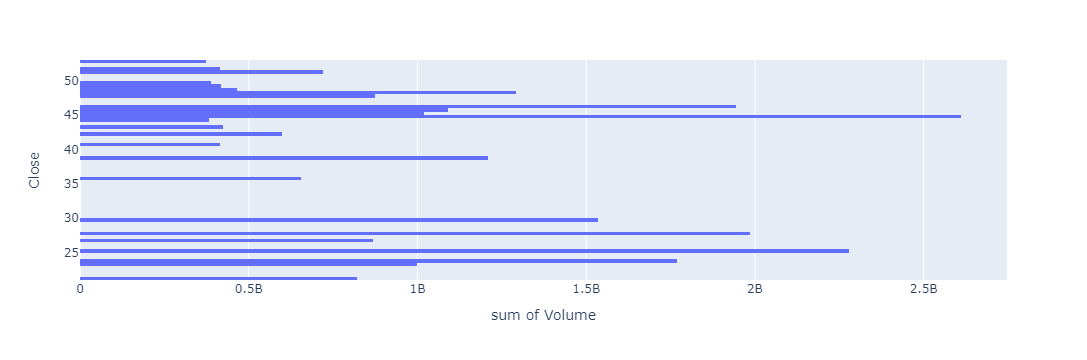

In [228]:
#This is the volume profile in which you get the volume activity at each price.  This highest volume activity at a certain price can make that price
#a good bounce off point
px.histogram(df_stock_mo, x='Volume', y='Close', nbins=150, orientation='h').show()

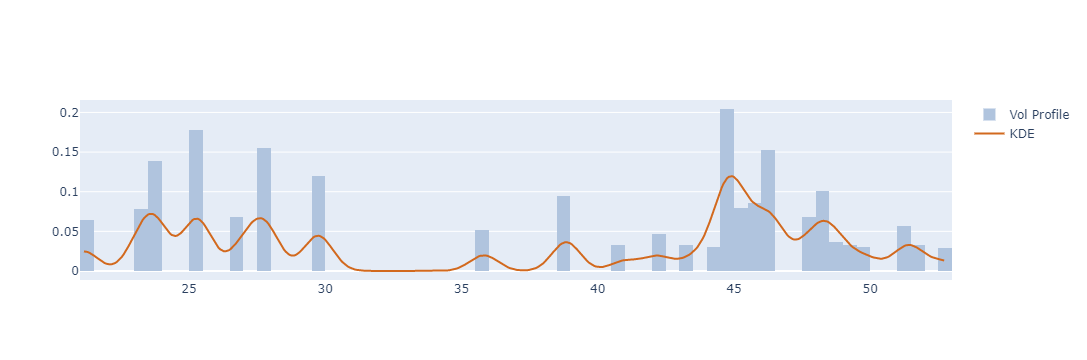

In [229]:
#Vertical volume profile monthly
kde_factor = 0.05
num_samples = 500
close = df_stock_mo['Close']
volume = df_stock_mo['Volume']
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

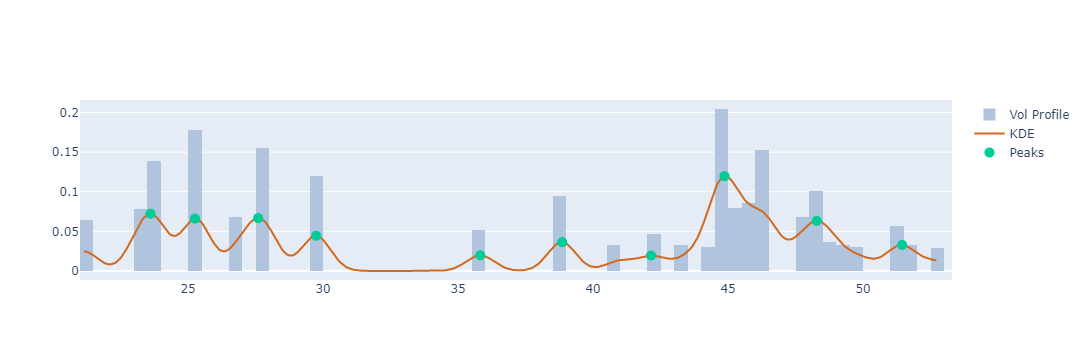

In [230]:
#green dot added monthly
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
rgs=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

In [231]:
#Dashboard functions
#calls the graphs we want to put in
import panel as pn
from panel.interact import interact
import mplfinance as mpf
%matplotlib widget

pn.extension()

def daily_figure():
# add 2 subplots: 1. bars, 2. crosses
    %matplotlib widget
    apds = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
            mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
            mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
            mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
            mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
            mpf.make_addplot(df_stock['Moving average'], color = 'black'),
            mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
            mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
            mpf.make_addplot(df_stock[['adx']], panel=2, color = 'purple', secondary_y=False),
            mpf.make_addplot(df_stock[['plus_di']], panel=2, color = 'green', secondary_y=False),
            mpf.make_addplot(df_stock[['minus_di']], panel=2, color = 'orange', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_08'], panel=3, color='red', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_21'], panel=3, color='orange', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_34'], panel=3, color='yellow', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_55'], panel=3, color='green', secondary_y=False),
            mpf.make_addplot(df_stock['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
    fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)
    
    return pn.pane.Matplotlib(fig, tight=True)

def daily_figure_2():
    %matplotlib widget
    apds2 = [mpf.make_addplot(df_stock['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
             mpf.make_addplot([0] * len(df_stock), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock['squeeze_off']], secondary_y=False),
             mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
             mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
             mpf.make_addplot(df_stock[['upper_KC']], color = 'blue'),
             mpf.make_addplot(df_stock[['lower_KC']], color = 'blue'),
             mpf.make_addplot(df_stock['Moving average'], color = 'black'),
             mpf.make_addplot(df_stock['m_avg_08'], color = 'green'),
             mpf.make_addplot(df_stock['m_avg_34'], color = 'orange'),
             mpf.make_addplot(df_stock['slow_K'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock['fast_K'], panel=2, color = 'blue'),
             mpf.make_addplot(df_stock['Overbought'], panel=2, color = 'green'),
             mpf.make_addplot(df_stock['Oversold'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock['Overbought'], panel=3, color = 'green'),
             mpf.make_addplot(df_stock['Oversold'], panel=3, color = 'red'),
             mpf.make_addplot(df_stock['rsi_14'], panel=3, color='purple')]

    fig, axes = mpf.plot(df_stock, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

def weekly_figure(): 
    %matplotlib widget
# add 2 subplots: 1. bars, 2. crosses
    apds = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
            mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
            mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
            mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
            mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
            mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
            mpf.make_addplot(df_stock_wk['m_avg_08'], color='green'),
            mpf.make_addplot(df_stock_wk['m_avg_34'], color='orange'),
            mpf.make_addplot(df_stock_wk[['adx']], panel=2, color = 'purple', secondary_y=False),
            mpf.make_addplot(df_stock_wk[['plus_di']], panel=2, color = 'green', secondary_y=False),
            mpf.make_addplot(df_stock_wk[['minus_di']], panel=2, color = 'orange', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_08'], panel=3, color='red', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_21'], panel=3, color='orange', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_34'], panel=3, color='yellow', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_55'], panel=3, color='green', secondary_y=False),
            mpf.make_addplot(df_stock_wk['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
    fig, axes = mpf.plot(df_stock_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

def weekly_figure_2():
    %matplotlib widget
    apds2 = [mpf.make_addplot(df_stock_wk['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
             mpf.make_addplot([0] * len(df_stock_wk), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_wk['squeeze_off']], secondary_y=False),
             mpf.make_addplot(df_stock_wk[['upper_BB']], color = 'red'),
             mpf.make_addplot(df_stock_wk[['lower_BB']], color = 'red'),
             mpf.make_addplot(df_stock_wk[['upper_KC']], color = 'blue'),
             mpf.make_addplot(df_stock_wk[['lower_KC']], color = 'blue'),
             mpf.make_addplot(df_stock_wk['Moving average weekly'], color = 'black'),
             mpf.make_addplot(df_stock_wk['m_avg_08'], color = 'green'),
             mpf.make_addplot(df_stock_wk['m_avg_34'], color = 'orange'),
             mpf.make_addplot(df_stock_wk['slow_K'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock_wk['fast_K'], panel=2, color = 'blue'),
             mpf.make_addplot(df_stock_wk['Overbought'], panel=2, color = 'green'),
             mpf.make_addplot(df_stock_wk['Oversold'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock_wk['Overbought'], panel=3, color = 'green'),
             mpf.make_addplot(df_stock_wk['Oversold'], panel=3, color = 'red'),
             mpf.make_addplot(df_stock_wk['rsi_14'], panel=3, color='purple')]

    fig, axes = mpf.plot(df_stock_wk, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

def monthly_figure(): 
    %matplotlib widget
# add 2 subplots: 1. bars, 2. crosses
    apds = [mpf.make_addplot(df_stock_mo['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
            mpf.make_addplot([0] * len(df_stock_mo), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_mo['squeeze_off']], secondary_y=False),
            mpf.make_addplot(df_stock_mo[['upper_BB']], color = 'red'),
            mpf.make_addplot(df_stock_mo[['lower_BB']], color = 'red'),
            mpf.make_addplot(df_stock_mo[['upper_KC']], color = 'blue'),
            mpf.make_addplot(df_stock_mo[['lower_KC']], color = 'blue'),
            mpf.make_addplot(df_stock_mo['Moving average monthly'], color = 'black'),
            mpf.make_addplot(df_stock_mo['m_avg_08'], color='green'),
            mpf.make_addplot(df_stock_mo['m_avg_34'], color='orange'),
            mpf.make_addplot(df_stock_mo[['adx']], panel=2, color = 'purple', secondary_y=False),
            mpf.make_addplot(df_stock_mo[['plus_di']], panel=2, color = 'green', secondary_y=False),
            mpf.make_addplot(df_stock_mo[['minus_di']], panel=2, color = 'orange', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_08'], panel=3, color='red', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_21'], panel=3, color='orange', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_34'], panel=3, color='yellow', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_55'], panel=3, color='green', secondary_y=False),
            mpf.make_addplot(df_stock_mo['m_avg_89'], panel=3, color='blue', secondary_y=False)]

# plot ohcl with subplots
    fig, axes = mpf.plot(df_stock_mo, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

def monthly_figure_2():
    %matplotlib widget
    apds2 = [mpf.make_addplot(df_stock_mo['value'], panel=1, type='bar', color=colors, alpha=0.8, secondary_y=False),
             mpf.make_addplot([0] * len(df_stock_mo), panel=1, type='scatter', marker='o', markersize=50, color=['gray' if s else 'red' for s in df_stock_mo['squeeze_off']], secondary_y=False),
             mpf.make_addplot(df_stock_mo[['upper_BB']], color = 'red'),
             mpf.make_addplot(df_stock_mo[['lower_BB']], color = 'red'),
             mpf.make_addplot(df_stock_mo[['upper_KC']], color = 'blue'),
             mpf.make_addplot(df_stock_mo[['lower_KC']], color = 'blue'),
             mpf.make_addplot(df_stock_mo['Moving average monthly'], color = 'black'),
             mpf.make_addplot(df_stock_mo['m_avg_08'], color = 'green'),
             mpf.make_addplot(df_stock_mo['m_avg_34'], color = 'orange'),
             mpf.make_addplot(df_stock_mo['slow_K'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock_mo['fast_K'], panel=2, color = 'blue'),
             mpf.make_addplot(df_stock_mo['Overbought'], panel=2, color = 'green'),
             mpf.make_addplot(df_stock_mo['Oversold'], panel=2, color = 'red'),
             mpf.make_addplot(df_stock_mo['Overbought'], panel=3, color = 'green'),
             mpf.make_addplot(df_stock_mo['Oversold'], panel=3, color = 'red'),
             mpf.make_addplot(df_stock_mo['rsi_14'], panel=3, color='purple')]

    fig, axes = mpf.plot(df_stock_mo, 
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              addplot=apds2,
              returnfig=True)
    return pn.pane.Matplotlib(fig, tight=True)

In [232]:
from yahoo_fin import options
import plotly.graph_objects as go
import pandas as pd

def get_option_chain(value):
    option_chain = options.get_options_chain(value)
    calls_chain = options.get_calls(value)
    return calls_chain

In [233]:
calls_chain = options.get_calls(value)
calls_chain

Contract Name         Last Trade Date  Strike  Last Price    Bid  \
0   WFC211022C00038000  2021-10-15 10:29AM EDT    38.0       10.25  10.30   
1   WFC211022C00039000   2021-10-14 3:20PM EDT    39.0        6.90   9.30   
2   WFC211022C00040000  2021-10-15 10:56AM EDT    40.0        8.45   8.30   
3   WFC211022C00041000   2021-10-15 2:36PM EDT    41.0        7.45   7.30   
4   WFC211022C00042000  2021-10-15 12:38PM EDT    42.0        6.20   6.30   
5   WFC211022C00043000   2021-10-14 3:12PM EDT    43.0        5.45   5.30   
6   WFC211022C00044000   2021-10-15 3:56PM EDT    44.0        4.39   4.35   
7   WFC211022C00045000   2021-10-15 3:37PM EDT    45.0        3.46   3.35   
8   WFC211022C00046000   2021-10-15 3:55PM EDT    46.0        2.56   2.42   
9   WFC211022C00047000   2021-10-15 3:56PM EDT    47.0        1.65   1.62   
10  WFC211022C00048000   2021-10-15 3:53PM EDT    48.0        0.96   0.92   
11  WFC211022C00049000   2021-10-15 3:59PM EDT    49.0        0.49   0.46   
12  WFC211022C00050000   2021-10-15 3:59PM EDT    50.0        0.24   0.21   
13  WFC211022C00051000   2021-10-15 3:55PM EDT    51.0        0.12   0.11   
14  WFC211022C00052000   2021-10-15 3:59PM EDT    52.0        0.07   0.06   
15  WFC211022C00053000   2021-10-15 3:58PM EDT    53.0        0.04   0.04   
16  WFC211022C00054000   2021-10-15 3:35PM EDT    54.0        0.04   0.03   
17  WFC211022C00055000   2021-10-15 3:56PM EDT    55.0        0.02   0.02   
18  WFC211022C00056000   2021-10-15 3:51PM EDT    56.0        0.02   0.01   
19  WFC211022C00060000   2021-10-14 9:38AM EDT    60.0        0.01   0.00   
20  WFC211022C00065000   2021-09-28 2:52PM EDT    65.0        0.02   0.00   

      Ask  Change  % Change  Volume  Open Interest Implied Volatility  
0   10.50    3.25   +46.43%       9              3             78.13%  
1    9.55    0.80   +13.11%       1              1             79.30%  
2    8.55    3.12   +58.54%      24             46             71.09%  
3    7.55    3.30   +79.52%      21             77             63.28%  
4    6.60    3.00   +93.75%       2            173             60.16%  
5    5.55    3.08  +129.96%      80            161             63.67%  
6    4.55    2.79  +174.37%     319           1076             54.20%  
7    3.60    2.47  +249.49%    5356           9624             48.24%  
8    2.62    2.03  +383.02%    8214           9153             38.97%  
9    1.74    1.38  +511.11%    9748          13615             33.59%  
10   0.98    0.84  +700.00%    6801           2423             29.10%  
11   0.49    0.42  +600.00%   10657           3002             28.22%  
12   0.24    0.20  +500.00%    5947           5090             29.59%  
13   0.12    0.10  +500.00%    3267           2759             31.54%  
14   0.07    0.05  +250.00%    4734           1730             34.77%  
15   0.05    0.02  +100.00%    1125            279             38.67%  
16   0.04    0.01   +33.33%     224            115             43.36%  
17   0.03    0.00         -      16            330             46.88%  
18   0.05    0.00         -     106            222             52.34%  
19   0.03    0.00         -      25            312             65.63%  
20   0.03    0.00         -      11            136             85.94%

In [234]:
# Create a Title for the Dashboard
#Dashboard setup with the warnings and the graphs
%matplotlib widget
title = "Stock Trading Dashboard"
welcome_tab = pn.Row(pn.Column(title, "Monthly Warnings", momentum_checker_mo(-1), ADX_trend_flag_mo(-1), warning_mo(-1), squeeze_flag_mo(-1), squeeze_momentum_mo(-1)), 
                     pn.Column("Weekly Warnings", momentum_checker_wk(-1), ADX_trend_flag_wk(-1), warning_wk(-1), squeeze_flag_wk(-1), squeeze_momentum_wk(-1)),
                     pn.Column("Daily Warnings",momentum_checker(-1), ADX_trend_flag(-1), warning(-1), squeeze_flag(-1), squeeze_momentum(-1)))

monthly_analysis_tab = pn.Column(monthly_figure(), monthly_figure_2())

# Create a tab layout for the dashboard
weekly_analysis_tab = pn.Column(weekly_figure(), weekly_figure_2())

daily_analysis_tab = pn.Column(daily_figure(), daily_figure_2())

option_chain_tab = pn.Column(get_option_chain(value))

# Create the dashboard
SF_dashboard = pn.Tabs(("Welcome", welcome_tab), 
("Monthly Market Analysis", monthly_analysis_tab),
("Weekly Market Analysis", weekly_analysis_tab), 
("Daily Market Analysis", daily_analysis_tab),
("Option Chain", option_chain_tab))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Tabs
    [0] Row
        [0] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Markdown(str)
            [3] Markdown(str)
            [4] Markdown(str)
            [5] Markdown(str)
            [6] Markdown(str)
        [1] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Markdown(str)
            [3] Markdown(str)
            [4] Markdown(str)
            [5] Markdown(str)
        [2] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Markdown(str)
            [3] Markdown(str)
            [4] Markdown(str)
            [5] Markdown(str)
    [1] Column
        [0] Matplotlib(Figure, tight=True)
        [1] Matplotlib(Figure, tight=True)
    [2] Column
        [0] Matplotlib(Figure, tight=True)
        [1] Matplotlib(Figure, tight=True)
    [3] Column
        [0] Matplotlib(Figure, tight=True)
        [1] Matplotlib(Figure, tight=True)
    [4] Column
        [0] DataFrame(DataFrame)
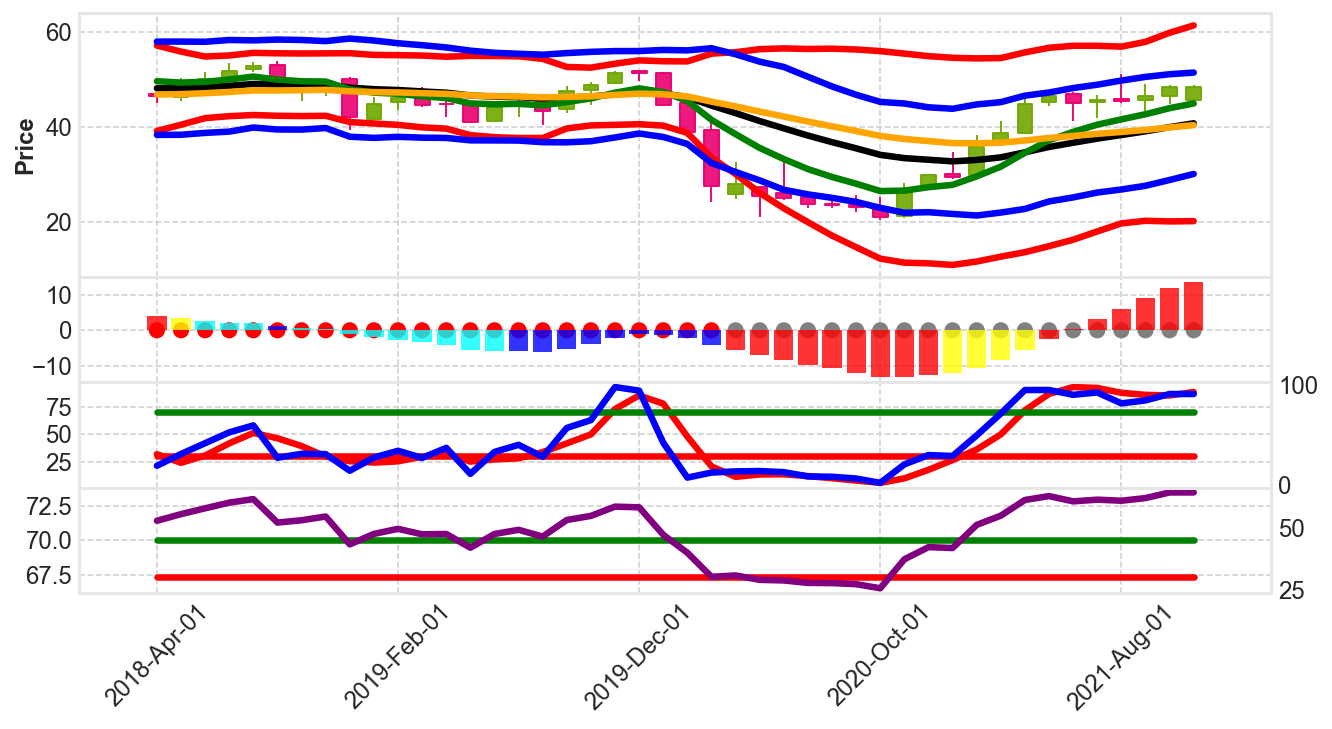
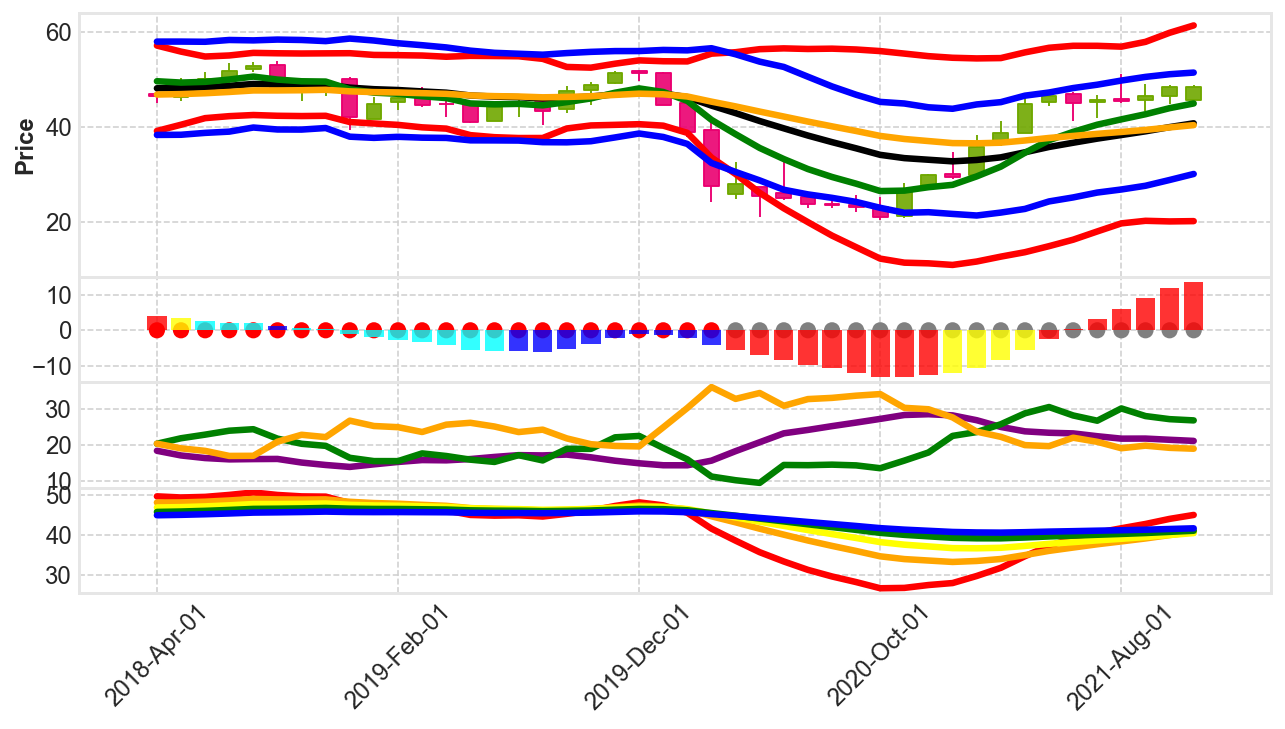
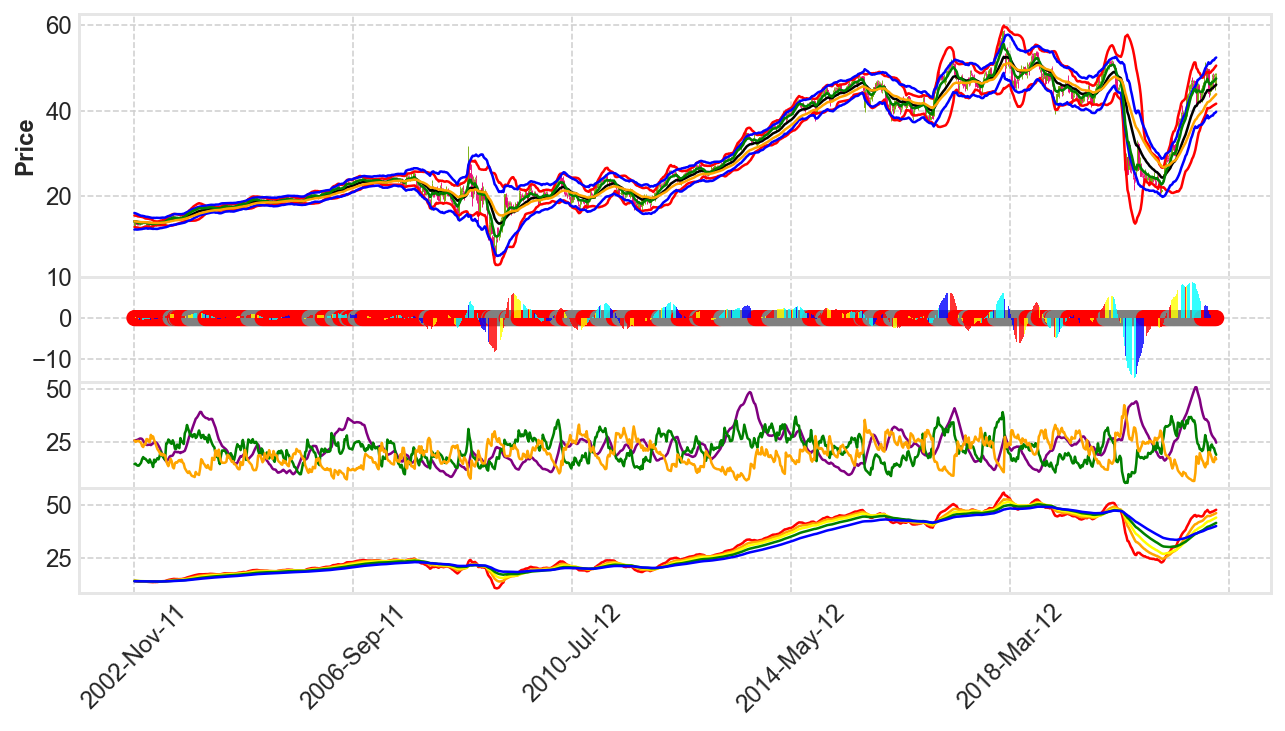
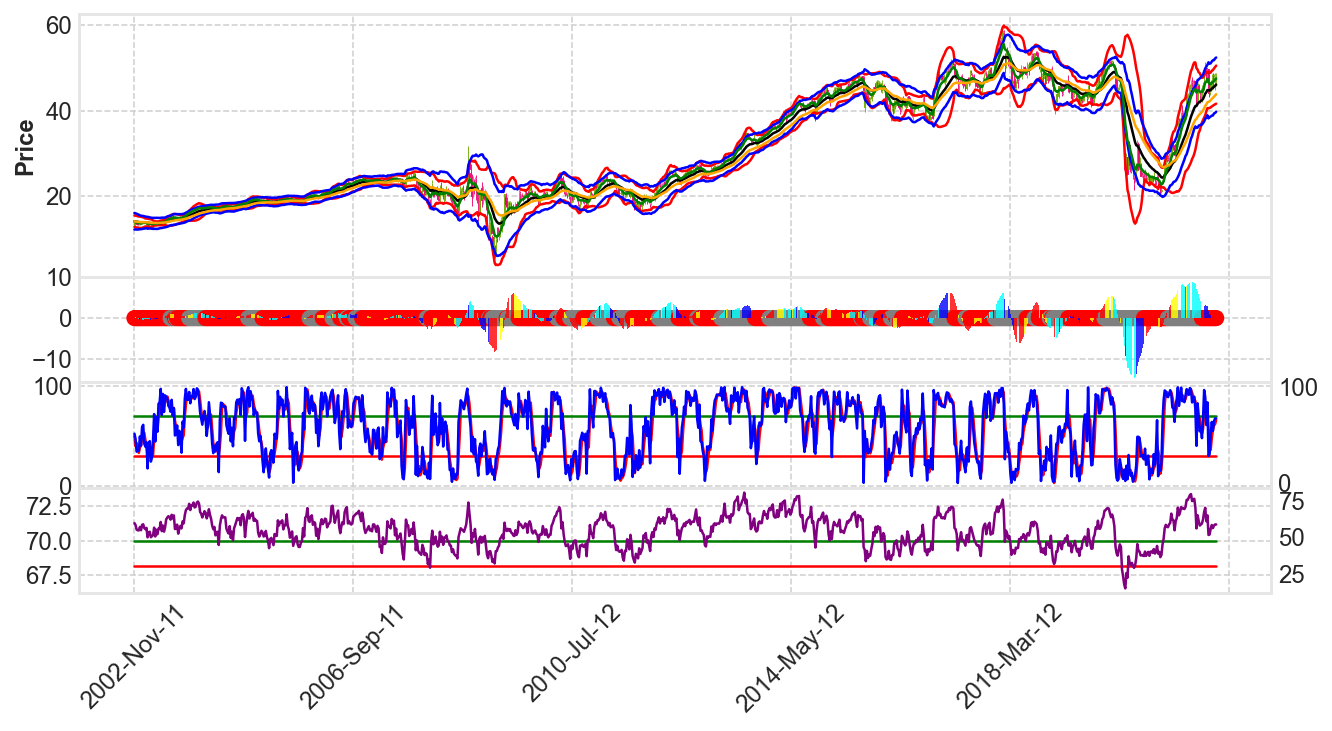
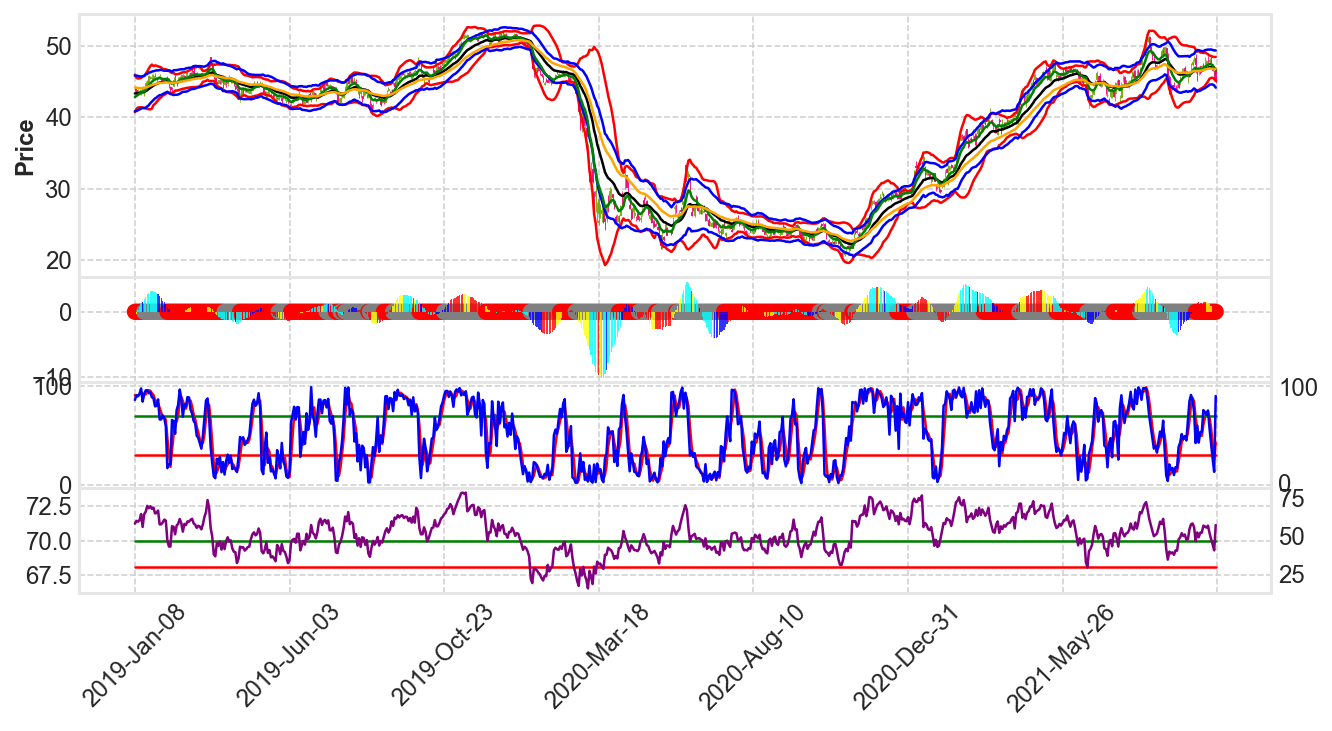
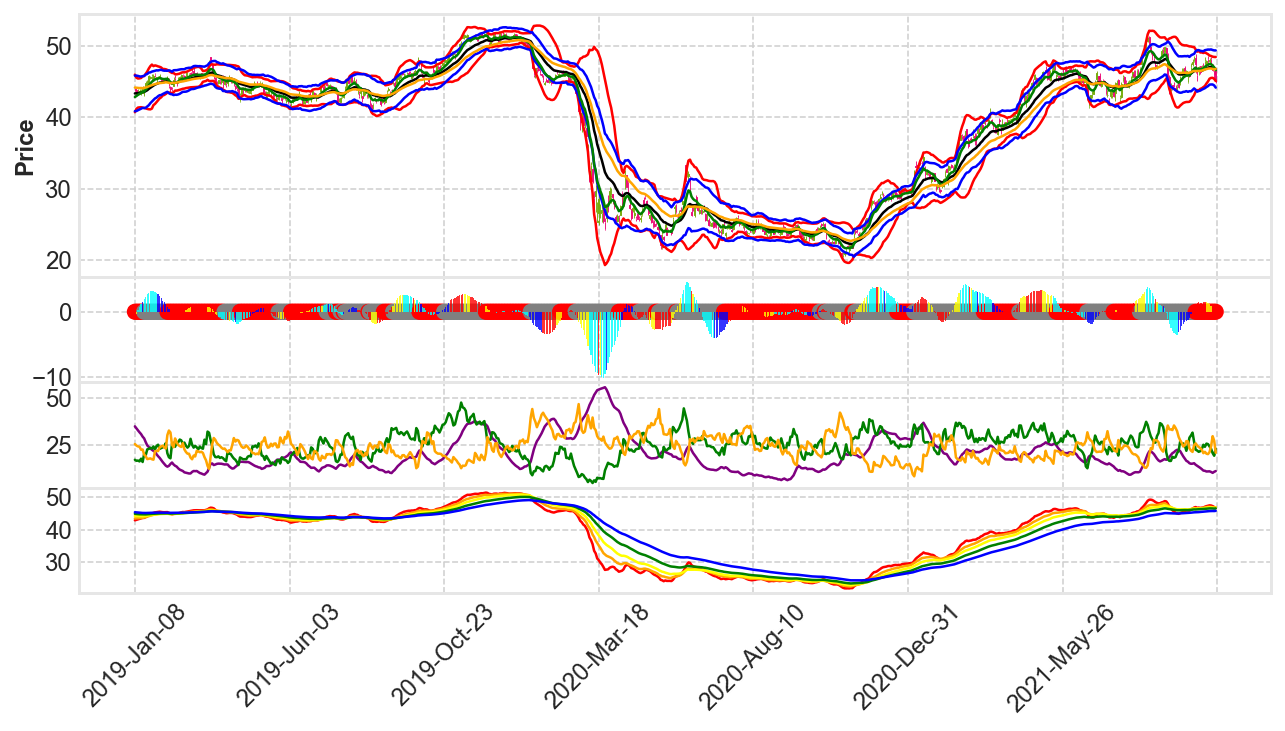

In [235]:
SF_dashboard.servable()